# Motion Diffusion Model (MDM) Processing pipline
# Project Overview
### This project implements a Motion Diffusion Model (MDM) that generates human motion sequences based on RGB and depth image inputs. The system uses a diffusion-based generative approach to create realistic and contextually appropriate human movements that correspond to visual scene information.

In [1]:
!PYTHONPATH=.

# Step 1: Environment Setup and Dependencies


## 1.1 Installing Required Libraries

In [2]:
!pip install -U pip setuptools wheel cython
!pip install torch==2.1.2 torchvision==0.16.2 clearml==1.6.0 tensorboard==2.8.0 blobfile spacy==2.3.5
!pip install numpy==1.21.0 --no-deps --force-reinstall
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/vchoutas/smplx.git
!pip install einops
!pip install spacy

  Using cached torch-2.1.2-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchvision-0.16.2-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached clearml-1.6.0-py2.py3-none-any.whl.metadata (14 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached spacy-2.3.5.tar.gz (5.8 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Using cached numpy-1.21.0.zip (10.3 MB)
  Installing build dependencies ... done
  Getting requir

## 1.2 Path Configuration and System Setup

In [11]:
import sys
sys.path.insert(0, "/content/Master_Class")

In [12]:
import os, glob, torch

# define and create a checkpoint folder
save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

# attempt to resume from the latest ckpt
ckpts = glob.glob(os.path.join(save_dir, "ckpt_ep*.pth"))
if ckpts:
    latest = sorted(ckpts, key=lambda x: int(x.split("ep")[-1].split(".pth")[0]))[-1]
    print("Resuming from", latest)
    ck = torch.load(latest, map_location=device)
    model.load_state_dict(ck["model_state_dict"])
    optim.load_state_dict(ck["optim_state_dict"])
    start_epoch = ck["epoch"] + 1
else:
    start_epoch = 0


In [26]:
BASE_DIR  = "/content/Master_Class"
POSE_DIR  = f"{BASE_DIR}/poses"
RGB_DIR   = f"{BASE_DIR}/Depth_img/RGB"
DEPTH_DIR = f"{BASE_DIR}/Depth_img/Depth"
CODE_DIR  = f"{BASE_DIR}/MDM"
sys.path.insert(0, CODE_DIR)

# Step 2: Data Preprocessing and Normalization

## 2.1 Loading and Processing Pose Data

In [14]:
import os
import numpy as np
import torch

# Add numpy compatibility for newer versions
if not hasattr(np, 'float'):
    np.float = np.float64

In [15]:
import json
import clip
from torch.utils.data import DataLoader
from utils.fixseed import fixseed
from utils.parser_util import train_args
from utils import dist_util
from train.training_loop import TrainLoop
from data_loaders.get_data import get_dataset_loader
from utils.model_util import create_model_and_diffusion
from train.train_platforms import ClearmlPlatform, TensorboardPlatform, NoPlatform  # required for the eval operation

/content/Master_Class//MDM/diffusion/nn.py:150: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_fwd
/content/Master_Class//MDM/diffusion/nn.py:160: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @th.cuda.amp.custom_bwd


## 2.2 Loading and Processing Image Data (RGB, Depth, and Motion)

In [19]:
import os
import numpy as np
import torch

pose_array_ls = []
for f in os.listdir(POSE_DIR):
    path = os.path.join(POSE_DIR, f)
    arr = np.load(path)
    if np.isnan(arr).any():
        continue
    pose_array_ls.append(arr)

pose_array = np.array(pose_array_ls).reshape(-1, 120, 138)
mean = np.mean(pose_array, axis=0)
std  = np.std(pose_array, axis=0)

np.save("single_mean.npy", mean)
np.save("single_std.npy", std)

# normalize and make into torch tensor
pose_array = (pose_array - mean) / (std + 1e-9)
pose_tensor = torch.tensor(pose_array) \
                   .permute(0, 2, 1) \
                   .reshape(-1, 138, 1, 120)

print(pose_tensor.shape)


torch.Size([17728, 138, 1, 120])


In [27]:
import os
import numpy as np
import cv2
from transformers import AutoImageProcessor, Dinov2Model
import torch
from PIL import Image

RGB_img_emb_ls = []
Dep_img_ls     = []
motion_ls      = []

# loop over your RGB scenes
for folder in os.listdir(RGB_DIR):
    scene_dir = os.path.join(RGB_DIR, folder)
    if not os.path.isdir(scene_dir):
        continue
    for img in os.listdir(scene_dir):
        if not img.lower().endswith(".png"):
            continue

        # load RGB
        img_path = os.path.join(scene_dir, img)
        raw_img = Image.open(img_path).convert("RGB")
        raw_img = torch.tensor(np.array(raw_img))
        RGB_img_emb_ls.append(raw_img)

        # load Depth
        depth_file = img.split(".")[0] + ".npy"
        depth_path = os.path.join(DEPTH_DIR, folder, depth_file)
        Dep_img_ls.append(np.load(depth_path))

        # load Pose
        pose_path = os.path.join(POSE_DIR, depth_file)
        motion_ls.append(np.load(pose_path))

# stack into tensors
RGB_img_emb_tensor = torch.stack(RGB_img_emb_ls) / 255
Dep_img_tensor     = torch.tensor(np.array(Dep_img_ls)) / 1470.73
motion_tensor      = torch.tensor(np.array(motion_ls))


## 2.3 Creating the Dataset and DataLoader

In [28]:
from torch.utils.data import TensorDataset, DataLoader

MEAN = np.load("single_mean.npy")
STD = np.load("single_std.npy")

motion_reshape_tensor = (motion_tensor.reshape(-1,120,138)-MEAN)/(STD+0.000000001)
motion_reshape_tensor = motion_reshape_tensor.permute(0,2,1).unsqueeze(2)
dataset = TensorDataset(RGB_img_emb_tensor, Dep_img_tensor, motion_reshape_tensor)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=5)

<ipython-input-28-352196ba61ac>:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  motion_reshape_tensor = (motion_tensor.reshape(-1,120,138)-MEAN)/(STD+0.000000001)


In [29]:
for i in dataloader:
    print(i[1].shape)

torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([64, 512, 512])
torch.Size([32, 512, 512])


# Step 3: Model Architecture and Configuration

## 3.1 Argument Parsing for Model Configuration

In [30]:
from argparse import ArgumentParser
import argparse

def add_base_options(parser):
    group = parser.add_argument_group('base')
    group.add_argument("--cuda", default=True, type=bool, help="Use cuda device, otherwise use CPU.")
    group.add_argument("--device", default=0, type=int, help="Device id to use.")
    group.add_argument("--seed", default=10, type=int, help="For fixing random seed.")
    group.add_argument("--batch_size", default=64, type=int, help="Batch size during training.")
    group.add_argument("--short_db", action='store_true', help="Load short babel for debug.")
    group.add_argument("--cropping_sampler", action='store_true', help="Load short babel for debug.")

def add_data_options(parser):
    group = parser.add_argument_group('dataset')
    group.add_argument("--dataset", default='humanml', choices=['humanml', 'amass', 'babel'], type=str,
                       help="Dataset name (choose from list).")
    group.add_argument("--data_dir", default="", type=str,
                       help="If empty, will use defaults according to the specified dataset.")

def add_model_options(parser):
    group = parser.add_argument_group('model')
    group.add_argument("--arch", default='trans_enc',
                       choices=['trans_enc', 'trans_dec', 'gru'], type=str,
                       help="Architecture types as reported in the paper.")
    group.add_argument("--emb_trans_dec", default=False, type=bool,
                       help="For trans_dec architecture only, if true, will inject condition as a class token"
                            " (in addition to cross-attention).")
    group.add_argument("--layers", default=8, type=int,
                       help="Number of layers.")
    group.add_argument("--latent_dim", default=512, type=int,
                       help="Transformer/GRU width.")
    group.add_argument("--cond_mask_prob", default=.1, type=float,
                       help="The probability of masking the condition during training."
                            " For classifier-free guidance learning.")
    group.add_argument("--lambda_rcxyz", default=0.0, type=float, help="Joint positions loss.")
    group.add_argument("--lambda_vel", default=0.0, type=float, help="Joint velocity loss.")
    group.add_argument("--lambda_fc", default=0.0, type=float, help="Foot contact loss.")
    group.add_argument("--use_tta", action='store_true', help="Time To Arrival position encoding")  # FIXME REMOVE?
    group.add_argument("--concat_trans_emb", action='store_true', help="Concat transition emb, else append after linear")  # FIXME REMOVE?
    group.add_argument("--trans_emb", action='store_true', help="Allow transition embedding")  # FIXME REMOVE?

    group.add_argument("--context_len", default=0, type=int, help="If larger than 0, will do prefix completion.")
    group.add_argument("--pred_len", default=0, type=int, help="If context_len larger than 0, will do prefix completion. If pred_len will not be specified - will use the same length as context_len")

def add_diffusion_options(parser):
    group = parser.add_argument_group('diffusion')
    group.add_argument("--noise_schedule", default='cosine', choices=['linear', 'cosine'], type=str,
                       help="Noise schedule type")
    group.add_argument("--diffusion_steps", default=1000, type=int,
                       help="Number of diffusion steps (denoted T in the paper)")
    group.add_argument("--sigma_small", default=True, type=bool, help="Use smaller sigma values.")

def add_training_options(parser):
    group = parser.add_argument_group('training')
    group.add_argument("--save_dir", required=False, default="/workspace/priorMD/temporary_folder/test_our_chatgptData", type=str,
                       help="Path to save checkpoints and results.")
    group.add_argument("--overwrite", action='store_true',
                       help="If True, will enable to use an already existing save_dir.")
    group.add_argument("--train_platform_type", default='NoPlatform', choices=['NoPlatform', 'ClearmlPlatform', 'TensorboardPlatform'], type=str,
                       help="Choose platform to log results. NoPlatform means no logging.")
    group.add_argument("--lr", default=1e-4, type=float, help="Learning rate.")
    group.add_argument("--weight_decay", default=0.0, type=float, help="Optimizer weight decay.")
    group.add_argument("--lr_anneal_steps", default=0, type=int, help="Number of learning rate anneal steps.")
    group.add_argument("--eval_batch_size", default=32, type=int,
                       help="Batch size during evaluation loop. Do not change this unless you know what you are doing. "
                            "T2m precision calculation is based on fixed batch size 32.")
    group.add_argument("--eval_split", default='test', choices=['val', 'test'], type=str,
                       help="Which split to evaluate on during training.")
    group.add_argument("--eval_during_training", action='store_true',
                       help="If True, will run evaluation during training.")
    group.add_argument("--eval_rep_times", default=3, type=int,
                       help="Number of repetitions for evaluation loop during training.")
    group.add_argument("--eval_num_samples", default=1_000, type=int,
                       help="If -1, will use all samples in the specified split.")
    group.add_argument("--log_interval", default=1_000, type=int,
                       help="Log losses each N steps")
    group.add_argument("--save_interval", default=6_000, type=int,
                       help="Save checkpoints and run evaluation each N steps")
    group.add_argument("--num_steps", default=300_000, type=int,
                       help="Training will stop after the specified number of steps.")
    group.add_argument("--num_frames", default=120, type=int,
                       help="Limit for the maximal number of frames. In HumanML3D and KIT this field is ignored.")
    group.add_argument("--resume_checkpoint", default="", type=str,
                       help="If not empty, will start from the specified checkpoint (path to model###.pt file).")

def add_frame_sampler_options(parser):
    group = parser.add_argument_group('framesampler')
    group.add_argument("--min_seq_len", default=45, type=int,
                       help="babel dataset FrameSampler minimum length")
    group.add_argument("--max_seq_len", default=250, type=int,
                       help="babel dataset FrameSampler maximum length")

parser = ArgumentParser()
add_base_options(parser)
add_data_options(parser)
add_model_options(parser)
add_diffusion_options(parser)
add_training_options(parser)
add_frame_sampler_options(parser)
args, unknown = parser.parse_known_args()

#args

## 3.2 Model Definition (MDM) and Supporting Network Components

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
import os
#from priorMD.model.rotation2xyz import Rotation2xyz

class MDM(nn.Module):
    def __init__(self, njoints, nfeats, num_actions, translation, pose_rep, glob, glob_rot,
                 latent_dim=512, ff_size=1024, num_layers=8, num_heads=4, dropout=0.1,
                 ablation=None, activation="gelu", legacy=False, data_rep='rot6d', dataset='amass', clip_dim=512,
                 arch='trans_enc', emb_trans_dec=False, clip_version=None, **kargs):
        super().__init__()

        self.legacy = legacy
        #self.modeltype = modeltype
        self.njoints = njoints
        self.nfeats = nfeats
        self.num_actions = num_actions
        self.data_rep = data_rep
        self.dataset = dataset

        self.pose_rep = pose_rep
        self.glob = glob
        self.glob_rot = glob_rot
        self.translation = translation

        self.latent_dim = latent_dim

        self.ff_size = ff_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout

        self.ablation = ablation
        self.activation = activation
        self.clip_dim = clip_dim
        self.action_emb = kargs.get('action_emb', None)

        self.input_feats = self.njoints * self.nfeats

        self.normalize_output = kargs.get('normalize_encoder_output', False)

        self.cond_mode = 'text'# kargs.get('cond_mode', 'no_cond')
        self.cond_mask_prob = kargs.get('cond_mask_prob', 0.)
        self.arch = arch
        self.gru_emb_dim = self.latent_dim if self.arch == 'gru' else 0
        self.Cam_input_process = CamInputProcess(self.data_rep, self.input_feats+self.gru_emb_dim, self.latent_dim)

        self.sequence_pos_encoder = PositionalEncoding(self.latent_dim, self.dropout)
        self.emb_trans_dec = emb_trans_dec

        self.Camera_input_process = nn.Linear(6, self.latent_dim)
        self.Camera_output_process = nn.Linear(self.latent_dim, 6)

        self.encode_img = nn.Linear(768, 512)
        self.encode_con = nn.Linear(1536, 512)

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # (B, 32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, H/8, W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1)))

        self.depth_cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (B, 32, H/2, W/2)
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 64, H/4, W/4)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (B, 128, H/8, W/8)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1)))

        self.fc = nn.Linear(128, 512)
        self.depth_fc = nn.Linear(128, 512)

        if self.arch == 'trans_enc':
            print("TRANS_ENC init")

            CamTransEncoderLayer = nn.TransformerEncoderLayer(d_model=self.latent_dim,
                                                              nhead=self.num_heads,
                                                              dim_feedforward=self.ff_size,
                                                              dropout=self.dropout,
                                                              activation=self.activation)

            self.CamTransEncoder = nn.TransformerEncoder(CamTransEncoderLayer,
                                                         num_layers=self.num_layers)

        self.embed_timestep = TimestepEmbedder(self.latent_dim, self.sequence_pos_encoder)

        if self.cond_mode != 'no_cond':
            if 'text' in self.cond_mode:
                self.embed_text = nn.Linear(self.clip_dim, self.latent_dim)
                print('EMBED TEXT')
                print('Loading CLIP...')
               # self.clip_version = clip_version
               # self.clip_model = self.load_and_freeze_clip(clip_version)
            if 'action' in self.cond_mode:
                self.embed_action = EmbedAction(self.num_actions, self.latent_dim)
                print('EMBED ACTION')

        self.Cam_output_process = CamOutputProcess(self.data_rep, self.input_feats, self.latent_dim, self.njoints,
                                            self.nfeats)

        #self.rot2xyz = Rotation2xyz(device='cpu', dataset=self.dataset)

    def parameters_wo_clip(self):
        return [p for name, p in self.named_parameters() if not name.startswith('clip_model.')]

    def load_and_freeze_clip(self, clip_version):
        clip_model, clip_preprocess = clip.load(clip_version, device='cpu',
                                                jit=False)  # Must set jit=False for training
        clip.model.convert_weights(
            clip_model)  # Actually this line is unnecessary since clip by default already on float16

        # Freeze CLIP weights
        clip_model.eval()
        for p in clip_model.parameters():
            p.requires_grad = False

        return clip_model

    def mask_cond(self, cond, force_mask=False):
        bs, d = cond.shape
        if force_mask:
            return torch.zeros_like(cond)
        elif self.training and self.cond_mask_prob > 0.:
            mask = torch.bernoulli(torch.ones(bs, device=cond.device) * self.cond_mask_prob).view(bs, 1)  # 1-> use null_cond, 0-> use real cond
            return cond * (1. - mask)
        else:
            return cond

    def encode_text(self, raw_text):
        # raw_text - list (batch_size length) of strings with input text prompts
        device = next(self.parameters()).device
        max_text_len = 20 if self.dataset in ['humanml', 'kit'] else None  # Specific hardcoding for humanml dataset
        if max_text_len is not None:
            default_context_length = 77
            context_length = max_text_len + 2 # start_token + 20 + end_token
            assert context_length < default_context_length
            texts = clip.tokenize(raw_text, context_length=context_length, truncate=True).to(device) # [bs, context_length] # if n_tokens > context_length -> will truncate
            # print('texts', texts.shape)
            zero_pad = torch.zeros([texts.shape[0], default_context_length-context_length], dtype=texts.dtype, device=texts.device)
            texts = torch.cat([texts, zero_pad], dim=1)
            # print('texts after pad', texts.shape, texts)
        else:
            texts = clip.tokenize(raw_text, truncate=True).to(device) # [bs, context_length] # if n_tokens > 77 -> will truncate
        return self.clip_model.encode_text(texts).float()

    def forward(self, x, timesteps, y=None):
        #print(x.shape)
        """
        x: [batch_size, njoints, nfeats, max_frames], denoted x_t in the paper
        timesteps: [batch_size] (int)
        """

        #print(y.shape)


        bs, njoints, nfeats, nframes = x.shape
        emb = self.embed_timestep(timesteps)  # [1, bs, d]

        rgb_img = y[0]
        depth_img = y[1]

        #print(rgb_img.shape, depth_img.shape)

        rgb_encode = self.cnn(rgb_img.permute(0,3,1,2))
        rgb_encode = rgb_encode.view(rgb_encode.size(0), -1)  # Flatten
        rgb_encode = self.fc(rgb_encode).unsqueeze(0)


        depth_encode = self.depth_cnn(depth_img.unsqueeze(1))
        depth_encode = depth_encode.view(depth_encode.size(0), -1)  # Flatten
        depth_encode = self.fc(depth_encode).unsqueeze(0)

        #print(rgb_encode.shape, depth_encode.shape)

        #print(emb.shape, y_encode.shape)
        con = torch.cat([emb,rgb_encode,depth_encode],dim=-1)
        #print(con.shape)

        con_encode = self.encode_con(con)

        #emb += self.encode_img(y)

        x = self.Cam_input_process(x)

        if self.arch == 'trans_enc':
            # adding the timestep embed
            xseq = torch.cat((con_encode, x), axis=0)  # [seqlen+1, bs, d]
            xseq = self.sequence_pos_encoder(xseq)  # [seqlen+1, bs, d]
            output = self.CamTransEncoder(xseq)[1:]  # , src_key_padding_mask=~maskseq)  # [seqlen, bs, d]

        output = self.Cam_output_process(output)  # [bs, njoints, nfeats, nframes]

        return output


    #def _apply(self, fn):
        #super()._apply(fn)
        #self.rot2xyz.smpl_model._apply(fn)


    def train(self, *args, **kwargs):
        super().train(*args, **kwargs)
        #self.rot2xyz.smpl_model.train(*args, **kwargs)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # not used in the final model
        x = x + self.pe[:x.shape[0], :]
        return self.dropout(x)


class TimestepEmbedder(nn.Module):
    def __init__(self, latent_dim, sequence_pos_encoder):
        super().__init__()
        self.latent_dim = latent_dim
        self.sequence_pos_encoder = sequence_pos_encoder

        time_embed_dim = self.latent_dim
        self.time_embed = nn.Sequential(
            nn.Linear(self.latent_dim, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

    def forward(self, timesteps):
        return self.time_embed(self.sequence_pos_encoder.pe[timesteps]).permute(1, 0, 2)


class CamInputProcess(nn.Module):
    def __init__(self, data_rep, input_feats, latent_dim):
        super().__init__()
        self.data_rep = data_rep
        self.input_feats = input_feats
        self.latent_dim = latent_dim
        self.poseEmbedding = nn.Linear(self.input_feats, self.latent_dim)
        if self.data_rep == 'rot_vel':
            self.velEmbedding = nn.Linear(self.input_feats, self.latent_dim)

    def forward(self, x):
        bs, njoints, nfeats, nframes = x.shape
        x = x.permute((3, 0, 1, 2)).reshape(nframes, bs, njoints*nfeats)

        if self.data_rep in ['rot6d', 'xyz', 'hml_vec']:
            x = self.poseEmbedding(x)  # [seqlen, bs, d]
            return x
        elif self.data_rep == 'rot_vel':
            first_pose = x[[0]]  # [1, bs, 150]
            first_pose = self.poseEmbedding(first_pose)  # [1, bs, d]
            vel = x[1:]  # [seqlen-1, bs, 150]
            vel = self.velEmbedding(vel)  # [seqlen-1, bs, d]
            return torch.cat((first_pose, vel), axis=0)  # [seqlen, bs, d]
        else:
            raise ValueError


class CamOutputProcess(nn.Module):
    def __init__(self, data_rep, input_feats, latent_dim, njoints, nfeats):
        super().__init__()
        self.data_rep = data_rep
        self.input_feats = input_feats
        self.latent_dim = latent_dim
        self.njoints = njoints
        self.nfeats = nfeats
        self.poseFinal = nn.Linear(self.latent_dim, self.input_feats)
        if self.data_rep == 'rot_vel':
            self.velFinal = nn.Linear(self.latent_dim, self.input_feats)

    def forward(self, output):
        nframes, bs, d = output.shape
        if self.data_rep in ['rot6d', 'xyz', 'hml_vec']:
            output = self.poseFinal(output)  # [seqlen, bs, 150]
        elif self.data_rep == 'rot_vel':
            first_pose = output[[0]]  # [1, bs, d]
            first_pose = self.poseFinal(first_pose)  # [1, bs, 150]
            vel = output[1:]  # [seqlen-1, bs, d]
            vel = self.velFinal(vel)  # [seqlen-1, bs, 150]
            output = torch.cat((first_pose, vel), axis=0)  # [seqlen, bs, 150]
        else:
            raise ValueError
        output = output.reshape(nframes, bs, self.njoints, self.nfeats)
        output = output.permute(1, 2, 3, 0)  # [bs, njoints, nfeats, nframes]
        return output

class InputProcess(nn.Module):
    def __init__(self, data_rep, input_feats, latent_dim):
        super().__init__()
        self.data_rep = data_rep
        self.input_feats = input_feats
        self.latent_dim = latent_dim
        self.poseEmbedding = nn.Linear(self.input_feats, self.latent_dim)
        if self.data_rep == 'rot_vel':
            self.velEmbedding = nn.Linear(self.input_feats, self.latent_dim)

    def forward(self, x):
        bs, njoints, nfeats, nframes = x.shape
        x = x.permute((3, 0, 1, 2)).reshape(nframes, bs, njoints*nfeats)

        if self.data_rep in ['rot6d', 'xyz', 'hml_vec']:
            x = self.poseEmbedding(x)  # [seqlen, bs, d]
            return x
        elif self.data_rep == 'rot_vel':
            first_pose = x[[0]]  # [1, bs, 150]
            first_pose = self.poseEmbedding(first_pose)  # [1, bs, d]
            vel = x[1:]  # [seqlen-1, bs, 150]
            vel = self.velEmbedding(vel)  # [seqlen-1, bs, d]
            return torch.cat((first_pose, vel), axis=0)  # [seqlen, bs, d]
        else:
            raise ValueError


class OutputProcess(nn.Module):
    def __init__(self, data_rep, input_feats, latent_dim, njoints, nfeats):
        super().__init__()
        self.data_rep = data_rep
        self.input_feats = input_feats
        self.latent_dim = latent_dim
        self.njoints = njoints
        self.nfeats = nfeats
        self.poseFinal = nn.Linear(self.latent_dim, self.input_feats)
        if self.data_rep == 'rot_vel':
            self.velFinal = nn.Linear(self.latent_dim, self.input_feats)

    def forward(self, output):
        nframes, bs, d = output.shape
        if self.data_rep in ['rot6d', 'xyz', 'hml_vec']:
            output = self.poseFinal(output)  # [seqlen, bs, 150]
        elif self.data_rep == 'rot_vel':
            first_pose = output[[0]]  # [1, bs, d]
            first_pose = self.poseFinal(first_pose)  # [1, bs, 150]
            vel = output[1:]  # [seqlen-1, bs, d]
            vel = self.velFinal(vel)  # [seqlen-1, bs, 150]
            output = torch.cat((first_pose, vel), axis=0)  # [seqlen, bs, 150]
        else:
            raise ValueError
        output = output.reshape(nframes, bs, self.njoints, self.nfeats)
        output = output.permute(1, 2, 3, 0)  # [bs, njoints, nfeats, nframes]
        return output


class EmbedAction(nn.Module):
    def __init__(self, num_actions, latent_dim):
        super().__init__()
        self.action_embedding = nn.Parameter(torch.randn(num_actions, latent_dim))

    def forward(self, input):
        idx = input[:, 0].to(torch.long)  # an index array must be long
        output = self.action_embedding[idx]
        return output

# Step 4: Model & Diffusion Component Initialization

## 4.1 Creating the Model Instance and Setting up the Diffusion Process


In [32]:
from diffusion.respace import SpacedDiffusion, space_timesteps
from utils.model_util import create_gaussian_diffusion
from diffusion.gaussian_diffusion import (
    GaussianDiffusion,
    get_named_beta_schedule,
    create_named_schedule_sampler,
    ModelMeanType,
    ModelVarType,
    LossType
)

model = MDM(njoints=138, nfeats=1, num_actions=1, translation=True, pose_rep="rot6d", glob=True, glob_rot=True).to("cuda")

sampler_name = 'uniform'
beta_scheduler = 'linear'
betas = get_named_beta_schedule(beta_scheduler, args.diffusion_steps)
diffusion = GaussianDiffusion(
            betas=betas,
            model_mean_type=ModelMeanType.EPSILON,
            model_var_type=ModelVarType.FIXED_SMALL,
            loss_type=LossType.MSE
        )
sampler = create_named_schedule_sampler(sampler_name, diffusion)

TRANS_ENC init
EMBED TEXT
Loading CLIP...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 4.3 Training Configuration

In [33]:
n_epoch = 10000
batch_size = 64
n_T = 1000 # 500
device = "cuda"
n_feature = 5
n_textemb = 512
lrate = 0.0001
save_model = True
save_dir = './weight/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [34]:
#dataloader = DataLoader(pose_tensor, batch_size=batch_size, shuffle=True, num_workers=5)
optim = torch.optim.Adam(model.parameters(), lr=lrate)
#model.load_state_dict(torch.load("weight/img_human_model_100.pth", map_location=torch.device('cuda')),strict=False)

# Step 5: Training Loop


## 5.1 Setting up Google Drive for Checkpoints


In [35]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/Master_Class/checkpoints"
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 5.2 Training Loop Implementation


In [36]:
from tqdm import tqdm

for ep in range(start_epoch, n_epoch):
    print(f'epoch {ep}')
    model.train()

    # linear lrate decay
    optim.param_groups[0]['lr'] = 0.00001*(1-ep/n_epoch)

    pbar = tqdm(dataloader)
    loss_ema = None
    for x in pbar:
        optim.zero_grad()

        motion = x[2].to(device).to(torch.float32)
        RGB_img = x[0].to(device).to(torch.float32)
        Depth_img = x[1].to(device).to(torch.float32)

        img_dic = {"y":[RGB_img, Depth_img]}

        c = torch.zeros([64,512])
        t, _ = sampler.sample(motion.shape[0], device)

        loss = diffusion.training_losses(
                                            model=model,
                                            x_start=motion,
                                            t=t,
                                            model_kwargs=img_dic
                                            #model_kwargs={}
                                        )["mse"].to(torch.float32)
        loss = torch.mean(loss)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95*loss_ema+0.05*loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    torch.save(model.state_dict(), os.path.join(save_dir, "img_human_DepthRGB_latest.pth"))
    if ep % 100 == 0 or ep == n_epoch - 1:
        ckpt = {
            "epoch": ep,
            "model_state_dict": model.state_dict(),
            "optim_state_dict": optim.state_dict()
        }
        torch.save(ckpt, os.path.join(save_dir, f"ckpt_ep{ep}.pth"))
        torch.save(ckpt, os.path.join(save_dir, "ckpt_latest.pth"))
        print(f"Saved checkpoint at epoch {ep}")

epoch 0


loss: 1.2759: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Saved checkpoint at epoch 0
epoch 1


loss: 1.0942: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2


loss: 1.0436: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 3


loss: 1.0240: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4


loss: 1.0190: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 5


loss: 1.0157: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6


loss: 1.0133: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7


loss: 1.0117: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 8


loss: 1.0108: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 9


loss: 1.0108: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 10


loss: 1.0103: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 11


loss: 1.0092: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 12


loss: 1.0064: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 13


loss: 1.0079: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 14


loss: 1.0070: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 15


loss: 1.0078: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 16


loss: 1.0065: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 17


loss: 1.0060: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 18


loss: 1.0045: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 19


loss: 1.0051: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 20


loss: 1.0050: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 21


loss: 1.0032: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 22


loss: 1.0019: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


epoch 23


loss: 0.9994: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 24


loss: 0.9972: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


epoch 25


loss: 0.9974: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 26


loss: 0.9950: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 27


loss: 0.9935: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 28


loss: 0.9896: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 29


loss: 0.9843: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 30


loss: 0.9837: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 31


loss: 0.9780: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 32


loss: 0.9661: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 33


loss: 0.9581: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 34


loss: 0.9578: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 35


loss: 0.9422: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 36


loss: 0.9284: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 37


loss: 0.9139: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 38


loss: 0.9011: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 39


loss: 0.8877: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 40


loss: 0.8786: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 41


loss: 0.8580: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 42


loss: 0.8519: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 43


loss: 0.8452: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 44


loss: 0.8408: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 45


loss: 0.8114: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 46


loss: 0.8108: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 47


loss: 0.8012: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 48


loss: 0.7767: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 49


loss: 0.7632: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 50


loss: 0.7673: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 51


loss: 0.7381: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 52


loss: 0.7381: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 53


loss: 0.7308: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 54


loss: 0.7254: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 55


loss: 0.6999: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 56


loss: 0.7053: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 57


loss: 0.6802: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 58


loss: 0.7050: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 59


loss: 0.6754: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 60


loss: 0.6689: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 61


loss: 0.6430: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 62


loss: 0.6323: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 63


loss: 0.6442: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 64


loss: 0.6758: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 65


loss: 0.6413: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 66


loss: 0.6240: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 67


loss: 0.6296: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 68


loss: 0.6467: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 69


loss: 0.6065: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


epoch 70


loss: 0.6226: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 71


loss: 0.6120: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 72


loss: 0.5872: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 73


loss: 0.5818: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 74


loss: 0.5915: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 75


loss: 0.5965: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 76


loss: 0.5515: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 77


loss: 0.5832: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 78


loss: 0.5686: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 79


loss: 0.5546: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 80


loss: 0.5865: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 81


loss: 0.5824: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 82


loss: 0.5509: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 83


loss: 0.5456: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 84


loss: 0.5368: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 85


loss: 0.5423: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 86


loss: 0.5337: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 87


loss: 0.5127: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 88


loss: 0.5286: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 89


loss: 0.5185: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 90


loss: 0.5256: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 91


loss: 0.5048: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 92


loss: 0.5250: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 93


loss: 0.5032: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 94


loss: 0.5167: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 95


loss: 0.5167: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 96


loss: 0.5007: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 97


loss: 0.4728: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 98


loss: 0.4898: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 99


loss: 0.5114: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 100


loss: 0.4660: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Saved checkpoint at epoch 100
epoch 101


loss: 0.4801: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 102


loss: 0.4900: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 103


loss: 0.4886: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 104


loss: 0.4753: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 105


loss: 0.4812: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 106


loss: 0.4839: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 107


loss: 0.4661: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 108


loss: 0.4673: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 109


loss: 0.4614: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 110


loss: 0.4216: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 111


loss: 0.4732: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 112


loss: 0.4701: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 113


loss: 0.4720: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 114


loss: 0.4157: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 115


loss: 0.4500: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 116


loss: 0.4558: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 117


loss: 0.4353: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 118


loss: 0.4263: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 119


loss: 0.4437: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 120


loss: 0.4423: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 121


loss: 0.4457: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 122


loss: 0.4587: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 123


loss: 0.4337: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 124


loss: 0.4602: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 125


loss: 0.4442: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 126


loss: 0.4214: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 127


loss: 0.4069: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 128


loss: 0.3851: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 129


loss: 0.4298: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 130


loss: 0.4209: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 131


loss: 0.4416: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 132


loss: 0.4233: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 133


loss: 0.4344: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 134


loss: 0.4209: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 135


loss: 0.3885: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 136


loss: 0.4315: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 137


loss: 0.3788: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 138


loss: 0.4186: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 139


loss: 0.4016: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 140


loss: 0.4113: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 141


loss: 0.3954: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 142


loss: 0.3909: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 143


loss: 0.3542: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 144


loss: 0.3967: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 145


loss: 0.3842: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 146


loss: 0.3898: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 147


loss: 0.3911: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 148


loss: 0.3732: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 149


loss: 0.3863: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 150


loss: 0.3701: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 151


loss: 0.4101: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 152


loss: 0.3902: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 153


loss: 0.3740: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 154


loss: 0.3581: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 155


loss: 0.3980: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 156


loss: 0.3643: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 157


loss: 0.3847: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 158


loss: 0.3770: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 159


loss: 0.3713: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 160


loss: 0.3777: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 161


loss: 0.3559: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 162


loss: 0.3922: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 163


loss: 0.3979: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 164


loss: 0.3675: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 165


loss: 0.3628: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 166


loss: 0.3413: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 167


loss: 0.3417: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 168


loss: 0.3521: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 169


loss: 0.3337: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 170


loss: 0.3716: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 171


loss: 0.3744: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 172


loss: 0.3512: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 173


loss: 0.3325: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 174


loss: 0.3770: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 175


loss: 0.3612: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 176


loss: 0.3351: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 177


loss: 0.3528: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 178


loss: 0.3983: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 179


loss: 0.3588: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 180


loss: 0.3545: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 181


loss: 0.3633: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 182


loss: 0.3693: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 183


loss: 0.3640: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 184


loss: 0.3543: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 185


loss: 0.3766: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 186


loss: 0.3369: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 187


loss: 0.3290: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 188


loss: 0.3369: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 189


loss: 0.3424: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 190


loss: 0.3532: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 191


loss: 0.3461: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 192


loss: 0.3587: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 193


loss: 0.3413: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 194


loss: 0.3249: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 195


loss: 0.3309: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 196


loss: 0.3829: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 197


loss: 0.3496: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 198


loss: 0.3195: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 199


loss: 0.3422: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 200


loss: 0.3494: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Saved checkpoint at epoch 200
epoch 201


loss: 0.3378: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 202


loss: 0.3555: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 203


loss: 0.3269: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 204


loss: 0.3588: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 205


loss: 0.3477: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 206


loss: 0.3405: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 207


loss: 0.3393: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 208


loss: 0.3441: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 209


loss: 0.3079: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 210


loss: 0.3423: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 211


loss: 0.3598: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 212


loss: 0.3247: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 213


loss: 0.3700: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 214


loss: 0.3211: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 215


loss: 0.3484: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 216


loss: 0.3200: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 217


loss: 0.3405: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 218


loss: 0.3178: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 219


loss: 0.3044: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 220


loss: 0.3405: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 221


loss: 0.3402: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 222


loss: 0.3269: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 223


loss: 0.3140: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 224


loss: 0.3330: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 225


loss: 0.2855: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 226


loss: 0.3387: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 227


loss: 0.3130: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 228


loss: 0.3105: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 229


loss: 0.3013: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 230


loss: 0.3011: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 231


loss: 0.3133: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 232


loss: 0.3173: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 233


loss: 0.3526: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 234


loss: 0.3452: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 235


loss: 0.3037: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 236


loss: 0.3040: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 237


loss: 0.2878: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


epoch 238


loss: 0.2965: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 239


loss: 0.2884: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 240


loss: 0.3045: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 241


loss: 0.3301: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


epoch 242


loss: 0.2869: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 243


loss: 0.2887: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 244


loss: 0.2959: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 245


loss: 0.3146: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 246


loss: 0.2770: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 247


loss: 0.3210: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 248


loss: 0.3136: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 249


loss: 0.3119: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 250


loss: 0.3219: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 251


loss: 0.3376: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 252


loss: 0.3020: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 253


loss: 0.2729: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 254


loss: 0.3290: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 255


loss: 0.3446: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 256


loss: 0.2968: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 257


loss: 0.3043: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 258


loss: 0.3206: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 259


loss: 0.2967: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 260


loss: 0.3230: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 261


loss: 0.2694: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 262


loss: 0.3038: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 263


loss: 0.2737: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 264


loss: 0.3174: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 265


loss: 0.3011: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 266


loss: 0.3006: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 267


loss: 0.3140: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 268


loss: 0.3140: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 269


loss: 0.2984: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 270


loss: 0.3196: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 271


loss: 0.3215: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 272


loss: 0.3049: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 273


loss: 0.3113: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 274


loss: 0.2941: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 275


loss: 0.3228: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 276


loss: 0.3145: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 277


loss: 0.2835: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 278


loss: 0.3030: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 279


loss: 0.2436: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 280


loss: 0.3099: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 281


loss: 0.3117: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 282


loss: 0.3024: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 283


loss: 0.2968: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 284


loss: 0.3015: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 285


loss: 0.3161: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 286


loss: 0.3180: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 287


loss: 0.3305: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 288


loss: 0.2852: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 289


loss: 0.2787: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 290


loss: 0.2776: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 291


loss: 0.2882: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 292


loss: 0.3348: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 293


loss: 0.3133: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 294


loss: 0.2778: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 295


loss: 0.2765: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 296


loss: 0.2895: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 297


loss: 0.2860: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 298


loss: 0.2854: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 299


loss: 0.2898: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 300


loss: 0.3023: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Saved checkpoint at epoch 300
epoch 301


loss: 0.2914: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 302


loss: 0.2897: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 303


loss: 0.2878: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 304


loss: 0.3225: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 305


loss: 0.3032: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 306


loss: 0.2886: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 307


loss: 0.3008: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 308


loss: 0.2619: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 309


loss: 0.3072: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 310


loss: 0.3056: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 311


loss: 0.2907: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 312


loss: 0.2850: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 313


loss: 0.2988: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 314


loss: 0.2691: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 315


loss: 0.3137: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 316


loss: 0.2833: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 317


loss: 0.3013: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 318


loss: 0.3087: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 319


loss: 0.2982: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 320


loss: 0.2684: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 321


loss: 0.2987: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 322


loss: 0.2886: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 323


loss: 0.2918: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 324


loss: 0.2775: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 325


loss: 0.2620: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 326


loss: 0.3029: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 327


loss: 0.2648: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 328


loss: 0.3285: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 329


loss: 0.2710: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 330


loss: 0.2681: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 331


loss: 0.2424: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 332


loss: 0.2825: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 333


loss: 0.2997: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 334


loss: 0.2719: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 335


loss: 0.2544: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 336


loss: 0.2968: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 337


loss: 0.2698: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 338


loss: 0.2467: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 339


loss: 0.2425: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 340


loss: 0.2585: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 341


loss: 0.3037: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 342


loss: 0.2495: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 343


loss: 0.2685: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 344


loss: 0.2723: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 345


loss: 0.2833: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 346


loss: 0.2981: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 347


loss: 0.2895: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 348


loss: 0.2783: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 349


loss: 0.2944: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 350


loss: 0.2633: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 351


loss: 0.2706: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 352


loss: 0.2572: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 353


loss: 0.2623: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 354


loss: 0.2830: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 355


loss: 0.2709: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 356


loss: 0.2650: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 357


loss: 0.2927: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 358


loss: 0.2646: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 359


loss: 0.2597: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 360


loss: 0.2681: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 361


loss: 0.2841: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 362


loss: 0.2698: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 363


loss: 0.2848: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 364


loss: 0.2622: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 365


loss: 0.2583: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 366


loss: 0.2531: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 367


loss: 0.2472: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 368


loss: 0.2597: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 369


loss: 0.3044: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 370


loss: 0.2725: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 371


loss: 0.2640: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 372


loss: 0.2891: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


epoch 373


loss: 0.2432: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 374


loss: 0.2643: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 375


loss: 0.2554: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 376


loss: 0.2432: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 377


loss: 0.2449: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 378


loss: 0.2718: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 379


loss: 0.2449: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 380


loss: 0.2471: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 381


loss: 0.2711: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 382


loss: 0.2602: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 383


loss: 0.2458: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 384


loss: 0.2526: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 385


loss: 0.2733: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 386


loss: 0.2346: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 387


loss: 0.2517: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 388


loss: 0.2538: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 389


loss: 0.2931: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 390


loss: 0.2339: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 391


loss: 0.2133: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 392


loss: 0.2465: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 393


loss: 0.2538: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 394


loss: 0.2361: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 395


loss: 0.2428: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 396


loss: 0.2322: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 397


loss: 0.2659: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 398


loss: 0.2739: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 399


loss: 0.2625: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 400


loss: 0.2426: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Saved checkpoint at epoch 400
epoch 401


loss: 0.2304: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 402


loss: 0.2290: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 403


loss: 0.2712: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 404


loss: 0.2651: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 405


loss: 0.2652: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 406


loss: 0.2667: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 407


loss: 0.2441: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 408


loss: 0.2382: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 409


loss: 0.2289: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 410


loss: 0.2530: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 411


loss: 0.2351: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 412


loss: 0.2591: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 413


loss: 0.2653: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 414


loss: 0.2308: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 415


loss: 0.2358: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 416


loss: 0.2244: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 417


loss: 0.2496: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 418


loss: 0.2458: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 419


loss: 0.2298: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 420


loss: 0.2255: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 421


loss: 0.2925: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 422


loss: 0.2579: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 423


loss: 0.2492: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 424


loss: 0.2462: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 425


loss: 0.2424: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 426


loss: 0.2359: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


epoch 427


loss: 0.2636: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 428


loss: 0.2142: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 429


loss: 0.2689: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 430


loss: 0.2555: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 431


loss: 0.2657: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 432


loss: 0.2538: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 433


loss: 0.2487: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 434


loss: 0.2546: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 435


loss: 0.2228: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 436


loss: 0.2458: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 437


loss: 0.2226: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 438


loss: 0.2514: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 439


loss: 0.2675: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 440


loss: 0.2260: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 441


loss: 0.2547: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 442


loss: 0.2218: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 443


loss: 0.2501: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 444


loss: 0.2439: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 445


loss: 0.2332: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 446


loss: 0.2350: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 447


loss: 0.2400: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 448


loss: 0.2289: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 449


loss: 0.2416: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 450


loss: 0.2284: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 451


loss: 0.2247: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 452


loss: 0.2490: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 453


loss: 0.2420: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 454


loss: 0.2905: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 455


loss: 0.2269: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 456


loss: 0.2556: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 457


loss: 0.2318: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 458


loss: 0.2284: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 459


loss: 0.2366: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 460


loss: 0.2365: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 461


loss: 0.2038: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 462


loss: 0.2339: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 463


loss: 0.2306: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


epoch 464


loss: 0.2540: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 465


loss: 0.2554: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 466


loss: 0.2428: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 467


loss: 0.2368: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 468


loss: 0.2480: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 469


loss: 0.2565: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 470


loss: 0.2185: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 471


loss: 0.2176: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 472


loss: 0.2182: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 473


loss: 0.2804: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 474


loss: 0.2515: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 475


loss: 0.2393: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 476


loss: 0.2096: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 477


loss: 0.2441: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 478


loss: 0.2386: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 479


loss: 0.2493: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 480


loss: 0.2630: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 481


loss: 0.2207: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 482


loss: 0.2427: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 483


loss: 0.2594: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 484


loss: 0.2464: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 485


loss: 0.2375: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 486


loss: 0.2311: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 487


loss: 0.2314: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 488


loss: 0.2285: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 489


loss: 0.2296: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 490


loss: 0.2575: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 491


loss: 0.2223: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 492


loss: 0.2572: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 493


loss: 0.2332: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 494


loss: 0.2594: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 495


loss: 0.2407: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 496


loss: 0.2373: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 497


loss: 0.2040: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 498


loss: 0.2561: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 499


loss: 0.2179: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 500


loss: 0.2218: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


Saved checkpoint at epoch 500
epoch 501


loss: 0.2135: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 502


loss: 0.2429: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 503


loss: 0.2247: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 504


loss: 0.2190: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 505


loss: 0.2043: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 506


loss: 0.2519: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 507


loss: 0.2480: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 508


loss: 0.2514: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 509


loss: 0.2511: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 510


loss: 0.1949: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 511


loss: 0.2250: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 512


loss: 0.2355: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 513


loss: 0.2245: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 514


loss: 0.2432: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 515


loss: 0.2168: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 516


loss: 0.2094: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 517


loss: 0.2287: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 518


loss: 0.2459: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 519


loss: 0.2446: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 520


loss: 0.2276: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 521


loss: 0.2345: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 522


loss: 0.2322: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 523


loss: 0.2437: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 524


loss: 0.2545: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 525


loss: 0.2483: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 526


loss: 0.2180: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 527


loss: 0.2050: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 528


loss: 0.2058: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 529


loss: 0.2661: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 530


loss: 0.2643: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 531


loss: 0.2343: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 532


loss: 0.2305: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 533


loss: 0.2095: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 534


loss: 0.1994: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 535


loss: 0.1955: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 536


loss: 0.2117: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 537


loss: 0.1938: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 538


loss: 0.2024: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 539


loss: 0.1984: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 540


loss: 0.2184: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 541


loss: 0.2006: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 542


loss: 0.2366: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 543


loss: 0.2086: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 544


loss: 0.2074: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 545


loss: 0.2007: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 546


loss: 0.2275: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 547


loss: 0.2305: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 548


loss: 0.2087: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 549


loss: 0.2261: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 550


loss: 0.2232: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 551


loss: 0.2544: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 552


loss: 0.2127: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 553


loss: 0.2219: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 554


loss: 0.2450: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 555


loss: 0.2352: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 556


loss: 0.1791: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 557


loss: 0.2021: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 558


loss: 0.2032: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 559


loss: 0.2101: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 560


loss: 0.2141: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 561


loss: 0.2386: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 562


loss: 0.2006: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 563


loss: 0.2271: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 564


loss: 0.1994: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 565


loss: 0.2396: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 566


loss: 0.2187: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 567


loss: 0.2014: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 568


loss: 0.2347: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 569


loss: 0.2014: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 570


loss: 0.2685: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 571


loss: 0.2095: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 572


loss: 0.2342: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 573


loss: 0.2380: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 574


loss: 0.2398: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 575


loss: 0.2246: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 576


loss: 0.2133: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 577


loss: 0.2371: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 578


loss: 0.1934: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 579


loss: 0.2313: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 580


loss: 0.2313: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 581


loss: 0.2113: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 582


loss: 0.2187: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 583


loss: 0.2167: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 584


loss: 0.2128: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 585


loss: 0.2215: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 586


loss: 0.2223: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 587


loss: 0.2126: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 588


loss: 0.2146: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 589


loss: 0.2079: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 590


loss: 0.2216: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 591


loss: 0.2112: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 592


loss: 0.2082: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 593


loss: 0.2332: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 594


loss: 0.2043: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 595


loss: 0.2037: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 596


loss: 0.2096: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 597


loss: 0.2340: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 598


loss: 0.2346: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 599


loss: 0.2282: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 600


loss: 0.2434: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


Saved checkpoint at epoch 600
epoch 601


loss: 0.2180: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 602


loss: 0.2043: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 603


loss: 0.2126: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 604


loss: 0.2124: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 605


loss: 0.2154: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 606


loss: 0.1908: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 607


loss: 0.2111: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 608


loss: 0.2241: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 609


loss: 0.2258: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 610


loss: 0.2225: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 611


loss: 0.2295: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 612


loss: 0.2399: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 613


loss: 0.2141: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 614


loss: 0.1909: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 615


loss: 0.1953: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 616


loss: 0.1880: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 617


loss: 0.2076: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 618


loss: 0.1806: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 619


loss: 0.2026: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 620


loss: 0.2242: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 621


loss: 0.1836: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 622


loss: 0.2221: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 623


loss: 0.2220: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 624


loss: 0.2024: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 625


loss: 0.2111: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 626


loss: 0.1759: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 627


loss: 0.1932: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 628


loss: 0.2003: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 629


loss: 0.2211: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 630


loss: 0.2071: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 631


loss: 0.2024: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 632


loss: 0.2219: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 633


loss: 0.2499: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 634


loss: 0.2235: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 635


loss: 0.2240: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 636


loss: 0.2024: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 637


loss: 0.2288: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 638


loss: 0.2212: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 639


loss: 0.1811: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 640


loss: 0.2088: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 641


loss: 0.1898: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 642


loss: 0.1738: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 643


loss: 0.1959: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 644


loss: 0.2066: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 645


loss: 0.1983: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 646


loss: 0.2104: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 647


loss: 0.1953: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 648


loss: 0.1921: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 649


loss: 0.1966: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 650


loss: 0.2219: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 651


loss: 0.2137: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 652


loss: 0.1812: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 653


loss: 0.1768: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 654


loss: 0.1961: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 655


loss: 0.2026: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 656


loss: 0.2138: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 657


loss: 0.2023: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 658


loss: 0.2255: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 659


loss: 0.2202: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 660


loss: 0.2273: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 661


loss: 0.2493: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 662


loss: 0.1992: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 663


loss: 0.1819: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 664


loss: 0.2093: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 665


loss: 0.1757: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 666


loss: 0.2089: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 667


loss: 0.1980: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 668


loss: 0.2096: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 669


loss: 0.2032: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 670


loss: 0.1995: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 671


loss: 0.2205: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 672


loss: 0.2136: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 673


loss: 0.1866: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 674


loss: 0.1857: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 675


loss: 0.1965: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 676


loss: 0.2569: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 677


loss: 0.1998: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 678


loss: 0.2231: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 679


loss: 0.2425: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 680


loss: 0.2084: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 681


loss: 0.2009: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 682


loss: 0.1968: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 683


loss: 0.2243: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 684


loss: 0.1997: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 685


loss: 0.1993: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 686


loss: 0.1721: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 687


loss: 0.1728: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 688


loss: 0.2108: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 689


loss: 0.1898: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 690


loss: 0.1726: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 691


loss: 0.1818: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 692


loss: 0.2120: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 693


loss: 0.2113: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 694


loss: 0.1951: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 695


loss: 0.1864: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 696


loss: 0.1680: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 697


loss: 0.1930: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 698


loss: 0.2010: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 699


loss: 0.2206: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 700


loss: 0.2049: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Saved checkpoint at epoch 700
epoch 701


loss: 0.1994: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 702


loss: 0.1929: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 703


loss: 0.1701: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 704


loss: 0.2292: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 705


loss: 0.1865: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 706


loss: 0.1879: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 707


loss: 0.1828: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 708


loss: 0.1836: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 709


loss: 0.2127: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 710


loss: 0.1894: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 711


loss: 0.2001: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 712


loss: 0.1859: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 713


loss: 0.1924: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 714


loss: 0.2122: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 715


loss: 0.1778: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 716


loss: 0.2190: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 717


loss: 0.1848: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 718


loss: 0.2098: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 719


loss: 0.1746: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 720


loss: 0.1995: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 721


loss: 0.2045: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 722


loss: 0.1957: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 723


loss: 0.2145: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 724


loss: 0.1964: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 725


loss: 0.2038: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 726


loss: 0.2027: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 727


loss: 0.1776: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 728


loss: 0.1858: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 729


loss: 0.1990: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 730


loss: 0.2078: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 731


loss: 0.2089: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 732


loss: 0.2039: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 733


loss: 0.1908: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 734


loss: 0.1905: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 735


loss: 0.1892: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 736


loss: 0.1899: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 737


loss: 0.2312: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 738


loss: 0.1764: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


epoch 739


loss: 0.1888: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 740


loss: 0.1857: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 741


loss: 0.1803: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 742


loss: 0.2150: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 743


loss: 0.1944: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 744


loss: 0.2052: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 745


loss: 0.1861: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 746


loss: 0.1839: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 747


loss: 0.1770: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 748


loss: 0.1833: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 749


loss: 0.1944: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 750


loss: 0.1817: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 751


loss: 0.1662: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 752


loss: 0.2111: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 753


loss: 0.1965: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 754


loss: 0.1706: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 755


loss: 0.1832: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 756


loss: 0.2166: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 757


loss: 0.1875: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 758


loss: 0.1939: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 759


loss: 0.1854: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 760


loss: 0.2112: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 761


loss: 0.2002: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 762


loss: 0.2147: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 763


loss: 0.1825: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 764


loss: 0.2204: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 765


loss: 0.1945: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 766


loss: 0.1781: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 767


loss: 0.2297: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 768


loss: 0.1878: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 769


loss: 0.2093: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 770


loss: 0.1846: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 771


loss: 0.1932: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 772


loss: 0.1948: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 773


loss: 0.1927: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 774


loss: 0.1876: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 775


loss: 0.1930: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 776


loss: 0.1631: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 777


loss: 0.1738: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 778


loss: 0.2123: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 779


loss: 0.1852: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 780


loss: 0.1888: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 781


loss: 0.1960: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 782


loss: 0.1840: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 783


loss: 0.1697: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 784


loss: 0.1977: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 785


loss: 0.2266: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 786


loss: 0.2193: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 787


loss: 0.2330: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 788


loss: 0.1912: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 789


loss: 0.1841: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 790


loss: 0.1897: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 791


loss: 0.1892: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 792


loss: 0.2406: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 793


loss: 0.1882: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 794


loss: 0.1862: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 795


loss: 0.1838: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 796


loss: 0.1869: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 797


loss: 0.1988: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 798


loss: 0.2233: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 799


loss: 0.1980: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 800


loss: 0.1824: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Saved checkpoint at epoch 800
epoch 801


loss: 0.1967: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 802


loss: 0.1773: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 803


loss: 0.1972: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 804


loss: 0.1826: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 805


loss: 0.1777: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 806


loss: 0.1660: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 807


loss: 0.1784: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 808


loss: 0.1852: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 809


loss: 0.1648: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 810


loss: 0.2060: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 811


loss: 0.1980: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 812


loss: 0.1913: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 813


loss: 0.1951: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 814


loss: 0.1860: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 815


loss: 0.1716: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 816


loss: 0.1927: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 817


loss: 0.1796: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 818


loss: 0.1634: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 819


loss: 0.1653: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 820


loss: 0.1869: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 821


loss: 0.2236: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 822


loss: 0.1733: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 823


loss: 0.2020: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 824


loss: 0.2045: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 825


loss: 0.1906: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 826


loss: 0.1904: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 827


loss: 0.2049: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 828


loss: 0.1907: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 829


loss: 0.2106: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 830


loss: 0.2079: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 831


loss: 0.1967: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 832


loss: 0.1777: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 833


loss: 0.1756: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 834


loss: 0.1605: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 835


loss: 0.1937: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 836


loss: 0.1630: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 837


loss: 0.2068: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 838


loss: 0.1658: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 839


loss: 0.1768: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 840


loss: 0.1669: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 841


loss: 0.2050: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 842


loss: 0.1873: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 843


loss: 0.1795: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 844


loss: 0.1769: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 845


loss: 0.1681: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 846


loss: 0.1718: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 847


loss: 0.2100: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 848


loss: 0.1615: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 849


loss: 0.1923: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 850


loss: 0.1717: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 851


loss: 0.1923: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 852


loss: 0.2080: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 853


loss: 0.1673: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 854


loss: 0.1853: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 855


loss: 0.1775: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 856


loss: 0.1984: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 857


loss: 0.1817: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 858


loss: 0.1825: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 859


loss: 0.1823: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 860


loss: 0.1689: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 861


loss: 0.1666: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 862


loss: 0.1927: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 863


loss: 0.1835: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 864


loss: 0.1921: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 865


loss: 0.1730: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 866


loss: 0.1695: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 867


loss: 0.1725: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 868


loss: 0.1732: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 869


loss: 0.1818: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 870


loss: 0.1889: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 871


loss: 0.1669: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 872


loss: 0.1860: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 873


loss: 0.1829: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 874


loss: 0.1710: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 875


loss: 0.1976: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 876


loss: 0.1697: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 877


loss: 0.1726: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 878


loss: 0.1670: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 879


loss: 0.1858: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 880


loss: 0.1852: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 881


loss: 0.1947: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 882


loss: 0.1946: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 883


loss: 0.1804: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 884


loss: 0.1787: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 885


loss: 0.1697: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 886


loss: 0.1790: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 887


loss: 0.1616: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 888


loss: 0.1778: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 889


loss: 0.1813: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 890


loss: 0.2071: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 891


loss: 0.1653: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 892


loss: 0.1904: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 893


loss: 0.2078: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 894


loss: 0.1700: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 895


loss: 0.1915: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 896


loss: 0.1901: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 897


loss: 0.1585: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 898


loss: 0.1876: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 899


loss: 0.1982: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 900


loss: 0.1837: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Saved checkpoint at epoch 900
epoch 901


loss: 0.1659: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 902


loss: 0.1962: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 903


loss: 0.1662: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 904


loss: 0.1541: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 905


loss: 0.1996: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 906


loss: 0.1957: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 907


loss: 0.1546: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 908


loss: 0.1840: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 909


loss: 0.1877: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 910


loss: 0.1384: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 911


loss: 0.1589: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 912


loss: 0.1727: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 913


loss: 0.1677: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 914


loss: 0.1880: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 915


loss: 0.1793: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 916


loss: 0.2006: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 917


loss: 0.1501: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 918


loss: 0.1803: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 919


loss: 0.1675: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 920


loss: 0.2051: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 921


loss: 0.1846: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 922


loss: 0.1755: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 923


loss: 0.1938: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 924


loss: 0.1758: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 925


loss: 0.1842: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 926


loss: 0.1603: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 927


loss: 0.1676: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 928


loss: 0.1817: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 929


loss: 0.1686: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 930


loss: 0.1654: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 931


loss: 0.1565: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 932


loss: 0.1959: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 933


loss: 0.1906: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 934


loss: 0.1810: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 935


loss: 0.1822: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 936


loss: 0.1799: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 937


loss: 0.1689: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 938


loss: 0.1864: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 939


loss: 0.1695: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 940


loss: 0.1813: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 941


loss: 0.1568: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 942


loss: 0.1761: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 943


loss: 0.1825: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 944


loss: 0.1854: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 945


loss: 0.1766: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 946


loss: 0.1668: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 947


loss: 0.2132: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 948


loss: 0.1869: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 949


loss: 0.1894: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 950


loss: 0.1836: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 951


loss: 0.1599: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 952


loss: 0.1685: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 953


loss: 0.1564: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 954


loss: 0.1889: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 955


loss: 0.1595: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 956


loss: 0.1933: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 957


loss: 0.1795: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 958


loss: 0.1787: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 959


loss: 0.1498: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 960


loss: 0.1935: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 961


loss: 0.1783: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 962


loss: 0.1797: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 963


loss: 0.1746: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 964


loss: 0.1752: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 965


loss: 0.1728: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 966


loss: 0.1987: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 967


loss: 0.1878: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 968


loss: 0.1770: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 969


loss: 0.1774: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 970


loss: 0.1872: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 971


loss: 0.1608: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 972


loss: 0.1601: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 973


loss: 0.1897: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 974


loss: 0.1517: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 975


loss: 0.1520: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 976


loss: 0.2045: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 977


loss: 0.1492: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 978


loss: 0.1710: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 979


loss: 0.1747: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 980


loss: 0.1711: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 981


loss: 0.1803: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 982


loss: 0.1864: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 983


loss: 0.1709: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 984


loss: 0.1715: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 985


loss: 0.1709: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 986


loss: 0.1748: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 987


loss: 0.1565: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 988


loss: 0.1824: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 989


loss: 0.1681: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 990


loss: 0.1948: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 991


loss: 0.1577: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 992


loss: 0.1637: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 993


loss: 0.2203: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 994


loss: 0.1551: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 995


loss: 0.1440: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 996


loss: 0.1688: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 997


loss: 0.1758: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 998


loss: 0.1963: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 999


loss: 0.1614: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 1000


loss: 0.1634: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 1000
epoch 1001


loss: 0.1523: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1002


loss: 0.1917: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1003


loss: 0.1487: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1004


loss: 0.1724: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 1005


loss: 0.1804: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 1006


loss: 0.2026: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1007


loss: 0.1826: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1008


loss: 0.1601: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1009


loss: 0.1598: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1010


loss: 0.1674: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 1011


loss: 0.1823: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1012


loss: 0.1866: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 1013


loss: 0.1695: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1014


loss: 0.1950: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1015


loss: 0.1867: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1016


loss: 0.1683: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1017


loss: 0.1875: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1018


loss: 0.1972: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1019


loss: 0.1592: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1020


loss: 0.2080: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1021


loss: 0.1664: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1022


loss: 0.1909: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1023


loss: 0.1755: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 1024


loss: 0.1820: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1025


loss: 0.1699: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1026


loss: 0.1613: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1027


loss: 0.1515: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1028


loss: 0.1718: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1029


loss: 0.1480: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 1030


loss: 0.1649: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1031


loss: 0.1758: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1032


loss: 0.1858: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1033


loss: 0.1679: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 1034


loss: 0.1431: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1035


loss: 0.1865: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1036


loss: 0.1809: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1037


loss: 0.1774: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1038


loss: 0.1880: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1039


loss: 0.1703: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1040


loss: 0.1623: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1041


loss: 0.1859: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1042


loss: 0.1513: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1043


loss: 0.1683: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1044


loss: 0.1912: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1045


loss: 0.1497: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1046


loss: 0.1587: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1047


loss: 0.1498: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1048


loss: 0.1729: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1049


loss: 0.1914: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1050


loss: 0.1432: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1051


loss: 0.1827: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1052


loss: 0.1623: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1053


loss: 0.1278: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1054


loss: 0.1858: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1055


loss: 0.1640: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1056


loss: 0.1723: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1057


loss: 0.1518: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1058


loss: 0.1770: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1059


loss: 0.1886: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1060


loss: 0.1792: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1061


loss: 0.1684: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1062


loss: 0.1545: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1063


loss: 0.1995: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1064


loss: 0.1537: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1065


loss: 0.1943: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1066


loss: 0.1671: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 1067


loss: 0.1830: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1068


loss: 0.1929: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1069


loss: 0.1883: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1070


loss: 0.1618: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1071


loss: 0.1501: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1072


loss: 0.1470: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1073


loss: 0.1689: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1074


loss: 0.1724: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1075


loss: 0.1469: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1076


loss: 0.1626: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1077


loss: 0.1658: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1078


loss: 0.1838: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1079


loss: 0.1756: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1080


loss: 0.1585: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1081


loss: 0.1439: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1082


loss: 0.1426: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1083


loss: 0.1472: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1084


loss: 0.1823: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1085


loss: 0.1502: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1086


loss: 0.1540: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1087


loss: 0.1658: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1088


loss: 0.1639: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1089


loss: 0.1798: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1090


loss: 0.1575: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1091


loss: 0.1766: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1092


loss: 0.1560: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1093


loss: 0.1745: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1094


loss: 0.1682: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1095


loss: 0.1578: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1096


loss: 0.1669: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1097


loss: 0.1738: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1098


loss: 0.1850: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1099


loss: 0.1852: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1100


loss: 0.1343: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Saved checkpoint at epoch 1100
epoch 1101


loss: 0.1772: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1102


loss: 0.1777: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1103


loss: 0.1716: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1104


loss: 0.1907: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1105


loss: 0.1467: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1106


loss: 0.2003: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1107


loss: 0.1553: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1108


loss: 0.1714: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1109


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1110


loss: 0.1709: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1111


loss: 0.1704: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1112


loss: 0.1818: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1113


loss: 0.2067: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1114


loss: 0.1800: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1115


loss: 0.1810: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1116


loss: 0.1550: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1117


loss: 0.1789: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1118


loss: 0.1649: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1119


loss: 0.1598: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1120


loss: 0.1852: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1121


loss: 0.1995: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1122


loss: 0.1583: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1123


loss: 0.1595: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1124


loss: 0.1636: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1125


loss: 0.1779: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1126


loss: 0.1819: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1127


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1128


loss: 0.1586: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1129


loss: 0.1631: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1130


loss: 0.1770: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1131


loss: 0.1478: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1132


loss: 0.1566: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1133


loss: 0.1495: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1134


loss: 0.1513: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1135


loss: 0.1779: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1136


loss: 0.2019: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1137


loss: 0.1769: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1138


loss: 0.1773: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1139


loss: 0.1433: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1140


loss: 0.1564: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1141


loss: 0.1805: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1142


loss: 0.1549: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1143


loss: 0.1800: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1144


loss: 0.1815: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1145


loss: 0.1831: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1146


loss: 0.1672: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1147


loss: 0.1566: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1148


loss: 0.1468: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1149


loss: 0.1459: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1150


loss: 0.1502: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1151


loss: 0.1573: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1152


loss: 0.1777: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1153


loss: 0.1744: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 1154


loss: 0.1581: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1155


loss: 0.1543: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1156


loss: 0.1473: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1157


loss: 0.1599: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1158


loss: 0.1696: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1159


loss: 0.1414: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1160


loss: 0.1804: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1161


loss: 0.1833: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1162


loss: 0.1784: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1163


loss: 0.1525: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1164


loss: 0.1922: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1165


loss: 0.1576: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1166


loss: 0.1538: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1167


loss: 0.1326: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1168


loss: 0.1656: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1169


loss: 0.1615: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1170


loss: 0.1440: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1171


loss: 0.1563: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1172


loss: 0.1579: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1173


loss: 0.1743: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1174


loss: 0.1543: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1175


loss: 0.1494: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1176


loss: 0.1569: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1177


loss: 0.1670: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1178


loss: 0.1817: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1179


loss: 0.1935: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1180


loss: 0.1588: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1181


loss: 0.1815: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1182


loss: 0.1533: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1183


loss: 0.1618: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1184


loss: 0.1935: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1185


loss: 0.1578: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1186


loss: 0.1443: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1187


loss: 0.1732: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1188


loss: 0.1566: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1189


loss: 0.1572: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1190


loss: 0.1834: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1191


loss: 0.1767: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1192


loss: 0.1542: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1193


loss: 0.1522: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1194


loss: 0.1780: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1195


loss: 0.1602: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1196


loss: 0.1669: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1197


loss: 0.1362: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1198


loss: 0.1593: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1199


loss: 0.1622: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1200


loss: 0.1451: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Saved checkpoint at epoch 1200
epoch 1201


loss: 0.1795: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1202


loss: 0.1455: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1203


loss: 0.1473: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1204


loss: 0.1548: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1205


loss: 0.1878: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1206


loss: 0.1649: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1207


loss: 0.1401: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1208


loss: 0.1780: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1209


loss: 0.1777: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1210


loss: 0.1796: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1211


loss: 0.1481: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1212


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1213


loss: 0.1689: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1214


loss: 0.1879: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1215


loss: 0.1673: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1216


loss: 0.1658: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1217


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1218


loss: 0.1670: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1219


loss: 0.1708: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1220


loss: 0.1649: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1221


loss: 0.1805: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1222


loss: 0.1647: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1223


loss: 0.1918: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1224


loss: 0.1705: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1225


loss: 0.1831: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1226


loss: 0.1656: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1227


loss: 0.1680: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1228


loss: 0.1558: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1229


loss: 0.1506: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1230


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1231


loss: 0.1667: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1232


loss: 0.1753: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1233


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1234


loss: 0.1609: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1235


loss: 0.1424: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1236


loss: 0.1722: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1237


loss: 0.1608: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1238


loss: 0.1630: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1239


loss: 0.1564: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1240


loss: 0.1544: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1241


loss: 0.1532: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1242


loss: 0.1646: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1243


loss: 0.1578: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1244


loss: 0.1703: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1245


loss: 0.1787: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1246


loss: 0.1569: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1247


loss: 0.1542: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1248


loss: 0.1794: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1249


loss: 0.1654: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1250


loss: 0.1613: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1251


loss: 0.1419: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1252


loss: 0.1789: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1253


loss: 0.1574: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1254


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1255


loss: 0.1739: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1256


loss: 0.1358: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1257


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1258


loss: 0.1760: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1259


loss: 0.1490: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1260


loss: 0.1409: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1261


loss: 0.1705: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1262


loss: 0.1539: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1263


loss: 0.1434: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1264


loss: 0.1453: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1265


loss: 0.1551: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1266


loss: 0.1856: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1267


loss: 0.1569: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1268


loss: 0.1486: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1269


loss: 0.1576: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1270


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1271


loss: 0.1427: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1272


loss: 0.1655: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1273


loss: 0.1828: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1274


loss: 0.1810: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1275


loss: 0.1930: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1276


loss: 0.1615: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1277


loss: 0.1820: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1278


loss: 0.1712: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1279


loss: 0.1541: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1280


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1281


loss: 0.1421: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1282


loss: 0.1788: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1283


loss: 0.1471: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1284


loss: 0.1627: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1285


loss: 0.1404: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1286


loss: 0.1534: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1287


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1288


loss: 0.1451: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1289


loss: 0.1619: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1290


loss: 0.1354: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1291


loss: 0.1599: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1292


loss: 0.1562: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1293


loss: 0.1646: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1294


loss: 0.1726: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1295


loss: 0.1681: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1296


loss: 0.1530: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


epoch 1297


loss: 0.1727: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1298


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1299


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1300


loss: 0.1748: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


Saved checkpoint at epoch 1300
epoch 1301


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1302


loss: 0.1714: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1303


loss: 0.1574: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1304


loss: 0.1835: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1305


loss: 0.1738: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1306


loss: 0.1607: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1307


loss: 0.1961: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1308


loss: 0.1598: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1309


loss: 0.1456: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1310


loss: 0.1842: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1311


loss: 0.1617: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1312


loss: 0.1721: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1313


loss: 0.1637: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1314


loss: 0.1882: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1315


loss: 0.1662: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1316


loss: 0.1688: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1317


loss: 0.1613: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1318


loss: 0.1431: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1319


loss: 0.1600: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1320


loss: 0.1575: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1321


loss: 0.1745: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1322


loss: 0.1571: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1323


loss: 0.1574: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1324


loss: 0.1458: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1325


loss: 0.1459: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1326


loss: 0.1583: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1327


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1328


loss: 0.1420: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1329


loss: 0.1776: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1330


loss: 0.1489: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1331


loss: 0.1541: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1332


loss: 0.1314: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1333


loss: 0.1877: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1334


loss: 0.1565: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1335


loss: 0.1562: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1336


loss: 0.1567: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1337


loss: 0.1593: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1338


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1339


loss: 0.1629: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1340


loss: 0.1483: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1341


loss: 0.1373: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1342


loss: 0.1645: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1343


loss: 0.1898: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1344


loss: 0.1506: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1345


loss: 0.1502: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1346


loss: 0.1544: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1347


loss: 0.1679: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1348


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1349


loss: 0.1605: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1350


loss: 0.1522: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1351


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1352


loss: 0.1871: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1353


loss: 0.1692: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1354


loss: 0.1830: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1355


loss: 0.1606: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1356


loss: 0.1590: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1357


loss: 0.1594: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1358


loss: 0.1504: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1359


loss: 0.1553: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1360


loss: 0.1685: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1361


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1362


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1363


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1364


loss: 0.1639: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1365


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1366


loss: 0.1691: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1367


loss: 0.1673: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1368


loss: 0.1586: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1369


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1370


loss: 0.1612: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1371


loss: 0.1475: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1372


loss: 0.1499: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1373


loss: 0.1464: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1374


loss: 0.1733: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1375


loss: 0.1425: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1376


loss: 0.1805: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1377


loss: 0.1710: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1378


loss: 0.1646: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1379


loss: 0.1479: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1380


loss: 0.1527: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1381


loss: 0.1707: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1382


loss: 0.1699: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1383


loss: 0.1546: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1384


loss: 0.1621: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1385


loss: 0.1450: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1386


loss: 0.1364: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1387


loss: 0.1555: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1388


loss: 0.1757: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1389


loss: 0.1404: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1390


loss: 0.1351: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1391


loss: 0.1409: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1392


loss: 0.1390: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1393


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1394


loss: 0.1491: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1395


loss: 0.1621: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1396


loss: 0.1786: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1397


loss: 0.1662: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1398


loss: 0.1524: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1399


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1400


loss: 0.1627: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Saved checkpoint at epoch 1400
epoch 1401


loss: 0.1788: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1402


loss: 0.1907: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1403


loss: 0.1379: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1404


loss: 0.1700: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1405


loss: 0.1603: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1406


loss: 0.1573: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1407


loss: 0.1955: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1408


loss: 0.1869: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1409


loss: 0.1459: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1410


loss: 0.1569: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1411


loss: 0.1703: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1412


loss: 0.1503: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1413


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1414


loss: 0.1662: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1415


loss: 0.1716: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1416


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1417


loss: 0.1520: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1418


loss: 0.1361: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1419


loss: 0.1504: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1420


loss: 0.1544: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1421


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1422


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1423


loss: 0.1593: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1424


loss: 0.1704: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1425


loss: 0.1749: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1426


loss: 0.1620: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1427


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 1428


loss: 0.1789: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1429


loss: 0.1591: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1430


loss: 0.1635: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1431


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1432


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1433


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1434


loss: 0.1631: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1435


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1436


loss: 0.1292: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1437


loss: 0.1450: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1438


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1439


loss: 0.1530: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1440


loss: 0.1573: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1441


loss: 0.1575: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1442


loss: 0.1716: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1443


loss: 0.1510: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1444


loss: 0.1626: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1445


loss: 0.1605: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1446


loss: 0.1602: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1447


loss: 0.1548: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1448


loss: 0.1549: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1449


loss: 0.1640: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1450


loss: 0.1408: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1451


loss: 0.1410: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1452


loss: 0.1424: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1453


loss: 0.1481: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1454


loss: 0.1586: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1455


loss: 0.1635: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1456


loss: 0.1684: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1457


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1458


loss: 0.1648: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1459


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1460


loss: 0.1638: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1461


loss: 0.1411: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1462


loss: 0.1610: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1463


loss: 0.1599: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1464


loss: 0.1797: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1465


loss: 0.1635: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1466


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1467


loss: 0.1927: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1468


loss: 0.1305: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1469


loss: 0.1618: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1470


loss: 0.1718: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1471


loss: 0.1462: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1472


loss: 0.1506: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1473


loss: 0.1509: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1474


loss: 0.1531: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1475


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1476


loss: 0.1558: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1477


loss: 0.1682: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1478


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1479


loss: 0.1466: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1480


loss: 0.1593: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1481


loss: 0.1548: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1482


loss: 0.1674: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1483


loss: 0.1486: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1484


loss: 0.1402: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1485


loss: 0.1444: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1486


loss: 0.1626: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1487


loss: 0.1411: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1488


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 1489


loss: 0.1795: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1490


loss: 0.1522: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1491


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1492


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1493


loss: 0.1688: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1494


loss: 0.1296: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1495


loss: 0.1737: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1496


loss: 0.1600: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1497


loss: 0.1487: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1498


loss: 0.1629: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1499


loss: 0.1497: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1500


loss: 0.1555: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Saved checkpoint at epoch 1500
epoch 1501


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1502


loss: 0.1765: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1503


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1504


loss: 0.1654: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1505


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 1506


loss: 0.1560: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1507


loss: 0.1696: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1508


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1509


loss: 0.1359: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1510


loss: 0.1638: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1511


loss: 0.1646: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1512


loss: 0.1506: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1513


loss: 0.1589: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1514


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1515


loss: 0.1522: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1516


loss: 0.1630: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1517


loss: 0.1442: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1518


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1519


loss: 0.1577: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1520


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1521


loss: 0.1708: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1522


loss: 0.1591: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1523


loss: 0.1479: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1524


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1525


loss: 0.1346: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1526


loss: 0.1428: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1527


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 1528


loss: 0.1899: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1529


loss: 0.1401: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1530


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1531


loss: 0.1676: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1532


loss: 0.1658: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1533


loss: 0.1581: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1534


loss: 0.1379: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1535


loss: 0.1492: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1536


loss: 0.1533: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1537


loss: 0.1624: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1538


loss: 0.1716: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1539


loss: 0.1444: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1540


loss: 0.1523: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1541


loss: 0.1573: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1542


loss: 0.1627: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1543


loss: 0.1739: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1544


loss: 0.1530: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1545


loss: 0.1735: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1546


loss: 0.1415: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1547


loss: 0.1374: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1548


loss: 0.1416: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1549


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1550


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1551


loss: 0.1585: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1552


loss: 0.1584: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1553


loss: 0.1555: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1554


loss: 0.1391: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1555


loss: 0.1469: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1556


loss: 0.1555: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1557


loss: 0.1378: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1558


loss: 0.1442: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1559


loss: 0.1944: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1560


loss: 0.1498: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1561


loss: 0.1333: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1562


loss: 0.1556: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1563


loss: 0.1526: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1564


loss: 0.1695: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1565


loss: 0.1502: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1566


loss: 0.1710: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1567


loss: 0.1643: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1568


loss: 0.1615: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1569


loss: 0.1410: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1570


loss: 0.1600: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1571


loss: 0.1627: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1572


loss: 0.1752: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1573


loss: 0.1493: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1574


loss: 0.1782: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1575


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1576


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1577


loss: 0.1400: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1578


loss: 0.1731: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1579


loss: 0.1784: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1580


loss: 0.1618: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1581


loss: 0.1527: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1582


loss: 0.1482: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1583


loss: 0.1542: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1584


loss: 0.1553: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1585


loss: 0.1477: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1586


loss: 0.1370: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1587


loss: 0.1668: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1588


loss: 0.1628: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1589


loss: 0.1435: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1590


loss: 0.1496: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1591


loss: 0.1577: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1592


loss: 0.1307: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1593


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1594


loss: 0.1538: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1595


loss: 0.1356: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1596


loss: 0.1202: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1597


loss: 0.1499: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1598


loss: 0.1636: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1599


loss: 0.1511: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1600


loss: 0.1386: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 1600
epoch 1601


loss: 0.1430: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1602


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1603


loss: 0.1342: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1604


loss: 0.1628: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1605


loss: 0.1652: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1606


loss: 0.1761: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1607


loss: 0.1597: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1608


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1609


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1610


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1611


loss: 0.1677: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1612


loss: 0.1595: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1613


loss: 0.1475: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1614


loss: 0.1496: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1615


loss: 0.1674: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1616


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1617


loss: 0.1466: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1618


loss: 0.1833: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1619


loss: 0.1547: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1620


loss: 0.1691: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1621


loss: 0.1493: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1622


loss: 0.1895: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1623


loss: 0.1451: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 1624


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1625


loss: 0.1425: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1626


loss: 0.1355: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1627


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1628


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1629


loss: 0.1657: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1630


loss: 0.1353: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1631


loss: 0.1712: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1632


loss: 0.1609: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1633


loss: 0.1649: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1634


loss: 0.1370: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1635


loss: 0.1472: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1636


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1637


loss: 0.1467: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1638


loss: 0.1326: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1639


loss: 0.1412: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1640


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1641


loss: 0.1630: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


epoch 1642


loss: 0.1254: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1643


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1644


loss: 0.1459: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1645


loss: 0.1459: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1646


loss: 0.1457: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 1647


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1648


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1649


loss: 0.1352: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1650


loss: 0.1434: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1651


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1652


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1653


loss: 0.1425: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1654


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1655


loss: 0.1581: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1656


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1657


loss: 0.1292: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1658


loss: 0.1211: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1659


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1660


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1661


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1662


loss: 0.1455: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1663


loss: 0.1581: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1664


loss: 0.1481: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1665


loss: 0.1541: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1666


loss: 0.1576: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1667


loss: 0.1475: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1668


loss: 0.1427: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1669


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1670


loss: 0.1447: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1671


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1672


loss: 0.1382: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1673


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1674


loss: 0.1726: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1675


loss: 0.1451: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1676


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1677


loss: 0.1426: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1678


loss: 0.1578: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1679


loss: 0.1571: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1680


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1681


loss: 0.1809: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1682


loss: 0.1562: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1683


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1684


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1685


loss: 0.1435: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1686


loss: 0.1566: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1687


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1688


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1689


loss: 0.1466: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1690


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1691


loss: 0.1512: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1692


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1693


loss: 0.1530: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1694


loss: 0.1569: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1695


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1696


loss: 0.1418: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1697


loss: 0.1517: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1698


loss: 0.1546: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1699


loss: 0.1440: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1700


loss: 0.1459: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Saved checkpoint at epoch 1700
epoch 1701


loss: 0.1662: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1702


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1703


loss: 0.1254: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1704


loss: 0.1402: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1705


loss: 0.1428: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1706


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1707


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1708


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1709


loss: 0.1450: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1710


loss: 0.1389: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1711


loss: 0.1417: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1712


loss: 0.1449: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1713


loss: 0.1713: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1714


loss: 0.1430: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1715


loss: 0.1436: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1716


loss: 0.1506: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1717


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1718


loss: 0.1501: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1719


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 1720


loss: 0.1476: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1721


loss: 0.1493: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1722


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1723


loss: 0.1595: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1724


loss: 0.1530: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1725


loss: 0.1533: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1726


loss: 0.1627: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1727


loss: 0.1603: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1728


loss: 0.1204: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1729


loss: 0.1471: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1730


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1731


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1732


loss: 0.1618: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1733


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1734


loss: 0.1510: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1735


loss: 0.1552: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1736


loss: 0.1408: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1737


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1738


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1739


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1740


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1741


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 1742


loss: 0.1620: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1743


loss: 0.1721: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1744


loss: 0.1591: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1745


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1746


loss: 0.1651: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1747


loss: 0.1341: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1748


loss: 0.1461: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1749


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1750


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1751


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1752


loss: 0.1551: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1753


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1754


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1755


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1756


loss: 0.1360: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1757


loss: 0.1353: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1758


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1759


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1760


loss: 0.1351: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1761


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1762


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1763


loss: 0.1527: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 1764


loss: 0.1161: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1765


loss: 0.1600: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1766


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1767


loss: 0.1420: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1768


loss: 0.1617: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1769


loss: 0.1335: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1770


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1771


loss: 0.1334: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1772


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1773


loss: 0.1667: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1774


loss: 0.1521: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1775


loss: 0.1354: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1776


loss: 0.1430: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1777


loss: 0.1611: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1778


loss: 0.1541: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1779


loss: 0.1458: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1780


loss: 0.1272: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1781


loss: 0.1479: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1782


loss: 0.1473: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1783


loss: 0.1261: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1784


loss: 0.1639: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1785


loss: 0.1447: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1786


loss: 0.1571: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1787


loss: 0.1353: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1788


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1789


loss: 0.1617: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1790


loss: 0.1387: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1791


loss: 0.1347: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1792


loss: 0.1733: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1793


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1794


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1795


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1796


loss: 0.1595: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1797


loss: 0.1493: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1798


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 1799


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1800


loss: 0.1627: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


Saved checkpoint at epoch 1800
epoch 1801


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1802


loss: 0.1214: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1803


loss: 0.1474: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1804


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1805


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1806


loss: 0.1611: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1807


loss: 0.1463: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1808


loss: 0.1659: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1809


loss: 0.1393: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1810


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1811


loss: 0.1521: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1812


loss: 0.1360: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1813


loss: 0.1474: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 1814


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1815


loss: 0.1156: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1816


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1817


loss: 0.1391: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1818


loss: 0.1201: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1819


loss: 0.1465: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1820


loss: 0.1195: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1821


loss: 0.2028: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1822


loss: 0.1807: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1823


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1824


loss: 0.1356: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1825


loss: 0.1480: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1826


loss: 0.1524: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1827


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1828


loss: 0.1465: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1829


loss: 0.1155: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1830


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1831


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1832


loss: 0.1829: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1833


loss: 0.1434: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1834


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1835


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1836


loss: 0.1749: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1837


loss: 0.1413: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 1838


loss: 0.1498: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1839


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1840


loss: 0.1522: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1841


loss: 0.1341: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1842


loss: 0.1526: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1843


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1844


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1845


loss: 0.1305: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1846


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1847


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1848


loss: 0.1436: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1849


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1850


loss: 0.1367: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1851


loss: 0.1478: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1852


loss: 0.1540: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1853


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1854


loss: 0.1324: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 1855


loss: 0.1492: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1856


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1857


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 1858


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1859


loss: 0.1379: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1860


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1861


loss: 0.1483: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1862


loss: 0.1424: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1863


loss: 0.1164: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1864


loss: 0.1534: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1865


loss: 0.1365: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1866


loss: 0.1494: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1867


loss: 0.1382: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1868


loss: 0.1487: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1869


loss: 0.1429: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1870


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 1871


loss: 0.1193: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1872


loss: 0.1551: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1873


loss: 0.1468: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1874


loss: 0.1529: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1875


loss: 0.1490: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1876


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1877


loss: 0.1512: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1878


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1879


loss: 0.1419: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1880


loss: 0.1222: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1881


loss: 0.1439: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1882


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1883


loss: 0.1540: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1884


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1885


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1886


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1887


loss: 0.1501: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1888


loss: 0.1559: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1889


loss: 0.1309: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1890


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1891


loss: 0.1281: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1892


loss: 0.1507: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1893


loss: 0.1388: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1894


loss: 0.1623: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1895


loss: 0.1482: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1896


loss: 0.1816: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1897


loss: 0.1345: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1898


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1899


loss: 0.1467: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1900


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Saved checkpoint at epoch 1900
epoch 1901


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1902


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1903


loss: 0.1602: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1904


loss: 0.1557: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1905


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1906


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1907


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1908


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1909


loss: 0.1574: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1910


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1911


loss: 0.1414: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1912


loss: 0.1236: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1913


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1914


loss: 0.1493: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1915


loss: 0.1190: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1916


loss: 0.1304: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1917


loss: 0.1274: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 1918


loss: 0.1247: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1919


loss: 0.1282: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 1920


loss: 0.1347: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1921


loss: 0.1389: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1922


loss: 0.1641: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1923


loss: 0.1384: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1924


loss: 0.1278: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1925


loss: 0.1494: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 1926


loss: 0.1757: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1927


loss: 0.1386: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1928


loss: 0.1560: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1929


loss: 0.1347: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1930


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1931


loss: 0.1179: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1932


loss: 0.1432: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1933


loss: 0.1427: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1934


loss: 0.1451: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1935


loss: 0.1411: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1936


loss: 0.1557: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1937


loss: 0.1287: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1938


loss: 0.1526: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1939


loss: 0.1256: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1940


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1941


loss: 0.1585: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1942


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1943


loss: 0.1393: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1944


loss: 0.1388: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1945


loss: 0.1471: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1946


loss: 0.1570: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1947


loss: 0.1344: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1948


loss: 0.1402: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1949


loss: 0.1696: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1950


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1951


loss: 0.1447: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1952


loss: 0.1424: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 1953


loss: 0.1324: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1954


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1955


loss: 0.1516: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1956


loss: 0.1281: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 1957


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1958


loss: 0.1553: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1959


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1960


loss: 0.1531: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1961


loss: 0.1489: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1962


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1963


loss: 0.1329: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1964


loss: 0.1101: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1965


loss: 0.1642: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1966


loss: 0.1719: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 1967


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 1968


loss: 0.1360: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 1969


loss: 0.1517: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1970


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1971


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 1972


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1973


loss: 0.1266: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1974


loss: 0.1498: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1975


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1976


loss: 0.1155: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1977


loss: 0.1505: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1978


loss: 0.1274: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 1979


loss: 0.1360: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 1980


loss: 0.1431: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1981


loss: 0.1371: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 1982


loss: 0.1233: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1983


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1984


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1985


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1986


loss: 0.1526: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 1987


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1988


loss: 0.1514: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1989


loss: 0.1198: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 1990


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 1991


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 1992


loss: 0.1590: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 1993


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 1994


loss: 0.1199: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 1995


loss: 0.1662: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 1996


loss: 0.1211: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 1997


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 1998


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 1999


loss: 0.1401: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2000


loss: 0.1467: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Saved checkpoint at epoch 2000
epoch 2001


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2002


loss: 0.1341: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2003


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2004


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2005


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 2006


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2007


loss: 0.1494: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2008


loss: 0.1521: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2009


loss: 0.1514: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 2010


loss: 0.1559: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2011


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2012


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2013


loss: 0.1176: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2014


loss: 0.1321: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2015


loss: 0.1563: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2016


loss: 0.1296: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2017


loss: 0.1578: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2018


loss: 0.1176: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2019


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2020


loss: 0.1404: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2021


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2022


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2023


loss: 0.1271: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2024


loss: 0.1652: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2025


loss: 0.1739: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2026


loss: 0.1529: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2027


loss: 0.1455: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2028


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2029


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2030


loss: 0.1697: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 2031


loss: 0.1299: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2032


loss: 0.1705: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2033


loss: 0.1333: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2034


loss: 0.1475: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2035


loss: 0.1504: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2036


loss: 0.1453: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2037


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2038


loss: 0.1554: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2039


loss: 0.1329: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2040


loss: 0.1268: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2041


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2042


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2043


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2044


loss: 0.1234: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2045


loss: 0.1573: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2046


loss: 0.1547: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2047


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2048


loss: 0.1435: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2049


loss: 0.1490: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2050


loss: 0.1496: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2051


loss: 0.1408: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2052


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2053


loss: 0.1367: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2054


loss: 0.1122: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2055


loss: 0.1408: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2056


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 2057


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2058


loss: 0.1455: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2059


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2060


loss: 0.1362: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2061


loss: 0.1403: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2062


loss: 0.1458: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2063


loss: 0.1437: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2064


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2065


loss: 0.1407: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2066


loss: 0.1245: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2067


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 2068


loss: 0.1413: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2069


loss: 0.1359: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2070


loss: 0.1617: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2071


loss: 0.1418: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2072


loss: 0.1475: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2073


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2074


loss: 0.1527: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2075


loss: 0.1493: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2076


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2077


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2078


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2079


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2080


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2081


loss: 0.1107: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2082


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2083


loss: 0.1242: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2084


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2085


loss: 0.1572: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2086


loss: 0.1588: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2087


loss: 0.1360: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2088


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2089


loss: 0.1453: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2090


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2091


loss: 0.1521: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2092


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2093


loss: 0.1459: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2094


loss: 0.1531: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2095


loss: 0.1219: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2096


loss: 0.1536: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2097


loss: 0.1221: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2098


loss: 0.1535: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2099


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2100


loss: 0.1711: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Saved checkpoint at epoch 2100
epoch 2101


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2102


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2103


loss: 0.1594: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2104


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2105


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2106


loss: 0.1531: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2107


loss: 0.1499: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2108


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2109


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2110


loss: 0.1673: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2111


loss: 0.1339: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2112


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2113


loss: 0.1284: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2114


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2115


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2116


loss: 0.1346: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2117


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2118


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2119


loss: 0.1343: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2120


loss: 0.1356: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2121


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2122


loss: 0.1223: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2123


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2124


loss: 0.1460: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2125


loss: 0.1555: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2126


loss: 0.1293: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2127


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2128


loss: 0.1349: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2129


loss: 0.1409: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2130


loss: 0.1505: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2131


loss: 0.1389: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 2132


loss: 0.1448: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2133


loss: 0.1312: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2134


loss: 0.1441: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2135


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2136


loss: 0.1308: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2137


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2138


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2139


loss: 0.1397: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2140


loss: 0.1514: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2141


loss: 0.1308: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2142


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2143


loss: 0.1197: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2144


loss: 0.1462: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2145


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2146


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2147


loss: 0.1686: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2148


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2149


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2150


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2151


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2152


loss: 0.1262: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2153


loss: 0.1497: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2154


loss: 0.1308: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2155


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2156


loss: 0.1509: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2157


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2158


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2159


loss: 0.1411: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2160


loss: 0.1621: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2161


loss: 0.1414: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2162


loss: 0.1352: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2163


loss: 0.1246: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2164


loss: 0.1464: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2165


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2166


loss: 0.1214: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2167


loss: 0.1031: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2168


loss: 0.1275: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2169


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2170


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2171


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2172


loss: 0.1685: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2173


loss: 0.1414: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2174


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2175


loss: 0.1588: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2176


loss: 0.1520: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2177


loss: 0.1453: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2178


loss: 0.1367: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2179


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2180


loss: 0.1367: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2181


loss: 0.1627: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2182


loss: 0.1417: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2183


loss: 0.1525: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2184


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2185


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2186


loss: 0.1283: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2187


loss: 0.1282: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2188


loss: 0.1362: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2189


loss: 0.1343: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2190


loss: 0.1323: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2191


loss: 0.1321: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2192


loss: 0.1697: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2193


loss: 0.1452: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2194


loss: 0.1338: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


epoch 2195


loss: 0.1182: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2196


loss: 0.1420: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2197


loss: 0.1410: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2198


loss: 0.1663: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2199


loss: 0.1270: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2200


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Saved checkpoint at epoch 2200
epoch 2201


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2202


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2203


loss: 0.1465: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2204


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2205


loss: 0.1561: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2206


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2207


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2208


loss: 0.1530: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2209


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2210


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2211


loss: 0.1534: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2212


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2213


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2214


loss: 0.1157: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2215


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2216


loss: 0.1554: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2217


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2218


loss: 0.1341: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2219


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2220


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2221


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2222


loss: 0.1585: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2223


loss: 0.1311: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2224


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2225


loss: 0.1474: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2226


loss: 0.1463: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2227


loss: 0.1431: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2228


loss: 0.1550: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2229


loss: 0.1262: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2230


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2231


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2232


loss: 0.1361: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2233


loss: 0.1158: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2234


loss: 0.1311: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2235


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2236


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2237


loss: 0.1500: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2238


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2239


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2240


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2241


loss: 0.1398: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2242


loss: 0.1615: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2243


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2244


loss: 0.1211: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2245


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 2246


loss: 0.1655: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2247


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2248


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2249


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2250


loss: 0.1236: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2251


loss: 0.1330: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2252


loss: 0.1774: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2253


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2254


loss: 0.1619: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2255


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2256


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2257


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2258


loss: 0.1463: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2259


loss: 0.1554: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2260


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2261


loss: 0.1260: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2262


loss: 0.1345: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2263


loss: 0.1411: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2264


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2265


loss: 0.1500: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2266


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2267


loss: 0.1394: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2268


loss: 0.1466: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2269


loss: 0.1323: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2270


loss: 0.1477: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2271


loss: 0.1431: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2272


loss: 0.1399: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2273


loss: 0.1742: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2274


loss: 0.1575: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2275


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2276


loss: 0.1226: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2277


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2278


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2279


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2280


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2281


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2282


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2283


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2284


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2285


loss: 0.1355: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2286


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2287


loss: 0.1082: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2288


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2289


loss: 0.1422: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2290


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2291


loss: 0.1325: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2292


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2293


loss: 0.1618: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2294


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2295


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2296


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2297


loss: 0.1446: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2298


loss: 0.1332: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2299


loss: 0.1366: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2300


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 2300
epoch 2301


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2302


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2303


loss: 0.1438: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2304


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2305


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2306


loss: 0.1425: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2307


loss: 0.1615: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2308


loss: 0.1519: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2309


loss: 0.1370: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2310


loss: 0.1303: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2311


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2312


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2313


loss: 0.1561: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2314


loss: 0.1383: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2315


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2316


loss: 0.1241: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2317


loss: 0.1091: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2318


loss: 0.1318: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2319


loss: 0.1271: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2320


loss: 0.1159: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2321


loss: 0.1478: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2322


loss: 0.1457: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2323


loss: 0.1444: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2324


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2325


loss: 0.1598: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2326


loss: 0.1288: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2327


loss: 0.1360: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2328


loss: 0.1482: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2329


loss: 0.1331: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2330


loss: 0.1157: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2331


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2332


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2333


loss: 0.1341: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2334


loss: 0.1473: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2335


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2336


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2337


loss: 0.1362: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2338


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2339


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2340


loss: 0.1628: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2341


loss: 0.1476: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2342


loss: 0.1702: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2343


loss: 0.1222: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2344


loss: 0.1547: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2345


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2346


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2347


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2348


loss: 0.1789: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2349


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2350


loss: 0.1311: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2351


loss: 0.1367: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2352


loss: 0.1392: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2353


loss: 0.1359: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2354


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2355


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2356


loss: 0.1289: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2357


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2358


loss: 0.1489: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2359


loss: 0.1612: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2360


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2361


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2362


loss: 0.1503: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2363


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2364


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2365


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2366


loss: 0.1405: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2367


loss: 0.1390: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2368


loss: 0.1315: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2369


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2370


loss: 0.1443: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2371


loss: 0.1302: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2372


loss: 0.1421: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2373


loss: 0.1247: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2374


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2375


loss: 0.1474: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2376


loss: 0.1138: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2377


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2378


loss: 0.1432: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2379


loss: 0.1363: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2380


loss: 0.1354: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2381


loss: 0.1451: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2382


loss: 0.1359: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2383


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2384


loss: 0.1440: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2385


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2386


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2387


loss: 0.1248: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2388


loss: 0.1286: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2389


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2390


loss: 0.1383: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2391


loss: 0.1330: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2392


loss: 0.1326: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2393


loss: 0.1438: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2394


loss: 0.1268: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2395


loss: 0.1391: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2396


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2397


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2398


loss: 0.1729: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2399


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2400


loss: 0.1570: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 2400
epoch 2401


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2402


loss: 0.1464: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2403


loss: 0.1470: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2404


loss: 0.1491: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 2405


loss: 0.1181: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2406


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2407


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2408


loss: 0.1310: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2409


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2410


loss: 0.1310: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2411


loss: 0.1329: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2412


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2413


loss: 0.1319: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2414


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2415


loss: 0.1532: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2416


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2417


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2418


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2419


loss: 0.1266: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2420


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2421


loss: 0.1340: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2422


loss: 0.1387: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2423


loss: 0.1314: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


epoch 2424


loss: 0.1328: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2425


loss: 0.1567: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2426


loss: 0.1440: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2427


loss: 0.1595: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2428


loss: 0.1422: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2429


loss: 0.1336: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2430


loss: 0.1288: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2431


loss: 0.1252: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2432


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2433


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 2434


loss: 0.1530: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2435


loss: 0.1312: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2436


loss: 0.1284: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2437


loss: 0.1386: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2438


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2439


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2440


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2441


loss: 0.1404: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 2442


loss: 0.1540: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2443


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2444


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2445


loss: 0.1158: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2446


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2447


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2448


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2449


loss: 0.1287: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2450


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2451


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2452


loss: 0.1153: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2453


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2454


loss: 0.1273: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2455


loss: 0.1327: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2456


loss: 0.1464: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2457


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2458


loss: 0.1374: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2459


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2460


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2461


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2462


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2463


loss: 0.1359: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2464


loss: 0.1605: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2465


loss: 0.1374: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2466


loss: 0.1311: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2467


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2468


loss: 0.1455: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2469


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2470


loss: 0.1390: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2471


loss: 0.1512: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2472


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2473


loss: 0.1570: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2474


loss: 0.1253: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2475


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2476


loss: 0.1263: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2477


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2478


loss: 0.1594: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2479


loss: 0.1489: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2480


loss: 0.1161: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2481


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2482


loss: 0.1156: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2483


loss: 0.1361: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2484


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2485


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2486


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2487


loss: 0.1366: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2488


loss: 0.1074: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2489


loss: 0.1488: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2490


loss: 0.1144: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2491


loss: 0.1501: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2492


loss: 0.1544: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2493


loss: 0.1500: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2494


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2495


loss: 0.1373: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2496


loss: 0.1276: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2497


loss: 0.1564: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2498


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2499


loss: 0.1201: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2500


loss: 0.1667: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Saved checkpoint at epoch 2500
epoch 2501


loss: 0.1357: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2502


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2503


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2504


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2505


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2506


loss: 0.1369: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2507


loss: 0.1654: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2508


loss: 0.1423: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2509


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2510


loss: 0.1402: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2511


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2512


loss: 0.1366: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2513


loss: 0.1557: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2514


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2515


loss: 0.1580: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2516


loss: 0.1526: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2517


loss: 0.1376: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2518


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2519


loss: 0.1473: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2520


loss: 0.1301: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 2521


loss: 0.1128: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2522


loss: 0.1373: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2523


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2524


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2525


loss: 0.1481: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2526


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2527


loss: 0.1231: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2528


loss: 0.1222: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2529


loss: 0.1401: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2530


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2531


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2532


loss: 0.1463: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2533


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2534


loss: 0.1510: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2535


loss: 0.1204: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2536


loss: 0.1087: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2537


loss: 0.1226: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2538


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2539


loss: 0.1421: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2540


loss: 0.1352: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2541


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2542


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2543


loss: 0.1465: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2544


loss: 0.1260: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2545


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2546


loss: 0.1320: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2547


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2548


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2549


loss: 0.1369: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2550


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2551


loss: 0.1494: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2552


loss: 0.1179: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2553


loss: 0.1233: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2554


loss: 0.1678: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2555


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2556


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2557


loss: 0.1528: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2558


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2559


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2560


loss: 0.1458: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2561


loss: 0.1765: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2562


loss: 0.1527: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2563


loss: 0.1403: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2564


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2565


loss: 0.1579: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2566


loss: 0.1020: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2567


loss: 0.1109: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2568


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2569


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2570


loss: 0.1562: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2571


loss: 0.1399: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2572


loss: 0.1140: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2573


loss: 0.1391: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2574


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2575


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2576


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2577


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2578


loss: 0.1504: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2579


loss: 0.1422: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2580


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2581


loss: 0.1420: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2582


loss: 0.1128: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2583


loss: 0.1341: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2584


loss: 0.1484: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2585


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2586


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2587


loss: 0.1764: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2588


loss: 0.1396: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2589


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2590


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2591


loss: 0.1184: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


epoch 2592


loss: 0.1410: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2593


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2594


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2595


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2596


loss: 0.1402: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2597


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2598


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2599


loss: 0.1349: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2600


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Saved checkpoint at epoch 2600
epoch 2601


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2602


loss: 0.1154: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2603


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2604


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2605


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2606


loss: 0.1524: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2607


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2608


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 2609


loss: 0.1156: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2610


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2611


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2612


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2613


loss: 0.1463: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2614


loss: 0.1312: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2615


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2616


loss: 0.1037: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2617


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2618


loss: 0.1075: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2619


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2620


loss: 0.1466: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2621


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2622


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2623


loss: 0.1435: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2624


loss: 0.1284: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2625


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2626


loss: 0.1296: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2627


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2628


loss: 0.1367: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2629


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2630


loss: 0.1450: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2631


loss: 0.1220: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2632


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2633


loss: 0.1288: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2634


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 2635


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2636


loss: 0.1384: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2637


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2638


loss: 0.1302: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2639


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2640


loss: 0.1283: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2641


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2642


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2643


loss: 0.1396: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2644


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2645


loss: 0.1613: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2646


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2647


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2648


loss: 0.1358: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2649


loss: 0.1455: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2650


loss: 0.1485: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2651


loss: 0.1657: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2652


loss: 0.1292: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2653


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2654


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2655


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2656


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2657


loss: 0.1161: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2658


loss: 0.1025: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2659


loss: 0.1530: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 2660


loss: 0.1408: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2661


loss: 0.1327: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2662


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2663


loss: 0.1434: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2664


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2665


loss: 0.1273: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2666


loss: 0.1181: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2667


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2668


loss: 0.1495: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2669


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2670


loss: 0.1116: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


epoch 2671


loss: 0.1413: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2672


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2673


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2674


loss: 0.1403: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2675


loss: 0.1299: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2676


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2677


loss: 0.1234: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2678


loss: 0.1437: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2679


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2680


loss: 0.1452: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2681


loss: 0.1051: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2682


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2683


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2684


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2685


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2686


loss: 0.1444: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2687


loss: 0.1309: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2688


loss: 0.1211: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2689


loss: 0.1296: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2690


loss: 0.1453: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2691


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2692


loss: 0.1541: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2693


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2694


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2695


loss: 0.1244: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2696


loss: 0.1408: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2697


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2698


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2699


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2700


loss: 0.1431: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Saved checkpoint at epoch 2700
epoch 2701


loss: 0.1419: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2702


loss: 0.1303: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2703


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2704


loss: 0.1476: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2705


loss: 0.1748: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2706


loss: 0.1469: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2707


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2708


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2709


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2710


loss: 0.1266: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2711


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2712


loss: 0.1303: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2713


loss: 0.1331: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2714


loss: 0.1031: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2715


loss: 0.1554: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2716


loss: 0.1144: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2717


loss: 0.1532: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2718


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2719


loss: 0.1414: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2720


loss: 0.1100: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2721


loss: 0.1283: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2722


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2723


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2724


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2725


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2726


loss: 0.1512: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2727


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2728


loss: 0.1531: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2729


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2730


loss: 0.1367: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2731


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2732


loss: 0.1381: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2733


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2734


loss: 0.1282: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2735


loss: 0.1506: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2736


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2737


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2738


loss: 0.1280: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2739


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2740


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2741


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2742


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2743


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2744


loss: 0.1447: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2745


loss: 0.1198: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2746


loss: 0.1398: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2747


loss: 0.1545: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2748


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2749


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2750


loss: 0.1361: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2751


loss: 0.1274: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2752


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2753


loss: 0.1324: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2754


loss: 0.1184: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2755


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2756


loss: 0.1400: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2757


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2758


loss: 0.1379: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2759


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2760


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2761


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2762


loss: 0.1149: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2763


loss: 0.1126: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2764


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2765


loss: 0.1571: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2766


loss: 0.1329: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2767


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2768


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2769


loss: 0.1311: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2770


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2771


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2772


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2773


loss: 0.1186: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2774


loss: 0.1309: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2775


loss: 0.1493: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2776


loss: 0.1185: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2777


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2778


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2779


loss: 0.1825: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2780


loss: 0.1242: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 2781


loss: 0.1306: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2782


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2783


loss: 0.1229: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2784


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2785


loss: 0.1279: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2786


loss: 0.1505: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2787


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2788


loss: 0.1315: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2789


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2790


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2791


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2792


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2793


loss: 0.1460: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2794


loss: 0.1082: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2795


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2796


loss: 0.1404: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2797


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2798


loss: 0.1157: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2799


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2800


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 2800
epoch 2801


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2802


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2803


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2804


loss: 0.1295: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2805


loss: 0.1225: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2806


loss: 0.1259: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2807


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2808


loss: 0.1528: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2809


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2810


loss: 0.0968: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2811


loss: 0.1505: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2812


loss: 0.1486: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2813


loss: 0.1080: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2814


loss: 0.1484: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2815


loss: 0.1315: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2816


loss: 0.1480: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2817


loss: 0.1492: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2818


loss: 0.1186: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2819


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2820


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2821


loss: 0.1330: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2822


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2823


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2824


loss: 0.1563: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2825


loss: 0.1656: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2826


loss: 0.1188: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2827


loss: 0.1307: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2828


loss: 0.1307: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2829


loss: 0.1449: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2830


loss: 0.1489: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2831


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2832


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2833


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2834


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2835


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2836


loss: 0.1365: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2837


loss: 0.1134: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2838


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2839


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2840


loss: 0.1545: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2841


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2842


loss: 0.1386: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2843


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2844


loss: 0.1552: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2845


loss: 0.1607: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2846


loss: 0.1382: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2847


loss: 0.1237: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2848


loss: 0.1279: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2849


loss: 0.1176: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2850


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2851


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2852


loss: 0.1412: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2853


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2854


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2855


loss: 0.1422: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2856


loss: 0.1260: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2857


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2858


loss: 0.1393: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2859


loss: 0.1404: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 2860


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 2861


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2862


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2863


loss: 0.1318: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2864


loss: 0.1422: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2865


loss: 0.1286: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2866


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2867


loss: 0.1611: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2868


loss: 0.1471: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2869


loss: 0.1252: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2870


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2871


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2872


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2873


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2874


loss: 0.1223: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2875


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 2876


loss: 0.1486: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2877


loss: 0.1106: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2878


loss: 0.1461: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2879


loss: 0.1129: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2880


loss: 0.1203: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2881


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2882


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2883


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2884


loss: 0.1060: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2885


loss: 0.1538: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2886


loss: 0.1463: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2887


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2888


loss: 0.1113: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2889


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2890


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2891


loss: 0.1424: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2892


loss: 0.1421: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 2893


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2894


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2895


loss: 0.1178: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2896


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2897


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2898


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2899


loss: 0.1530: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2900


loss: 0.1139: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Saved checkpoint at epoch 2900
epoch 2901


loss: 0.1238: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2902


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2903


loss: 0.1236: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2904


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2905


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2906


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2907


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2908


loss: 0.1210: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2909


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2910


loss: 0.1387: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2911


loss: 0.1095: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2912


loss: 0.1481: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2913


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2914


loss: 0.1525: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2915


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2916


loss: 0.1177: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2917


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2918


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2919


loss: 0.1567: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2920


loss: 0.1202: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2921


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2922


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2923


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2924


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2925


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2926


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2927


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2928


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2929


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2930


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2931


loss: 0.1284: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2932


loss: 0.1238: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2933


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2934


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2935


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2936


loss: 0.1272: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2937


loss: 0.1486: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2938


loss: 0.1285: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2939


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2940


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2941


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 2942


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2943


loss: 0.1331: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2944


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2945


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2946


loss: 0.1490: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2947


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2948


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2949


loss: 0.1363: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2950


loss: 0.1514: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 2951


loss: 0.1293: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2952


loss: 0.1383: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2953


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2954


loss: 0.1241: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2955


loss: 0.1334: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2956


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2957


loss: 0.1417: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2958


loss: 0.1086: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 2959


loss: 0.1105: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 2960


loss: 0.1467: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 2961


loss: 0.1283: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2962


loss: 0.1464: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 2963


loss: 0.1394: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 2964


loss: 0.1116: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 2965


loss: 0.1232: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2966


loss: 0.1320: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2967


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2968


loss: 0.1429: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2969


loss: 0.1274: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2970


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2971


loss: 0.1569: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2972


loss: 0.1347: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2973


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2974


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 2975


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2976


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 2977


loss: 0.1449: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2978


loss: 0.1392: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2979


loss: 0.1114: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2980


loss: 0.1285: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2981


loss: 0.1111: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 2982


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2983


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2984


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2985


loss: 0.1417: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2986


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 2987


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2988


loss: 0.1173: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2989


loss: 0.1490: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 2990


loss: 0.1373: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2991


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 2992


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 2993


loss: 0.1275: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 2994


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 2995


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 2996


loss: 0.1272: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 2997


loss: 0.1355: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 2998


loss: 0.1163: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 2999


loss: 0.1158: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3000


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Saved checkpoint at epoch 3000
epoch 3001


loss: 0.1437: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3002


loss: 0.1373: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3003


loss: 0.1397: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3004


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 3005


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3006


loss: 0.1278: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3007


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3008


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3009


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3010


loss: 0.1514: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3011


loss: 0.1434: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3012


loss: 0.1476: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3013


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3014


loss: 0.1406: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3015


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3016


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3017


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3018


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 3019


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3020


loss: 0.1460: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3021


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3022


loss: 0.1504: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3023


loss: 0.1345: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3024


loss: 0.1287: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3025


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3026


loss: 0.1600: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3027


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3028


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3029


loss: 0.1234: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3030


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3031


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3032


loss: 0.1468: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3033


loss: 0.1248: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3034


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3035


loss: 0.1487: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3036


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3037


loss: 0.1602: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3038


loss: 0.1251: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3039


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3040


loss: 0.1487: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3041


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3042


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3043


loss: 0.1068: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3044


loss: 0.1459: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3045


loss: 0.1212: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3046


loss: 0.1258: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3047


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3048


loss: 0.1319: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3049


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3050


loss: 0.1373: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3051


loss: 0.1391: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3052


loss: 0.1544: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3053


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3054


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3055


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3056


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3057


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3058


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3059


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3060


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3061


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3062


loss: 0.1456: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3063


loss: 0.1329: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3064


loss: 0.1318: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3065


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3066


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3067


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3068


loss: 0.1169: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3069


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3070


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3071


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3072


loss: 0.1427: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3073


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3074


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3075


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3076


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3077


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3078


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3079


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3080


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3081


loss: 0.1455: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3082


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3083


loss: 0.1447: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3084


loss: 0.1145: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 3085


loss: 0.1581: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3086


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3087


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3088


loss: 0.1443: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3089


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3090


loss: 0.1111: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3091


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3092


loss: 0.1489: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3093


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3094


loss: 0.1146: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3095


loss: 0.1422: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3096


loss: 0.1167: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3097


loss: 0.1553: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3098


loss: 0.1067: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3099


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3100


loss: 0.1157: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Saved checkpoint at epoch 3100
epoch 3101


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3102


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3103


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3104


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3105


loss: 0.1312: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3106


loss: 0.1058: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3107


loss: 0.1456: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3108


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3109


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3110


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3111


loss: 0.1298: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3112


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3113


loss: 0.1112: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3114


loss: 0.1397: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3115


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3116


loss: 0.1346: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3117


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3118


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3119


loss: 0.1083: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3120


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 3121


loss: 0.1431: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3122


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3123


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3124


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3125


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3126


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3127


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3128


loss: 0.1300: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3129


loss: 0.1092: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3130


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3131


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3132


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3133


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3134


loss: 0.1182: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3135


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3136


loss: 0.1304: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 3137


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3138


loss: 0.1108: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3139


loss: 0.1165: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3140


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3141


loss: 0.1563: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3142


loss: 0.1421: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3143


loss: 0.1070: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3144


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3145


loss: 0.1289: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3146


loss: 0.1288: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3147


loss: 0.1248: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3148


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3149


loss: 0.1303: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3150


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3151


loss: 0.1401: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3152


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3153


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3154


loss: 0.1387: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3155


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3156


loss: 0.1308: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3157


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3158


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3159


loss: 0.1234: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3160


loss: 0.1359: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3161


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3162


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3163


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3164


loss: 0.1247: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3165


loss: 0.1083: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3166


loss: 0.1416: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3167


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3168


loss: 0.1170: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3169


loss: 0.0905: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 3170


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3171


loss: 0.1370: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3172


loss: 0.1318: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3173


loss: 0.1526: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3174


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3175


loss: 0.1055: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3176


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3177


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3178


loss: 0.1481: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3179


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3180


loss: 0.1244: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3181


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3182


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3183


loss: 0.1294: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3184


loss: 0.1446: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3185


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3186


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3187


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3188


loss: 0.1544: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3189


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3190


loss: 0.1122: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3191


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3192


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3193


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3194


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3195


loss: 0.1115: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3196


loss: 0.1254: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3197


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3198


loss: 0.1382: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3199


loss: 0.1247: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3200


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 3200
epoch 3201


loss: 0.1431: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3202


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3203


loss: 0.1462: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3204


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3205


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3206


loss: 0.1277: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3207


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3208


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3209


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3210


loss: 0.1198: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3211


loss: 0.1010: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3212


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3213


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3214


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3215


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3216


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3217


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3218


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3219


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3220


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3221


loss: 0.1195: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3222


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3223


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3224


loss: 0.1271: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3225


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3226


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3227


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3228


loss: 0.1413: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3229


loss: 0.1486: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3230


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3231


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3232


loss: 0.1407: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3233


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3234


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3235


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3236


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3237


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3238


loss: 0.1192: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3239


loss: 0.1008: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3240


loss: 0.1162: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3241


loss: 0.1379: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3242


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3243


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3244


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3245


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3246


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3247


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3248


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3249


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3250


loss: 0.1604: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3251


loss: 0.1623: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3252


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3253


loss: 0.1481: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3254


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3255


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3256


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3257


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3258


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3259


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3260


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3261


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3262


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3263


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3264


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3265


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3266


loss: 0.1276: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3267


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3268


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3269


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3270


loss: 0.1303: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 3271


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3272


loss: 0.1227: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3273


loss: 0.1368: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3274


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3275


loss: 0.1233: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3276


loss: 0.1252: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3277


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3278


loss: 0.1539: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3279


loss: 0.1147: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3280


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3281


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3282


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3283


loss: 0.1656: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3284


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3285


loss: 0.1043: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3286


loss: 0.1586: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3287


loss: 0.1361: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3288


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3289


loss: 0.1104: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3290


loss: 0.1121: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3291


loss: 0.1495: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3292


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3293


loss: 0.1315: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3294


loss: 0.1102: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 3295


loss: 0.1469: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3296


loss: 0.1288: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3297


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3298


loss: 0.1297: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3299


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3300


loss: 0.1321: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Saved checkpoint at epoch 3300
epoch 3301


loss: 0.1474: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3302


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3303


loss: 0.1321: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 3304


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3305


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3306


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3307


loss: 0.1588: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3308


loss: 0.1144: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3309


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3310


loss: 0.1457: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3311


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3312


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3313


loss: 0.1354: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3314


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3315


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3316


loss: 0.1244: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3317


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3318


loss: 0.0930: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3319


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3320


loss: 0.1517: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3321


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3322


loss: 0.1210: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3323


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3324


loss: 0.1155: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3325


loss: 0.1364: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3326


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3327


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3328


loss: 0.1103: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3329


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3330


loss: 0.1278: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3331


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3332


loss: 0.1224: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3333


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3334


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3335


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3336


loss: 0.1261: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3337


loss: 0.1349: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3338


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3339


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3340


loss: 0.1281: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3341


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3342


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3343


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3344


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3345


loss: 0.1288: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3346


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3347


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3348


loss: 0.1259: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3349


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3350


loss: 0.1491: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3351


loss: 0.1115: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3352


loss: 0.1476: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3353


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3354


loss: 0.1082: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3355


loss: 0.1202: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3356


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3357


loss: 0.1359: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3358


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3359


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3360


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3361


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3362


loss: 0.1106: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3363


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3364


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3365


loss: 0.1382: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3366


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3367


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3368


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3369


loss: 0.1073: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3370


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3371


loss: 0.1283: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3372


loss: 0.1394: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3373


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3374


loss: 0.1246: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3375


loss: 0.1548: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3376


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3377


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3378


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3379


loss: 0.1377: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3380


loss: 0.1278: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3381


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3382


loss: 0.1074: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3383


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3384


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3385


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3386


loss: 0.1296: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 3387


loss: 0.1410: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3388


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3389


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3390


loss: 0.1137: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3391


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3392


loss: 0.1242: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3393


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3394


loss: 0.1508: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3395


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3396


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3397


loss: 0.0979: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3398


loss: 0.1259: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3399


loss: 0.1325: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3400


loss: 0.1536: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Saved checkpoint at epoch 3400
epoch 3401


loss: 0.1400: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3402


loss: 0.1086: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3403


loss: 0.1274: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3404


loss: 0.1351: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3405


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3406


loss: 0.1409: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3407


loss: 0.1584: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3408


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3409


loss: 0.1359: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3410


loss: 0.1288: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3411


loss: 0.1470: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3412


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3413


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3414


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3415


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3416


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3417


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3418


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3419


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3420


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3421


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3422


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3423


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3424


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3425


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3426


loss: 0.1594: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3427


loss: 0.1124: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3428


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3429


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3430


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3431


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3432


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3433


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3434


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3435


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3436


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3437


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3438


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3439


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3440


loss: 0.1576: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3441


loss: 0.1427: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3442


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3443


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3444


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3445


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3446


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3447


loss: 0.1218: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3448


loss: 0.1129: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3449


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3450


loss: 0.1411: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3451


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3452


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3453


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3454


loss: 0.1298: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3455


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3456


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3457


loss: 0.1448: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3458


loss: 0.1284: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3459


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3460


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3461


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3462


loss: 0.1168: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3463


loss: 0.1300: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3464


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3465


loss: 0.1401: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3466


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3467


loss: 0.1229: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3468


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3469


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3470


loss: 0.1441: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3471


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3472


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3473


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3474


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3475


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3476


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3477


loss: 0.1311: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3478


loss: 0.1477: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3479


loss: 0.1386: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3480


loss: 0.1275: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3481


loss: 0.1476: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3482


loss: 0.1192: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3483


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3484


loss: 0.1532: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3485


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3486


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3487


loss: 0.1258: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3488


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3489


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3490


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3491


loss: 0.1465: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3492


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3493


loss: 0.1431: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3494


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3495


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3496


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3497


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3498


loss: 0.1522: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3499


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3500


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Saved checkpoint at epoch 3500
epoch 3501


loss: 0.1399: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3502


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3503


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3504


loss: 0.1105: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3505


loss: 0.1229: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3506


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 3507


loss: 0.1031: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3508


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3509


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3510


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3511


loss: 0.1093: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3512


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3513


loss: 0.1351: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3514


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3515


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 3516


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3517


loss: 0.1360: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3518


loss: 0.1424: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3519


loss: 0.1557: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3520


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3521


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3522


loss: 0.1463: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3523


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3524


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3525


loss: 0.1432: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3526


loss: 0.1400: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3527


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3528


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3529


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3530


loss: 0.1510: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3531


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3532


loss: 0.1149: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3533


loss: 0.1374: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3534


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3535


loss: 0.1232: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3536


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3537


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3538


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3539


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3540


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3541


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3542


loss: 0.1484: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3543


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3544


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3545


loss: 0.1197: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3546


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3547


loss: 0.1080: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3548


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3549


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 3550


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3551


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3552


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3553


loss: 0.1458: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3554


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3555


loss: 0.1114: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3556


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3557


loss: 0.1480: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3558


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3559


loss: 0.1311: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 3560


loss: 0.1533: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3561


loss: 0.1505: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3562


loss: 0.1086: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3563


loss: 0.1160: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3564


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3565


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3566


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3567


loss: 0.1627: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3568


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3569


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3570


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3571


loss: 0.1391: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3572


loss: 0.1350: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3573


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 3574


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3575


loss: 0.1163: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3576


loss: 0.1351: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3577


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3578


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3579


loss: 0.1477: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3580


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 3581


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3582


loss: 0.1469: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3583


loss: 0.1321: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3584


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3585


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3586


loss: 0.1459: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3587


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3588


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3589


loss: 0.1472: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3590


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3591


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3592


loss: 0.1543: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3593


loss: 0.1349: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3594


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3595


loss: 0.1127: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3596


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3597


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3598


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3599


loss: 0.1470: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3600


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 3600
epoch 3601


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3602


loss: 0.1273: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3603


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3604


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3605


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3606


loss: 0.1054: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3607


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3608


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3609


loss: 0.1307: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3610


loss: 0.1020: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3611


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3612


loss: 0.1351: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3613


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3614


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3615


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3616


loss: 0.1277: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3617


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3618


loss: 0.1425: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3619


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3620


loss: 0.1565: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3621


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3622


loss: 0.1267: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3623


loss: 0.1360: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3624


loss: 0.1141: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 3625


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3626


loss: 0.1046: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3627


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3628


loss: 0.1284: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3629


loss: 0.1202: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3630


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3631


loss: 0.1191: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3632


loss: 0.1398: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3633


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3634


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3635


loss: 0.1268: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3636


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3637


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3638


loss: 0.1560: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3639


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3640


loss: 0.1207: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3641


loss: 0.1423: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3642


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3643


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3644


loss: 0.1188: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 3645


loss: 0.1177: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3646


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3647


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3648


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3649


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3650


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3651


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3652


loss: 0.1190: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3653


loss: 0.1421: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3654


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3655


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3656


loss: 0.1191: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3657


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3658


loss: 0.0943: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3659


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3660


loss: 0.1608: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3661


loss: 0.1432: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3662


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3663


loss: 0.1396: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3664


loss: 0.0998: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3665


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3666


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3667


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3668


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3669


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3670


loss: 0.1304: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3671


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3672


loss: 0.1458: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3673


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3674


loss: 0.1183: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3675


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3676


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3677


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3678


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3679


loss: 0.1035: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3680


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3681


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3682


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3683


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3684


loss: 0.1152: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3685


loss: 0.1202: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3686


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3687


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3688


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3689


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3690


loss: 0.0969: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


epoch 3691


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3692


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3693


loss: 0.1395: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3694


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3695


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3696


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3697


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3698


loss: 0.1218: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3699


loss: 0.1211: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3700


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Saved checkpoint at epoch 3700
epoch 3701


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3702


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3703


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3704


loss: 0.1335: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3705


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3706


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3707


loss: 0.1345: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3708


loss: 0.1378: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3709


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3710


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3711


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3712


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3713


loss: 0.1467: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3714


loss: 0.1268: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3715


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3716


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3717


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3718


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3719


loss: 0.1041: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3720


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3721


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3722


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3723


loss: 0.1023: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3724


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3725


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3726


loss: 0.1161: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3727


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3728


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3729


loss: 0.1458: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3730


loss: 0.1122: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3731


loss: 0.1387: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3732


loss: 0.1515: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3733


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3734


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3735


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3736


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3737


loss: 0.1326: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3738


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3739


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3740


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3741


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3742


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3743


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3744


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3745


loss: 0.1470: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3746


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3747


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3748


loss: 0.1274: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3749


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3750


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3751


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3752


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3753


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3754


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3755


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3756


loss: 0.1232: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3757


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3758


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3759


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3760


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3761


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3762


loss: 0.1118: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3763


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3764


loss: 0.1227: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3765


loss: 0.1208: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3766


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3767


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3768


loss: 0.1055: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3769


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3770


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3771


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3772


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3773


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3774


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3775


loss: 0.1072: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3776


loss: 0.1421: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3777


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3778


loss: 0.1162: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3779


loss: 0.1159: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3780


loss: 0.1323: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3781


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3782


loss: 0.1195: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3783


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3784


loss: 0.1528: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3785


loss: 0.1138: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3786


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3787


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3788


loss: 0.0902: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3789


loss: 0.1355: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3790


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3791


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3792


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3793


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3794


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3795


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3796


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3797


loss: 0.1139: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3798


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3799


loss: 0.1228: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3800


loss: 0.1119: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Saved checkpoint at epoch 3800
epoch 3801


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3802


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3803


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3804


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3805


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3806


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3807


loss: 0.1215: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3808


loss: 0.1131: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3809


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3810


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3811


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3812


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3813


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3814


loss: 0.1505: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3815


loss: 0.1468: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3816


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3817


loss: 0.1215: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3818


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3819


loss: 0.1206: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3820


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3821


loss: 0.1422: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3822


loss: 0.1532: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3823


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3824


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3825


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3826


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3827


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3828


loss: 0.1276: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3829


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3830


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3831


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3832


loss: 0.1082: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3833


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3834


loss: 0.1405: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3835


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3836


loss: 0.1373: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3837


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3838


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3839


loss: 0.1221: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3840


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3841


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3842


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3843


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3844


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3845


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3846


loss: 0.1318: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3847


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3848


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3849


loss: 0.1495: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3850


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3851


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3852


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3853


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3854


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 3855


loss: 0.1109: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3856


loss: 0.1340: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 3857


loss: 0.1376: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3858


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3859


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3860


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3861


loss: 0.1108: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3862


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3863


loss: 0.1396: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3864


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 3865


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3866


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3867


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3868


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3869


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3870


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3871


loss: 0.1174: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3872


loss: 0.1175: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3873


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3874


loss: 0.1280: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3875


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3876


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3877


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3878


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3879


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3880


loss: 0.1328: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3881


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3882


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3883


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 3884


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3885


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3886


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3887


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3888


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3889


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3890


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3891


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3892


loss: 0.1181: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3893


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3894


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3895


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3896


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3897


loss: 0.1505: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3898


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3899


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3900


loss: 0.1115: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Saved checkpoint at epoch 3900
epoch 3901


loss: 0.1109: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3902


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 3903


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 3904


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3905


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3906


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3907


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3908


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3909


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3910


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3911


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3912


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3913


loss: 0.1393: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3914


loss: 0.1022: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3915


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3916


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3917


loss: 0.1171: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 3918


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3919


loss: 0.1340: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 3920


loss: 0.1444: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 3921


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3922


loss: 0.0943: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3923


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3924


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3925


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3926


loss: 0.1239: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3927


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3928


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3929


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3930


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3931


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3932


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3933


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3934


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3935


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 3936


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3937


loss: 0.1389: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3938


loss: 0.1584: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3939


loss: 0.1323: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3940


loss: 0.1345: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3941


loss: 0.1465: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3942


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3943


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 3944


loss: 0.1224: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3945


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3946


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3947


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3948


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3949


loss: 0.1206: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3950


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 3951


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3952


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3953


loss: 0.1428: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3954


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3955


loss: 0.1336: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 3956


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3957


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3958


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3959


loss: 0.1061: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3960


loss: 0.1464: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3961


loss: 0.1462: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3962


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3963


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3964


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3965


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3966


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3967


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3968


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3969


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3970


loss: 0.1479: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3971


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3972


loss: 0.0920: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 3973


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3974


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3975


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3976


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3977


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 3978


loss: 0.1246: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 3979


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3980


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3981


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3982


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3983


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 3984


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3985


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3986


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 3987


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 3988


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 3989


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 3990


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3991


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3992


loss: 0.1191: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 3993


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 3994


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 3995


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 3996


loss: 0.1418: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3997


loss: 0.1149: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 3998


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 3999


loss: 0.1268: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4000


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Saved checkpoint at epoch 4000
epoch 4001


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4002


loss: 0.1337: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4003


loss: 0.1171: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 4004


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4005


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4006


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4007


loss: 0.1148: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4008


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4009


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4010


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4011


loss: 0.1450: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4012


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4013


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4014


loss: 0.1296: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4015


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4016


loss: 0.1221: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4017


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4018


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4019


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4020


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4021


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4022


loss: 0.1261: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 4023


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4024


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4025


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4026


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4027


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4028


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4029


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4030


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4031


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4032


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4033


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4034


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4035


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4036


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4037


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4038


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4039


loss: 0.1280: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 4040


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4041


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4042


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4043


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4044


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4045


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4046


loss: 0.0953: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4047


loss: 0.1349: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4048


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4049


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4050


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4051


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4052


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4053


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4054


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4055


loss: 0.1471: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4056


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4057


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4058


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4059


loss: 0.1501: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4060


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4061


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4062


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4063


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4064


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4065


loss: 0.1261: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4066


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4067


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4068


loss: 0.1163: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4069


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4070


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4071


loss: 0.1463: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4072


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4073


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4074


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4075


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4076


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4077


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4078


loss: 0.1574: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4079


loss: 0.1307: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4080


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4081


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4082


loss: 0.1615: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4083


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4084


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4085


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4086


loss: 0.1259: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4087


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4088


loss: 0.1258: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4089


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4090


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4091


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4092


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4093


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4094


loss: 0.1462: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4095


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4096


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4097


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4098


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4099


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4100


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Saved checkpoint at epoch 4100
epoch 4101


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4102


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4103


loss: 0.1534: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4104


loss: 0.1268: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4105


loss: 0.1183: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4106


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4107


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4108


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4109


loss: 0.1281: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4110


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4111


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4112


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4113


loss: 0.1361: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 4114


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4115


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4116


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4117


loss: 0.1208: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4118


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4119


loss: 0.1138: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4120


loss: 0.1197: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4121


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4122


loss: 0.1177: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4123


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4124


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4125


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4126


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4127


loss: 0.1475: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4128


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4129


loss: 0.1426: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4130


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4131


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4132


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4133


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4134


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4135


loss: 0.1231: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4136


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4137


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4138


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4139


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4140


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4141


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4142


loss: 0.1449: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4143


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4144


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4145


loss: 0.1312: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4146


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4147


loss: 0.1386: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4148


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4149


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4150


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4151


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4152


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4153


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4154


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4155


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4156


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4157


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4158


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4159


loss: 0.1384: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4160


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4161


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4162


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4163


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 4164


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4165


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4166


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4167


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4168


loss: 0.1143: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4169


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4170


loss: 0.1158: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4171


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4172


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4173


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4174


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4175


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4176


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4177


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4178


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4179


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4180


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4181


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4182


loss: 0.1197: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4183


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4184


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4185


loss: 0.1152: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4186


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4187


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4188


loss: 0.1218: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4189


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4190


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4191


loss: 0.1163: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4192


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4193


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4194


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4195


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4196


loss: 0.1253: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4197


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4198


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4199


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4200


loss: 0.1052: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Saved checkpoint at epoch 4200
epoch 4201


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4202


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4203


loss: 0.1104: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4204


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4205


loss: 0.1256: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4206


loss: 0.1291: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4207


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4208


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4209


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4210


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4211


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4212


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4213


loss: 0.1453: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4214


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4215


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4216


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4217


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4218


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4219


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4220


loss: 0.1226: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4221


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4222


loss: 0.1112: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4223


loss: 0.1333: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4224


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4225


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4226


loss: 0.1469: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4227


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4228


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4229


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4230


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4231


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4232


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4233


loss: 0.1623: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4234


loss: 0.1063: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4235


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4236


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4237


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4238


loss: 0.1154: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4239


loss: 0.1026: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4240


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4241


loss: 0.1359: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4242


loss: 0.1464: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4243


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4244


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4245


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4246


loss: 0.1227: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4247


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4248


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4249


loss: 0.1307: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4250


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4251


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4252


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4253


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4254


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4255


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4256


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4257


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4258


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4259


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4260


loss: 0.1116: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4261


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4262


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4263


loss: 0.1221: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4264


loss: 0.1141: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4265


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4266


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4267


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4268


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4269


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4270


loss: 0.1235: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 4271


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4272


loss: 0.1082: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4273


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4274


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4275


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4276


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4277


loss: 0.1284: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4278


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4279


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4280


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4281


loss: 0.1084: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 4282


loss: 0.1393: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4283


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4284


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4285


loss: 0.1148: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4286


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4287


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4288


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4289


loss: 0.1147: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4290


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4291


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4292


loss: 0.1038: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4293


loss: 0.1276: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4294


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4295


loss: 0.1589: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4296


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4297


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4298


loss: 0.1155: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4299


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4300


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 4300
epoch 4301


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4302


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4303


loss: 0.1039: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4304


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4305


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4306


loss: 0.1111: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4307


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4308


loss: 0.1221: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4309


loss: 0.1410: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4310


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4311


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4312


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4313


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4314


loss: 0.1242: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4315


loss: 0.1315: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4316


loss: 0.1267: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4317


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4318


loss: 0.1004: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 4319


loss: 0.1104: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4320


loss: 0.1078: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 4321


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4322


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4323


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4324


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4325


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4326


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4327


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4328


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4329


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4330


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4331


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4332


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4333


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4334


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4335


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4336


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4337


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4338


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4339


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4340


loss: 0.1442: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4341


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4342


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4343


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4344


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4345


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4346


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4347


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4348


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4349


loss: 0.1448: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4350


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4351


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4352


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4353


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4354


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4355


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4356


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4357


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4358


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4359


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4360


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4361


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4362


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 4363


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4364


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4365


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4366


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4367


loss: 0.1238: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 4368


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4369


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4370


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4371


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4372


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4373


loss: 0.1190: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4374


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4375


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4376


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4377


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4378


loss: 0.1271: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4379


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4380


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4381


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4382


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4383


loss: 0.1101: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4384


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4385


loss: 0.1369: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4386


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4387


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4388


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4389


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4390


loss: 0.1375: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 4391


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4392


loss: 0.1477: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 4393


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4394


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4395


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4396


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4397


loss: 0.0892: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4398


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4399


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4400


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 4400
epoch 4401


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4402


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4403


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4404


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4405


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4406


loss: 0.1315: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4407


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4408


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4409


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4410


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4411


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4412


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4413


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4414


loss: 0.1545: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4415


loss: 0.1314: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4416


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4417


loss: 0.1354: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4418


loss: 0.1188: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4419


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4420


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4421


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4422


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4423


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4424


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4425


loss: 0.1271: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4426


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4427


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4428


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4429


loss: 0.0974: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4430


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4431


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4432


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4433


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4434


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4435


loss: 0.1238: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4436


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4437


loss: 0.1526: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4438


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4439


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4440


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4441


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4442


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4443


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4444


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4445


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4446


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4447


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4448


loss: 0.1017: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4449


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4450


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4451


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4452


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4453


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4454


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4455


loss: 0.1126: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4456


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4457


loss: 0.1091: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 4458


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4459


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4460


loss: 0.1654: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4461


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4462


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4463


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4464


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4465


loss: 0.1069: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4466


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4467


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4468


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4469


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4470


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4471


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4472


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4473


loss: 0.1107: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4474


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4475


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4476


loss: 0.1448: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4477


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4478


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4479


loss: 0.1113: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4480


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4481


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4482


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4483


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4484


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4485


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4486


loss: 0.1453: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4487


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4488


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4489


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4490


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4491


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4492


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4493


loss: 0.1225: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 4494


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4495


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4496


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4497


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4498


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4499


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4500


loss: 0.0953: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


Saved checkpoint at epoch 4500
epoch 4501


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4502


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4503


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4504


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4505


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4506


loss: 0.1084: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 4507


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4508


loss: 0.1446: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4509


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4510


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4511


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4512


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4513


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4514


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4515


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4516


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4517


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4518


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4519


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4520


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4521


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4522


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4523


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4524


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4525


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4526


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4527


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4528


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4529


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4530


loss: 0.1429: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4531


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4532


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4533


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4534


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4535


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4536


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4537


loss: 0.1427: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4538


loss: 0.1079: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4539


loss: 0.1306: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4540


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4541


loss: 0.1212: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 4542


loss: 0.1204: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


epoch 4543


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4544


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4545


loss: 0.1053: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4546


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4547


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4548


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4549


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4550


loss: 0.1410: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4551


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4552


loss: 0.1100: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4553


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4554


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4555


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4556


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4557


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4558


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4559


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4560


loss: 0.0892: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4561


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4562


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4563


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4564


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4565


loss: 0.1203: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4566


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4567


loss: 0.1475: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4568


loss: 0.1094: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 4569


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4570


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4571


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4572


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4573


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4574


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4575


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4576


loss: 0.0934: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4577


loss: 0.1182: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4578


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4579


loss: 0.1153: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4580


loss: 0.1353: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4581


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4582


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4583


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4584


loss: 0.1308: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4585


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4586


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4587


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4588


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4589


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4590


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4591


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4592


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4593


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4594


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4595


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4596


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4597


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4598


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4599


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4600


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Saved checkpoint at epoch 4600
epoch 4601


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4602


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4603


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4604


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4605


loss: 0.1181: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4606


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4607


loss: 0.1476: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4608


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4609


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4610


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4611


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4612


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4613


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4614


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4615


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4616


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4617


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4618


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4619


loss: 0.1073: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4620


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4621


loss: 0.1295: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4622


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4623


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4624


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4625


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4626


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4627


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4628


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4629


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4630


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4631


loss: 0.1386: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4632


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4633


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4634


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4635


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4636


loss: 0.1311: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4637


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4638


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4639


loss: 0.1329: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4640


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4641


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4642


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4643


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4644


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4645


loss: 0.1381: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4646


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4647


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4648


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4649


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4650


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4651


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4652


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4653


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4654


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4655


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4656


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4657


loss: 0.1384: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4658


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4659


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4660


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4661


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4662


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4663


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4664


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4665


loss: 0.1169: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4666


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4667


loss: 0.1124: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4668


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4669


loss: 0.1145: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4670


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4671


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4672


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4673


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4674


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4675


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4676


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4677


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4678


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4679


loss: 0.1242: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4680


loss: 0.1403: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4681


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4682


loss: 0.1390: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4683


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4684


loss: 0.1352: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4685


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4686


loss: 0.0941: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4687


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4688


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4689


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4690


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4691


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4692


loss: 0.1383: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4693


loss: 0.1135: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4694


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4695


loss: 0.1387: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4696


loss: 0.1449: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4697


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4698


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4699


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4700


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Saved checkpoint at epoch 4700
epoch 4701


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4702


loss: 0.1624: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4703


loss: 0.1165: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4704


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4705


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4706


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4707


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4708


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4709


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4710


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4711


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4712


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4713


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4714


loss: 0.1583: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4715


loss: 0.1304: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4716


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4717


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4718


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4719


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4720


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4721


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4722


loss: 0.1319: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4723


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4724


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4725


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4726


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4727


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4728


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4729


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4730


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4731


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4732


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4733


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4734


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4735


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4736


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4737


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4738


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4739


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4740


loss: 0.1367: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4741


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4742


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4743


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4744


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4745


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4746


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4747


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4748


loss: 0.1072: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 4749


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4750


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4751


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4752


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4753


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4754


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4755


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4756


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4757


loss: 0.1387: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4758


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4759


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4760


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4761


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4762


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4763


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4764


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4765


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4766


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4767


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4768


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4769


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4770


loss: 0.1280: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 4771


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4772


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4773


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4774


loss: 0.0992: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4775


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4776


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4777


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4778


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4779


loss: 0.1695: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4780


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4781


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4782


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4783


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4784


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4785


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4786


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4787


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4788


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4789


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4790


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4791


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4792


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4793


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4794


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4795


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4796


loss: 0.1311: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4797


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4798


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4799


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4800


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


Saved checkpoint at epoch 4800
epoch 4801


loss: 0.1085: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4802


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4803


loss: 0.1165: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4804


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4805


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4806


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4807


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4808


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4809


loss: 0.1031: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4810


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4811


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4812


loss: 0.0849: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 4813


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4814


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4815


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4816


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4817


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4818


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4819


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4820


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4821


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4822


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4823


loss: 0.1373: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4824


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4825


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4826


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4827


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4828


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4829


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4830


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4831


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4832


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4833


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4834


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4835


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4836


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4837


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4838


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4839


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4840


loss: 0.1013: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4841


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4842


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4843


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4844


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4845


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4846


loss: 0.1455: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 4847


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4848


loss: 0.1080: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4849


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4850


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4851


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4852


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4853


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4854


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4855


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4856


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4857


loss: 0.1185: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4858


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4859


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4860


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4861


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4862


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4863


loss: 0.1447: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4864


loss: 0.1384: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4865


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4866


loss: 0.1147: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4867


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4868


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4869


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4870


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4871


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4872


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4873


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4874


loss: 0.1355: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4875


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4876


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4877


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4878


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4879


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4880


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4881


loss: 0.1104: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4882


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4883


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4884


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4885


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4886


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4887


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4888


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4889


loss: 0.1137: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4890


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4891


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4892


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4893


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4894


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4895


loss: 0.1186: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4896


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 4897


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4898


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4899


loss: 0.0911: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4900


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 4900
epoch 4901


loss: 0.1165: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4902


loss: 0.1513: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4903


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4904


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4905


loss: 0.0975: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4906


loss: 0.1448: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4907


loss: 0.1215: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 4908


loss: 0.1494: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4909


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4910


loss: 0.0932: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 4911


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4912


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4913


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4914


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4915


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4916


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4917


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4918


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4919


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4920


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4921


loss: 0.1434: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4922


loss: 0.1220: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4923


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4924


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4925


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4926


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4927


loss: 0.1382: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4928


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4929


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4930


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4931


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4932


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4933


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4934


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4935


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4936


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4937


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4938


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4939


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4940


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4941


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4942


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4943


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4944


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4945


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 4946


loss: 0.1229: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4947


loss: 0.1029: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 4948


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 4949


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4950


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4951


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4952


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 4953


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4954


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4955


loss: 0.1265: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4956


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4957


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4958


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4959


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4960


loss: 0.0934: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4961


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4962


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4963


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4964


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4965


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4966


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4967


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 4968


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4969


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4970


loss: 0.1418: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4971


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4972


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 4973


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 4974


loss: 0.0941: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4975


loss: 0.1004: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 4976


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 4977


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4978


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4979


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 4980


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 4981


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 4982


loss: 0.1265: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4983


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 4984


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 4985


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4986


loss: 0.1351: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4987


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4988


loss: 0.0937: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 4989


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 4990


loss: 0.1138: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 4991


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 4992


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4993


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 4994


loss: 0.1180: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 4995


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 4996


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 4997


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 4998


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 4999


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5000


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Saved checkpoint at epoch 5000
epoch 5001


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5002


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5003


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5004


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5005


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5006


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5007


loss: 0.1464: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5008


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5009


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5010


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5011


loss: 0.1228: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 5012


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5013


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5014


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5015


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5016


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5017


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5018


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5019


loss: 0.0935: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5020


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 5021


loss: 0.1586: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5022


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5023


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5024


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5025


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5026


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5027


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5028


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5029


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5030


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5031


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5032


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5033


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5034


loss: 0.1565: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5035


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5036


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5037


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5038


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5039


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5040


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5041


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5042


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5043


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5044


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5045


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5046


loss: 0.1479: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5047


loss: 0.1308: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5048


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5049


loss: 0.1355: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5050


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5051


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5052


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5053


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5054


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5055


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5056


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5057


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5058


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5059


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5060


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5061


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5062


loss: 0.1411: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5063


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5064


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5065


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5066


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5067


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5068


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5069


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5070


loss: 0.1409: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5071


loss: 0.0914: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5072


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5073


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5074


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5075


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5076


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5077


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5078


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5079


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5080


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5081


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5082


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5083


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5084


loss: 0.1469: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5085


loss: 0.1160: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5086


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5087


loss: 0.1364: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 5088


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5089


loss: 0.0876: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5090


loss: 0.1146: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 5091


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5092


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5093


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5094


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5095


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5096


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5097


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5098


loss: 0.1079: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 5099


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5100


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 5100
epoch 5101


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5102


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5103


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5104


loss: 0.0924: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5105


loss: 0.1346: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5106


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5107


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5108


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5109


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5110


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5111


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5112


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5113


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5114


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5115


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5116


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5117


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5118


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5119


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5120


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5121


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5122


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5123


loss: 0.1018: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 5124


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5125


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5126


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 5127


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5128


loss: 0.1299: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5129


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5130


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5131


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5132


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5133


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5134


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5135


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5136


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5137


loss: 0.1432: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 5138


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5139


loss: 0.1329: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5140


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5141


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5142


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5143


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5144


loss: 0.1444: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5145


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5146


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5147


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5148


loss: 0.1440: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5149


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5150


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5151


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5152


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5153


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5154


loss: 0.0911: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5155


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5156


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5157


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5158


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5159


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5160


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5161


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5162


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5163


loss: 0.1072: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 5164


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5165


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5166


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5167


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5168


loss: 0.1269: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5169


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5170


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5171


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5172


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5173


loss: 0.0892: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5174


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5175


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5176


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5177


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5178


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5179


loss: 0.1255: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 5180


loss: 0.1500: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5181


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5182


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5183


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5184


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5185


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5186


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5187


loss: 0.1149: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 5188


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5189


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5190


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5191


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5192


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5193


loss: 0.0877: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5194


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5195


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5196


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5197


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5198


loss: 0.1158: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 5199


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5200


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Saved checkpoint at epoch 5200
epoch 5201


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5202


loss: 0.1056: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5203


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5204


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5205


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5206


loss: 0.1508: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5207


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5208


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5209


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5210


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5211


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5212


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5213


loss: 0.1623: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5214


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5215


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5216


loss: 0.1552: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5217


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5218


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5219


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5220


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5221


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5222


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5223


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5224


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5225


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5226


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5227


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5228


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5229


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5230


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5231


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5232


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5233


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5234


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5235


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5236


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5237


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5238


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5239


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5240


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5241


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5242


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5243


loss: 0.0888: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5244


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5245


loss: 0.1007: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5246


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5247


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5248


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5249


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5250


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5251


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5252


loss: 0.1374: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5253


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5254


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5255


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5256


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5257


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5258


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5259


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5260


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5261


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5262


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5263


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5264


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5265


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5266


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5267


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5268


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5269


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5270


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5271


loss: 0.0950: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5272


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5273


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5274


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5275


loss: 0.1452: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5276


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5277


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5278


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5279


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5280


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5281


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5282


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5283


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5284


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5285


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5286


loss: 0.1393: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5287


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5288


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5289


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5290


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5291


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5292


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5293


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5294


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5295


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5296


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5297


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5298


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5299


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5300


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Saved checkpoint at epoch 5300
epoch 5301


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5302


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5303


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5304


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5305


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5306


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5307


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5308


loss: 0.1454: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5309


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5310


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5311


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 5312


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5313


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5314


loss: 0.1196: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5315


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5316


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5317


loss: 0.1419: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5318


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5319


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5320


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5321


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5322


loss: 0.0998: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5323


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5324


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5325


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5326


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5327


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5328


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5329


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5330


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5331


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5332


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5333


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5334


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5335


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5336


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5337


loss: 0.1268: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5338


loss: 0.0908: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5339


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5340


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5341


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5342


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5343


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5344


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5345


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5346


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5347


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5348


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5349


loss: 0.1170: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 5350


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5351


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5352


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5353


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5354


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5355


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5356


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5357


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5358


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5359


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5360


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5361


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5362


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5363


loss: 0.0885: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5364


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 5365


loss: 0.0934: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5366


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5367


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5368


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5369


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5370


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5371


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5372


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5373


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5374


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5375


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5376


loss: 0.1300: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5377


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5378


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 5379


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5380


loss: 0.1307: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5381


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5382


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5383


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5384


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5385


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 5386


loss: 0.1451: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


epoch 5387


loss: 0.0924: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5388


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5389


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5390


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5391


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5392


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5393


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5394


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5395


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5396


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5397


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5398


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5399


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5400


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Saved checkpoint at epoch 5400
epoch 5401


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5402


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5403


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5404


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5405


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5406


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5407


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5408


loss: 0.1174: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 5409


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5410


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5411


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5412


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5413


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5414


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5415


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5416


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5417


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5418


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5419


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5420


loss: 0.1165: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 5421


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5422


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5423


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5424


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5425


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5426


loss: 0.0872: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5427


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5428


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5429


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5430


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5431


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5432


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5433


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5434


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5435


loss: 0.1404: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5436


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5437


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5438


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5439


loss: 0.1455: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 5440


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5441


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5442


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5443


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5444


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5445


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5446


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5447


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5448


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5449


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5450


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5451


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5452


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5453


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5454


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5455


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5456


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5457


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5458


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5459


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5460


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5461


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5462


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5463


loss: 0.1240: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 5464


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5465


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5466


loss: 0.1586: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5467


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5468


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5469


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5470


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5471


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5472


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5473


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5474


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5475


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5476


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5477


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5478


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5479


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5480


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5481


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5482


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5483


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5484


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5485


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5486


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5487


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5488


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5489


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5490


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5491


loss: 0.0939: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5492


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5493


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5494


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5495


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5496


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5497


loss: 0.1510: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5498


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5499


loss: 0.1494: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5500


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 5500
epoch 5501


loss: 0.1512: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5502


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5503


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5504


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5505


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5506


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5507


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5508


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5509


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5510


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5511


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5512


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5513


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5514


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5515


loss: 0.1047: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 5516


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 5517


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5518


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5519


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5520


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5521


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5522


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5523


loss: 0.0851: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5524


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5525


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 5526


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5527


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5528


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5529


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5530


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5531


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5532


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5533


loss: 0.1175: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 5534


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5535


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5536


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5537


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5538


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5539


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5540


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5541


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5542


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5543


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5544


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5545


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5546


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5547


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5548


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5549


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5550


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5551


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5552


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5553


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5554


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5555


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5556


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5557


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5558


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5559


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5560


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5561


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5562


loss: 0.0906: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5563


loss: 0.1155: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 5564


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5565


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5566


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 5567


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5568


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5569


loss: 0.1357: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5570


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5571


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5572


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 5573


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5574


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5575


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5576


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5577


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5578


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5579


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5580


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5581


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5582


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5583


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5584


loss: 0.1322: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 5585


loss: 0.1353: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5586


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5587


loss: 0.1367: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5588


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5589


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5590


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5591


loss: 0.1116: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 5592


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5593


loss: 0.1510: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5594


loss: 0.0859: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5595


loss: 0.1473: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5596


loss: 0.1536: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5597


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5598


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5599


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5600


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Saved checkpoint at epoch 5600
epoch 5601


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5602


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5603


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5604


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5605


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5606


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5607


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5608


loss: 0.1178: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 5609


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5610


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5611


loss: 0.1401: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5612


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5613


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5614


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5615


loss: 0.1391: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5616


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5617


loss: 0.0947: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5618


loss: 0.0898: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5619


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5620


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5621


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5622


loss: 0.1307: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5623


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5624


loss: 0.1299: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5625


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5626


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5627


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5628


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5629


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5630


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5631


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 5632


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5633


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 5634


loss: 0.1445: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5635


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5636


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5637


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5638


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5639


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5640


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5641


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5642


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5643


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5644


loss: 0.0924: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5645


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5646


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5647


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5648


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5649


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5650


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5651


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5652


loss: 0.1299: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5653


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5654


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5655


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5656


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5657


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5658


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 5659


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5660


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5661


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5662


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5663


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5664


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5665


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5666


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5667


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5668


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5669


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5670


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5671


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5672


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5673


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5674


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5675


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5676


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5677


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5678


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5679


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5680


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5681


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5682


loss: 0.1166: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 5683


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5684


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5685


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5686


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5687


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5688


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5689


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5690


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5691


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5692


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5693


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5694


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5695


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5696


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5697


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5698


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5699


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5700


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Saved checkpoint at epoch 5700
epoch 5701


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5702


loss: 0.1490: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5703


loss: 0.1426: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5704


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5705


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5706


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5707


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5708


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5709


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5710


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5711


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5712


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5713


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5714


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5715


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5716


loss: 0.0862: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5717


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5718


loss: 0.1345: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 5719


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5720


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5721


loss: 0.0862: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5722


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5723


loss: 0.0885: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5724


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5725


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5726


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5727


loss: 0.1408: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5728


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5729


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5730


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5731


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5732


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5733


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5734


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5735


loss: 0.0909: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5736


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5737


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5738


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5739


loss: 0.1300: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5740


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5741


loss: 0.1167: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 5742


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5743


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5744


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5745


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5746


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5747


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5748


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5749


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5750


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5751


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5752


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5753


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5754


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5755


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5756


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5757


loss: 0.0948: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5758


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5759


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5760


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5761


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5762


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5763


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5764


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5765


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5766


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5767


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5768


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5769


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5770


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5771


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5772


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5773


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5774


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5775


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5776


loss: 0.0973: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5777


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5778


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5779


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5780


loss: 0.0937: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5781


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5782


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5783


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5784


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5785


loss: 0.1349: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5786


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5787


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5788


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5789


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5790


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5791


loss: 0.1433: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5792


loss: 0.1414: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5793


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5794


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5795


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5796


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5797


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5798


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 5799


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5800


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 5800
epoch 5801


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5802


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5803


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5804


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5805


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5806


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5807


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5808


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5809


loss: 0.1580: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5810


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5811


loss: 0.0908: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5812


loss: 0.0943: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5813


loss: 0.0909: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5814


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5815


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5816


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5817


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5818


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5819


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5820


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5821


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5822


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5823


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5824


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5825


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5826


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5827


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5828


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5829


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5830


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5831


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5832


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5833


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5834


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5835


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5836


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5837


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5838


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5839


loss: 0.1129: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 5840


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5841


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5842


loss: 0.1352: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5843


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5844


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5845


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5846


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5847


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5848


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5849


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5850


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5851


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5852


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5853


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5854


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5855


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5856


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5857


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5858


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5859


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5860


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5861


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5862


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5863


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5864


loss: 0.1420: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5865


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5866


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5867


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5868


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5869


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5870


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5871


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5872


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5873


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5874


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5875


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5876


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5877


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5878


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5879


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5880


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5881


loss: 0.0949: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 5882


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5883


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5884


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5885


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5886


loss: 0.1088: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 5887


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5888


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5889


loss: 0.0955: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5890


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5891


loss: 0.1364: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5892


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5893


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5894


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5895


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5896


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5897


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5898


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5899


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5900


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Saved checkpoint at epoch 5900
epoch 5901


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5902


loss: 0.1358: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5903


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5904


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5905


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5906


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5907


loss: 0.1289: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 5908


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5909


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5910


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5911


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5912


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5913


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5914


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5915


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5916


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 5917


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5918


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5919


loss: 0.1437: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5920


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5921


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5922


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5923


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5924


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5925


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5926


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5927


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5928


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5929


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5930


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5931


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5932


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5933


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5934


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5935


loss: 0.1455: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5936


loss: 0.0992: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5937


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5938


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5939


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5940


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5941


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5942


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5943


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5944


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5945


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5946


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5947


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5948


loss: 0.1383: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5949


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5950


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5951


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5952


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 5953


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5954


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5955


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5956


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 5957


loss: 0.0950: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5958


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5959


loss: 0.1044: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 5960


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5961


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5962


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5963


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5964


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5965


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5966


loss: 0.1438: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5967


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5968


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5969


loss: 0.1355: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5970


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5971


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5972


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 5973


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5974


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5975


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5976


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 5977


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 5978


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 5979


loss: 0.1137: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 5980


loss: 0.1176: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5981


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5982


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 5983


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5984


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 5985


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 5986


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 5987


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 5988


loss: 0.1375: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5989


loss: 0.1214: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 5990


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5991


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 5992


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5993


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 5994


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 5995


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5996


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 5997


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 5998


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 5999


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6000


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 6000
epoch 6001


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6002


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6003


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6004


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6005


loss: 0.1268: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6006


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6007


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6008


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6009


loss: 0.1110: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 6010


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6011


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 6012


loss: 0.1499: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6013


loss: 0.0918: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6014


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6015


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6016


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6017


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6018


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6019


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6020


loss: 0.0942: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6021


loss: 0.0891: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6022


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6023


loss: 0.1348: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6024


loss: 0.0974: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 6025


loss: 0.0961: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 6026


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6027


loss: 0.0885: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6028


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6029


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6030


loss: 0.1051: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6031


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6032


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6033


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6034


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6035


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6036


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6037


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6038


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6039


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6040


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6041


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6042


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6043


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6044


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6045


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6046


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6047


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6048


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6049


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6050


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6051


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6052


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6053


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6054


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6055


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6056


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6057


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6058


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6059


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6060


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6061


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6062


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6063


loss: 0.1359: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6064


loss: 0.0929: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6065


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6066


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6067


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6068


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6069


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6070


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6071


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6072


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6073


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6074


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6075


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6076


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6077


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6078


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6079


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6080


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6081


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6082


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6083


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6084


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6085


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6086


loss: 0.0934: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6087


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6088


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6089


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6090


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6091


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6092


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6093


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6094


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6095


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6096


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6097


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6098


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6099


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6100


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Saved checkpoint at epoch 6100
epoch 6101


loss: 0.1264: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 6102


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6103


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6104


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6105


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6106


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6107


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6108


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6109


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 6110


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6111


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6112


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6113


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6114


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6115


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6116


loss: 0.0975: 100%|██████████| 10/10 [00:02<00:00,  3.33it/s]


epoch 6117


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6118


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6119


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6120


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6121


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6122


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6123


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6124


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6125


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6126


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6127


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6128


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6129


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6130


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6131


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6132


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6133


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6134


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6135


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6136


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6137


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6138


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6139


loss: 0.0955: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 6140


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6141


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6142


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6143


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6144


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6145


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6146


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6147


loss: 0.0925: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6148


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6149


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6150


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6151


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6152


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6153


loss: 0.1166: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 6154


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 6155


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6156


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6157


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6158


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6159


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6160


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6161


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6162


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6163


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6164


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6165


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6166


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6167


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6168


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6169


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6170


loss: 0.0832: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6171


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6172


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6173


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6174


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6175


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6176


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6177


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6178


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6179


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6180


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6181


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6182


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6183


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6184


loss: 0.0895: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6185


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 6186


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6187


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6188


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6189


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6190


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6191


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6192


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6193


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6194


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6195


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6196


loss: 0.1052: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6197


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6198


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6199


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6200


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Saved checkpoint at epoch 6200
epoch 6201


loss: 0.0885: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6202


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6203


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6204


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6205


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6206


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6207


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6208


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6209


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6210


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6211


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6212


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6213


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6214


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6215


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6216


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6217


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6218


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6219


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6220


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6221


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6222


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6223


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6224


loss: 0.0831: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6225


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6226


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6227


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6228


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6229


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6230


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6231


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6232


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6233


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6234


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6235


loss: 0.1104: 100%|██████████| 10/10 [00:02<00:00,  3.42it/s]


epoch 6236


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6237


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6238


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6239


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6240


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6241


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6242


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6243


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6244


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6245


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6246


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6247


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6248


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6249


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6250


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6251


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6252


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6253


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6254


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6255


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6256


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6257


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6258


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6259


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6260


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6261


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6262


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6263


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6264


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6265


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6266


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6267


loss: 0.0948: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6268


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6269


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6270


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6271


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6272


loss: 0.1402: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6273


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6274


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6275


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6276


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6277


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6278


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6279


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6280


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6281


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6282


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6283


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6284


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6285


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6286


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6287


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6288


loss: 0.1223: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 6289


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6290


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6291


loss: 0.0935: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6292


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6293


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6294


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6295


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6296


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6297


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6298


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6299


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6300


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Saved checkpoint at epoch 6300
epoch 6301


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6302


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6303


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6304


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6305


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6306


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6307


loss: 0.0936: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6308


loss: 0.0957: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 6309


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6310


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6311


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6312


loss: 0.0955: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6313


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6314


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6315


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6316


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6317


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6318


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6319


loss: 0.1052: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6320


loss: 0.1415: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6321


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6322


loss: 0.1408: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6323


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6324


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6325


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6326


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6327


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6328


loss: 0.0796: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6329


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6330


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6331


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6332


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6333


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6334


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6335


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6336


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6337


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6338


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6339


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6340


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6341


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6342


loss: 0.0898: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6343


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6344


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6345


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6346


loss: 0.1430: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6347


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6348


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6349


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6350


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6351


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6352


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6353


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6354


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6355


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6356


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6357


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6358


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6359


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6360


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6361


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6362


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6363


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6364


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6365


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6366


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6367


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6368


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6369


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6370


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6371


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6372


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6373


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6374


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6375


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6376


loss: 0.0925: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6377


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6378


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6379


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6380


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6381


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6382


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6383


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6384


loss: 0.1539: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6385


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6386


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6387


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6388


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6389


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6390


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6391


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6392


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6393


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6394


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6395


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6396


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6397


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6398


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6399


loss: 0.1146: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 6400


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Saved checkpoint at epoch 6400
epoch 6401


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6402


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6403


loss: 0.1387: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6404


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6405


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6406


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6407


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6408


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6409


loss: 0.1033: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6410


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6411


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6412


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6413


loss: 0.1464: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6414


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6415


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6416


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6417


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6418


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6419


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6420


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6421


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6422


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6423


loss: 0.1213: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 6424


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6425


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6426


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6427


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6428


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6429


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6430


loss: 0.0896: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6431


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6432


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6433


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6434


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6435


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6436


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6437


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6438


loss: 0.1394: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6439


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6440


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6441


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6442


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6443


loss: 0.1361: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6444


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6445


loss: 0.1134: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6446


loss: 0.1004: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


epoch 6447


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6448


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6449


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6450


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6451


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6452


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6453


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6454


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6455


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6456


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6457


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6458


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6459


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6460


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6461


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6462


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6463


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6464


loss: 0.1455: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6465


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6466


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6467


loss: 0.0856: 100%|██████████| 10/10 [00:02<00:00,  3.40it/s]


epoch 6468


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6469


loss: 0.0944: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6470


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6471


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6472


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6473


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6474


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6475


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6476


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6477


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6478


loss: 0.1352: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6479


loss: 0.0918: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6480


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6481


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6482


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6483


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6484


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6485


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6486


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6487


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6488


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6489


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6490


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6491


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6492


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6493


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6494


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6495


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6496


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6497


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6498


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6499


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6500


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Saved checkpoint at epoch 6500
epoch 6501


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6502


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6503


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6504


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6505


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 6506


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6507


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6508


loss: 0.1440: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6509


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6510


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6511


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6512


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6513


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6514


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6515


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6516


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6517


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6518


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6519


loss: 0.1113: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 6520


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6521


loss: 0.1381: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6522


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6523


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6524


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6525


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6526


loss: 0.1471: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6527


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6528


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6529


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6530


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6531


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6532


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6533


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6534


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6535


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6536


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6537


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6538


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6539


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6540


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6541


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6542


loss: 0.0924: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6543


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6544


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6545


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6546


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6547


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6548


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6549


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6550


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6551


loss: 0.1358: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6552


loss: 0.0867: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6553


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6554


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6555


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6556


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6557


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6558


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6559


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6560


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6561


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6562


loss: 0.0944: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6563


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6564


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6565


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6566


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6567


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6568


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6569


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6570


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6571


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6572


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6573


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6574


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6575


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6576


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6577


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6578


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6579


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6580


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6581


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6582


loss: 0.0905: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6583


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6584


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6585


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6586


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6587


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6588


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6589


loss: 0.0905: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6590


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6591


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6592


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6593


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6594


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6595


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6596


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6597


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6598


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6599


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6600


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Saved checkpoint at epoch 6600
epoch 6601


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6602


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6603


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6604


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6605


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6606


loss: 0.0944: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6607


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6608


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6609


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6610


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6611


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6612


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6613


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6614


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6615


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6616


loss: 0.0852: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6617


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6618


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6619


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6620


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6621


loss: 0.1408: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6622


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6623


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6624


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6625


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6626


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6627


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6628


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6629


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6630


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6631


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6632


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6633


loss: 0.0901: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6634


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6635


loss: 0.0937: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6636


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6637


loss: 0.1398: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6638


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6639


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6640


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6641


loss: 0.1299: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6642


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6643


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6644


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6645


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6646


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6647


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6648


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6649


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6650


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6651


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6652


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6653


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6654


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6655


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6656


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6657


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6658


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6659


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6660


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6661


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6662


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6663


loss: 0.0915: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6664


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6665


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6666


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6667


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6668


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6669


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6670


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6671


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6672


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6673


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6674


loss: 0.1313: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6675


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6676


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6677


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6678


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6679


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6680


loss: 0.1249: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6681


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6682


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6683


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6684


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6685


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6686


loss: 0.0864: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6687


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6688


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6689


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6690


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6691


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6692


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6693


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6694


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6695


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6696


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6697


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6698


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6699


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6700


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 6700
epoch 6701


loss: 0.1309: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 6702


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6703


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6704


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6705


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6706


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6707


loss: 0.0936: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6708


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6709


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6710


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6711


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6712


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6713


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6714


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6715


loss: 0.0843: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6716


loss: 0.1145: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 6717


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6718


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6719


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6720


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6721


loss: 0.1095: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6722


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6723


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6724


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6725


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6726


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6727


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6728


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6729


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6730


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6731


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6732


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6733


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6734


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6735


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 6736


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6737


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6738


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6739


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6740


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6741


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6742


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6743


loss: 0.1022: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6744


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6745


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6746


loss: 0.1225: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 6747


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 6748


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6749


loss: 0.1458: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6750


loss: 0.1706: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6751


loss: 0.1482: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6752


loss: 0.1410: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6753


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6754


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6755


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6756


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6757


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6758


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6759


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6760


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6761


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6762


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6763


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6764


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6765


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6766


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6767


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6768


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6769


loss: 0.1045: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 6770


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6771


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6772


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6773


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6774


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6775


loss: 0.0913: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6776


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6777


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6778


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6779


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6780


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6781


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6782


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6783


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6784


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6785


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6786


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6787


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6788


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6789


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6790


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6791


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6792


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6793


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6794


loss: 0.0919: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6795


loss: 0.1281: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6796


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6797


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6798


loss: 0.0935: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6799


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6800


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 6800
epoch 6801


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6802


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6803


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6804


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6805


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6806


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6807


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6808


loss: 0.0895: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6809


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6810


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6811


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6812


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6813


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6814


loss: 0.0893: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6815


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6816


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6817


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6818


loss: 0.0947: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6819


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6820


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6821


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6822


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6823


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6824


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6825


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 6826


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6827


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6828


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6829


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6830


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6831


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6832


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6833


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6834


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6835


loss: 0.0870: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6836


loss: 0.1194: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6837


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6838


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6839


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6840


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6841


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6842


loss: 0.1476: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6843


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6844


loss: 0.1312: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 6845


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6846


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6847


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6848


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 6849


loss: 0.0935: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6850


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6851


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6852


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6853


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 6854


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6855


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6856


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6857


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 6858


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6859


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6860


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6861


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6862


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6863


loss: 0.0947: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6864


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6865


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 6866


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6867


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6868


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6869


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6870


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6871


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6872


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6873


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 6874


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6875


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6876


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6877


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6878


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6879


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6880


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6881


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6882


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6883


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6884


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6885


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6886


loss: 0.0893: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6887


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6888


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6889


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6890


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6891


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6892


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6893


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6894


loss: 0.1539: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6895


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6896


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 6897


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 6898


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6899


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6900


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Saved checkpoint at epoch 6900
epoch 6901


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6902


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6903


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6904


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6905


loss: 0.1402: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6906


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6907


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6908


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6909


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6910


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6911


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6912


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6913


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6914


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6915


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6916


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6917


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6918


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6919


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6920


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6921


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6922


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6923


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6924


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6925


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6926


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6927


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6928


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6929


loss: 0.1296: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6930


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6931


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6932


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6933


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6934


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6935


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6936


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6937


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6938


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6939


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6940


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6941


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6942


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6943


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6944


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6945


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6946


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6947


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6948


loss: 0.1283: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6949


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6950


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6951


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6952


loss: 0.0833: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6953


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6954


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 6955


loss: 0.1361: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6956


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 6957


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6958


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6959


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6960


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6961


loss: 0.1177: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 6962


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6963


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6964


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6965


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 6966


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6967


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6968


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6969


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6970


loss: 0.0918: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 6971


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 6972


loss: 0.1144: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 6973


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6974


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6975


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6976


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6977


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6978


loss: 0.1296: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 6979


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6980


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6981


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 6982


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 6983


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6984


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6985


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6986


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6987


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6988


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 6989


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 6990


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6991


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 6992


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6993


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 6994


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 6995


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 6996


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 6997


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 6998


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 6999


loss: 0.0879: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7000


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Saved checkpoint at epoch 7000
epoch 7001


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7002


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7003


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7004


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7005


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7006


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7007


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7008


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7009


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7010


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7011


loss: 0.1051: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 7012


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7013


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7014


loss: 0.0914: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7015


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7016


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7017


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7018


loss: 0.0936: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7019


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7020


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7021


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7022


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7023


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7024


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7025


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7026


loss: 0.0910: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7027


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7028


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7029


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7030


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7031


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7032


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7033


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7034


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7035


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7036


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7037


loss: 0.1403: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7038


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7039


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7040


loss: 0.0944: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7041


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7042


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7043


loss: 0.1316: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7044


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7045


loss: 0.0948: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7046


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7047


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7048


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7049


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7050


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7051


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7052


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7053


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7054


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7055


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7056


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7057


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7058


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7059


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7060


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7061


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7062


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7063


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7064


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7065


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7066


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7067


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7068


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7069


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7070


loss: 0.0930: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7071


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7072


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7073


loss: 0.0814: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7074


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7075


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7076


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7077


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7078


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7079


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7080


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7081


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7082


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7083


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7084


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7085


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7086


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7087


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7088


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7089


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7090


loss: 0.0863: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7091


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7092


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7093


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7094


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7095


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7096


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7097


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7098


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7099


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7100


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Saved checkpoint at epoch 7100
epoch 7101


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7102


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7103


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7104


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7105


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7106


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7107


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7108


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7109


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7110


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7111


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7112


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7113


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7114


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7115


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7116


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7117


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7118


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7119


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7120


loss: 0.0875: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7121


loss: 0.0948: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7122


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7123


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7124


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7125


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7126


loss: 0.1011: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 7127


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7128


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7129


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7130


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7131


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7132


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7133


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7134


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7135


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7136


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7137


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7138


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7139


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7140


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7141


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7142


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7143


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7144


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7145


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7146


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7147


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7148


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7149


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7150


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7151


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7152


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 7153


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7154


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7155


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7156


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7157


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7158


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7159


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7160


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7161


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7162


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7163


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7164


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7165


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7166


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7167


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7168


loss: 0.0907: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7169


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7170


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7171


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7172


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7173


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7174


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7175


loss: 0.1525: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7176


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7177


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7178


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7179


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7180


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7181


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7182


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7183


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7184


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7185


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7186


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7187


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7188


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 7189


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7190


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7191


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7192


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7193


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7194


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7195


loss: 0.0942: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


epoch 7196


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7197


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7198


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7199


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7200


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Saved checkpoint at epoch 7200
epoch 7201


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7202


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7203


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7204


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7205


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7206


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


epoch 7207


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7208


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7209


loss: 0.0904: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7210


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7211


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7212


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7213


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7214


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7215


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7216


loss: 0.0898: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7217


loss: 0.0924: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 7218


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7219


loss: 0.1354: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7220


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7221


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7222


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7223


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7224


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7225


loss: 0.1439: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7226


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7227


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7228


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 7229


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7230


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7231


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7232


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7233


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7234


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7235


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7236


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7237


loss: 0.1399: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7238


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7239


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7240


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7241


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7242


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7243


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7244


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7245


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7246


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7247


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7248


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7249


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7250


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7251


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7252


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7253


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7254


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7255


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7256


loss: 0.0924: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7257


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7258


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7259


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7260


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7261


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7262


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7263


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7264


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7265


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7266


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7267


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7268


loss: 0.0905: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7269


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7270


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7271


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7272


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7273


loss: 0.0861: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7274


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7275


loss: 0.0947: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7276


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7277


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7278


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7279


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7280


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7281


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7282


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7283


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7284


loss: 0.0871: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7285


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7286


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7287


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7288


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7289


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7290


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7291


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7292


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7293


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7294


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7295


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7296


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7297


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7298


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7299


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7300


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


Saved checkpoint at epoch 7300
epoch 7301


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7302


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7303


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7304


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7305


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7306


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7307


loss: 0.0916: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7308


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7309


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7310


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7311


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7312


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7313


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7314


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7315


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7316


loss: 0.1564: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7317


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7318


loss: 0.0786: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7319


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7320


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7321


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7322


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7323


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7324


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7325


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7326


loss: 0.1288: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7327


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7328


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7329


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7330


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7331


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7332


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7333


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7334


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7335


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7336


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7337


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7338


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7339


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7340


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7341


loss: 0.1565: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7342


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7343


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7344


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7345


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7346


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7347


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7348


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7349


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7350


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7351


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7352


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7353


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7354


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7355


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7356


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7357


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7358


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7359


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7360


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7361


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7362


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7363


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7364


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7365


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7366


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7367


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7368


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7369


loss: 0.1311: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7370


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7371


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7372


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7373


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7374


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7375


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7376


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7377


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7378


loss: 0.1409: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7379


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7380


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7381


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7382


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7383


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7384


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7385


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7386


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7387


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7388


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7389


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7390


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7391


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7392


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7393


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7394


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7395


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7396


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7397


loss: 0.0905: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7398


loss: 0.1295: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7399


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7400


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 7400
epoch 7401


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7402


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7403


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7404


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7405


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7406


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7407


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7408


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7409


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7410


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7411


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7412


loss: 0.0861: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7413


loss: 0.1381: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7414


loss: 0.1351: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7415


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7416


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7417


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7418


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7419


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7420


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7421


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7422


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7423


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7424


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7425


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7426


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7427


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7428


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7429


loss: 0.0925: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7430


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7431


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7432


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7433


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7434


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7435


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7436


loss: 0.1423: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7437


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7438


loss: 0.0904: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7439


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7440


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7441


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7442


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7443


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7444


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7445


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7446


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7447


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7448


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7449


loss: 0.0886: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7450


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7451


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7452


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7453


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7454


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7455


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7456


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7457


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7458


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7459


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7460


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7461


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7462


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7463


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7464


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7465


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7466


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7467


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7468


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7469


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7470


loss: 0.0930: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7471


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7472


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7473


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7474


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7475


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7476


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7477


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7478


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7479


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7480


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7481


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7482


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7483


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7484


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7485


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7486


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7487


loss: 0.0886: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7488


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7489


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7490


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7491


loss: 0.0864: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7492


loss: 0.1279: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7493


loss: 0.1267: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7494


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7495


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7496


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7497


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7498


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7499


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7500


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 7500
epoch 7501


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7502


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7503


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7504


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7505


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7506


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7507


loss: 0.1393: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7508


loss: 0.0925: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7509


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7510


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7511


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7512


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7513


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7514


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7515


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7516


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7517


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7518


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7519


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7520


loss: 0.1227: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 7521


loss: 0.0932: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7522


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7523


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7524


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7525


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7526


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7527


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7528


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7529


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7530


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7531


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7532


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7533


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7534


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7535


loss: 0.1302: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7536


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7537


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7538


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7539


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7540


loss: 0.1474: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7541


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7542


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7543


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7544


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7545


loss: 0.0886: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7546


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7547


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7548


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7549


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7550


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7551


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7552


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7553


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7554


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7555


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7556


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7557


loss: 0.1484: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7558


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7559


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7560


loss: 0.0848: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7561


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7562


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7563


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7564


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7565


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7566


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7567


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 7568


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7569


loss: 0.1364: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7570


loss: 0.1296: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7571


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7572


loss: 0.0893: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7573


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7574


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7575


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7576


loss: 0.1339: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7577


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7578


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7579


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7580


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7581


loss: 0.0900: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7582


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7583


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7584


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7585


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7586


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7587


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7588


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7589


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7590


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7591


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7592


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7593


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7594


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7595


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7596


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7597


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7598


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7599


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7600


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Saved checkpoint at epoch 7600
epoch 7601


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7602


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7603


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7604


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 7605


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7606


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7607


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7608


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7609


loss: 0.1380: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7610


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7611


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7612


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7613


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7614


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 7615


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7616


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7617


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7618


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7619


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7620


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7621


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7622


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7623


loss: 0.0936: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7624


loss: 0.1420: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 7625


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7626


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7627


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7628


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7629


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7630


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7631


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7632


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7633


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7634


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7635


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7636


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7637


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7638


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7639


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7640


loss: 0.0912: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7641


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7642


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7643


loss: 0.0915: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7644


loss: 0.1338: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7645


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 7646


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7647


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7648


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7649


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7650


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7651


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7652


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7653


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7654


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7655


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7656


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7657


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7658


loss: 0.0889: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7659


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7660


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7661


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7662


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7663


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7664


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7665


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7666


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7667


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7668


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7669


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7670


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7671


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7672


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7673


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7674


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7675


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7676


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7677


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7678


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7679


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7680


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7681


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7682


loss: 0.1346: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7683


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7684


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7685


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7686


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7687


loss: 0.1392: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7688


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7689


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7690


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7691


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7692


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7693


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7694


loss: 0.1386: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7695


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7696


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7697


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7698


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7699


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7700


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


Saved checkpoint at epoch 7700
epoch 7701


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7702


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7703


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7704


loss: 0.1299: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7705


loss: 0.0872: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7706


loss: 0.1388: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7707


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7708


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7709


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7710


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7711


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7712


loss: 0.1446: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7713


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7714


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7715


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7716


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7717


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7718


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7719


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7720


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7721


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7722


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7723


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7724


loss: 0.0932: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7725


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7726


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7727


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7728


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7729


loss: 0.1198: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 7730


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7731


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7732


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7733


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7734


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7735


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7736


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7737


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7738


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7739


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7740


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7741


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7742


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7743


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7744


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7745


loss: 0.1333: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7746


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7747


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7748


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7749


loss: 0.1624: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7750


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7751


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7752


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7753


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7754


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7755


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7756


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7757


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7758


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7759


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7760


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7761


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7762


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7763


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7764


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7765


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7766


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7767


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7768


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7769


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7770


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7771


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7772


loss: 0.0913: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7773


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7774


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7775


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7776


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7777


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7778


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7779


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7780


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7781


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7782


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7783


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7784


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7785


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7786


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7787


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7788


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7789


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7790


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7791


loss: 0.0857: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7792


loss: 0.0895: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7793


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7794


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7795


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7796


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7797


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7798


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7799


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7800


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Saved checkpoint at epoch 7800
epoch 7801


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7802


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7803


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7804


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7805


loss: 0.0869: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7806


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7807


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7808


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7809


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7810


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7811


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7812


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7813


loss: 0.1327: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7814


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7815


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7816


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7817


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7818


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7819


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7820


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 7821


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7822


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7823


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7824


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7825


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7826


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7827


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7828


loss: 0.0866: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7829


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7830


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7831


loss: 0.0912: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7832


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7833


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7834


loss: 0.0780: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7835


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7836


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7837


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7838


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7839


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7840


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7841


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7842


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7843


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7844


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7845


loss: 0.0859: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7846


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7847


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7848


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7849


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7850


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7851


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7852


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7853


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7854


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7855


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7856


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7857


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7858


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7859


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7860


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7861


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7862


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7863


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7864


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7865


loss: 0.1435: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7866


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7867


loss: 0.0937: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7868


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7869


loss: 0.0912: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7870


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7871


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7872


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7873


loss: 0.1334: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7874


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7875


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7876


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7877


loss: 0.0840: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7878


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7879


loss: 0.1268: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7880


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7881


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7882


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7883


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7884


loss: 0.1481: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7885


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7886


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7887


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7888


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7889


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7890


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7891


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7892


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7893


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7894


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7895


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7896


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7897


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7898


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7899


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7900


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Saved checkpoint at epoch 7900
epoch 7901


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7902


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7903


loss: 0.1370: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7904


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7905


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7906


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7907


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7908


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7909


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7910


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 7911


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7912


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7913


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7914


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7915


loss: 0.1384: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7916


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7917


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7918


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7919


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7920


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7921


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7922


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7923


loss: 0.0934: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7924


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7925


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7926


loss: 0.1379: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7927


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7928


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7929


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7930


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7931


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7932


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7933


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7934


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7935


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7936


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 7937


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7938


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7939


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7940


loss: 0.0880: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7941


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7942


loss: 0.1412: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 7943


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7944


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7945


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7946


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7947


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7948


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7949


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7950


loss: 0.0916: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7951


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7952


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7953


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7954


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7955


loss: 0.1289: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7956


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7957


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 7958


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 7959


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7960


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 7961


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 7962


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7963


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7964


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7965


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7966


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7967


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7968


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7969


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7970


loss: 0.0932: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7971


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 7972


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7973


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 7974


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7975


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7976


loss: 0.0901: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7977


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 7978


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7979


loss: 0.0870: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7980


loss: 0.1353: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7981


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7982


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7983


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7984


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7985


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7986


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7987


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 7988


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 7989


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 7990


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7991


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 7992


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 7993


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 7994


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 7995


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 7996


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 7997


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 7998


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 7999


loss: 0.1354: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8000


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Saved checkpoint at epoch 8000
epoch 8001


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8002


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8003


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8004


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8005


loss: 0.1420: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8006


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8007


loss: 0.1358: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8008


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8009


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8010


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8011


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8012


loss: 0.0919: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8013


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8014


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 8015


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8016


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8017


loss: 0.0856: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8018


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8019


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8020


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8021


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8022


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8023


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8024


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8025


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8026


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8027


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8028


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8029


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8030


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8031


loss: 0.0884: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8032


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8033


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8034


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8035


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8036


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8037


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8038


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8039


loss: 0.0909: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8040


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8041


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8042


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8043


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8044


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8045


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8046


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8047


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8048


loss: 0.1513: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8049


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8050


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8051


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8052


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8053


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8054


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8055


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8056


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8057


loss: 0.1329: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8058


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8059


loss: 0.1549: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8060


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8061


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8062


loss: 0.1389: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8063


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8064


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8065


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8066


loss: 0.0918: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8067


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8068


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8069


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8070


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8071


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8072


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8073


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8074


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8075


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8076


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8077


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8078


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8079


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8080


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8081


loss: 0.1517: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8082


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8083


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8084


loss: 0.1002: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8085


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8086


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8087


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8088


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8089


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8090


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8091


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8092


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8093


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8094


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8095


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8096


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 8097


loss: 0.0940: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 8098


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8099


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8100


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Saved checkpoint at epoch 8100
epoch 8101


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8102


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8103


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8104


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8105


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8106


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8107


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8108


loss: 0.1439: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8109


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8110


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8111


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8112


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8113


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8114


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8115


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8116


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8117


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8118


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8119


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8120


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8121


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8122


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8123


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8124


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8125


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8126


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8127


loss: 0.0905: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8128


loss: 0.0938: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8129


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8130


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8131


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8132


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8133


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8134


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8135


loss: 0.0879: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8136


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8137


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8138


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8139


loss: 0.1465: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8140


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8141


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8142


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8143


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8144


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8145


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8146


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8147


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8148


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8149


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8150


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8151


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8152


loss: 0.0941: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8153


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8154


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8155


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8156


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8157


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8158


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8159


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8160


loss: 0.1217: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8161


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8162


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8163


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8164


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8165


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8166


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8167


loss: 0.1419: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8168


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8169


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8170


loss: 0.0955: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8171


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8172


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8173


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8174


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8175


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8176


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8177


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8178


loss: 0.0850: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8179


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8180


loss: 0.1529: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8181


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8182


loss: 0.1444: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8183


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8184


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8185


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8186


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8187


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8188


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8189


loss: 0.1343: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8190


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8191


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8192


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8193


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8194


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8195


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8196


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8197


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8198


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8199


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8200


loss: 0.0918: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 8200
epoch 8201


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8202


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8203


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8204


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8205


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8206


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8207


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8208


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8209


loss: 0.0894: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8210


loss: 0.1359: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8211


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8212


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8213


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8214


loss: 0.1368: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8215


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8216


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8217


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8218


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8219


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8220


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8221


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8222


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8223


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8224


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8225


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8226


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8227


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8228


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8229


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8230


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8231


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8232


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8233


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8234


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8235


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8236


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8237


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8238


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8239


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8240


loss: 0.1284: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8241


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8242


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8243


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8244


loss: 0.0891: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8245


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


epoch 8246


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8247


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8248


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8249


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8250


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8251


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8252


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8253


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8254


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8255


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8256


loss: 0.1362: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8257


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8258


loss: 0.0978: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8259


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8260


loss: 0.1413: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8261


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8262


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8263


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8264


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8265


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8266


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8267


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8268


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8269


loss: 0.0871: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8270


loss: 0.1466: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8271


loss: 0.1405: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8272


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8273


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8274


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8275


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8276


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8277


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8278


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8279


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8280


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8281


loss: 0.0950: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8282


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8283


loss: 0.1562: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 8284


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8285


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8286


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8287


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8288


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8289


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8290


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8291


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8292


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8293


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8294


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8295


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8296


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8297


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8298


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8299


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8300


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Saved checkpoint at epoch 8300
epoch 8301


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8302


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8303


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8304


loss: 0.0887: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8305


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8306


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8307


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8308


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8309


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8310


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8311


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8312


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8313


loss: 0.1221: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8314


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8315


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8316


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8317


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8318


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8319


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8320


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8321


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8322


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8323


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8324


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8325


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8326


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8327


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8328


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8329


loss: 0.0865: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8330


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8331


loss: 0.1519: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8332


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8333


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8334


loss: 0.1310: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8335


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8336


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8337


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8338


loss: 0.0942: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8339


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8340


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8341


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8342


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8343


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8344


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8345


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8346


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8347


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8348


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8349


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8350


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8351


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8352


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8353


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8354


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8355


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8356


loss: 0.1264: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8357


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8358


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8359


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8360


loss: 0.1393: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8361


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8362


loss: 0.1023: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8363


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8364


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8365


loss: 0.1345: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8366


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8367


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8368


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8369


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8370


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8371


loss: 0.1348: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 8372


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8373


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8374


loss: 0.0908: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8375


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8376


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8377


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8378


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8379


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8380


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8381


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8382


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8383


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8384


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8385


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8386


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8387


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8388


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8389


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8390


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8391


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8392


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8393


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8394


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8395


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8396


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8397


loss: 0.0916: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8398


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8399


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8400


loss: 0.1473: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


Saved checkpoint at epoch 8400
epoch 8401


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8402


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8403


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8404


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8405


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8406


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8407


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8408


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8409


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8410


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8411


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8412


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8413


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8414


loss: 0.0932: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8415


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8416


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8417


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8418


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8419


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8420


loss: 0.0890: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8421


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8422


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8423


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8424


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8425


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8426


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8427


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8428


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8429


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8430


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8431


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8432


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8433


loss: 0.1322: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8434


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8435


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8436


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8437


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8438


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8439


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8440


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8441


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8442


loss: 0.1270: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8443


loss: 0.1340: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8444


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8445


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8446


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8447


loss: 0.1365: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8448


loss: 0.0916: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8449


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8450


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8451


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8452


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8453


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8454


loss: 0.0887: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 8455


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8456


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8457


loss: 0.1263: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 8458


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8459


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8460


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8461


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8462


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8463


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8464


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8465


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8466


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8467


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8468


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8469


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8470


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8471


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8472


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8473


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8474


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8475


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8476


loss: 0.0873: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8477


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8478


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8479


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8480


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8481


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8482


loss: 0.1321: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8483


loss: 0.0909: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8484


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8485


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8486


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8487


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8488


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8489


loss: 0.1293: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8490


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8491


loss: 0.0942: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8492


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8493


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8494


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8495


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8496


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8497


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8498


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8499


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8500


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Saved checkpoint at epoch 8500
epoch 8501


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8502


loss: 0.0791: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8503


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8504


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 8505


loss: 0.1259: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8506


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8507


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8508


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8509


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8510


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8511


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8512


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8513


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8514


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8515


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8516


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8517


loss: 0.0857: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8518


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8519


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8520


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8521


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8522


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8523


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8524


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8525


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8526


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8527


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8528


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8529


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8530


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8531


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8532


loss: 0.1250: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8533


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8534


loss: 0.0941: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8535


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8536


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8537


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8538


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8539


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8540


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8541


loss: 0.0823: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8542


loss: 0.0881: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8543


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8544


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8545


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8546


loss: 0.0825: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8547


loss: 0.1356: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8548


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8549


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8550


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8551


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8552


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8553


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8554


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8555


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8556


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8557


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8558


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8559


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8560


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8561


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8562


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8563


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8564


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8565


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8566


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8567


loss: 0.0821: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8568


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8569


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8570


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8571


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8572


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8573


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8574


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8575


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8576


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8577


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8578


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8579


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8580


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8581


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8582


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8583


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8584


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8585


loss: 0.0947: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8586


loss: 0.0859: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8587


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8588


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8589


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8590


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8591


loss: 0.1269: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8592


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8593


loss: 0.1220: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8594


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8595


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8596


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8597


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8598


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8599


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8600


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


Saved checkpoint at epoch 8600
epoch 8601


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8602


loss: 0.1522: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8603


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8604


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8605


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8606


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8607


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8608


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8609


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8610


loss: 0.1354: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8611


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8612


loss: 0.1458: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8613


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8614


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8615


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8616


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8617


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8618


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8619


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8620


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8621


loss: 0.0875: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8622


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8623


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8624


loss: 0.0935: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8625


loss: 0.1020: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8626


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8627


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8628


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8629


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8630


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8631


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8632


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8633


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8634


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8635


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8636


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8637


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8638


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8639


loss: 0.1127: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8640


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8641


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8642


loss: 0.0955: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8643


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8644


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8645


loss: 0.1114: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 8646


loss: 0.1556: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8647


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8648


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8649


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8650


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8651


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8652


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8653


loss: 0.0895: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8654


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8655


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8656


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8657


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8658


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8659


loss: 0.1324: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8660


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8661


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8662


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8663


loss: 0.1002: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 8664


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8665


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8666


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8667


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8668


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8669


loss: 0.0907: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8670


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8671


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8672


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 8673


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8674


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8675


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8676


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8677


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8678


loss: 0.0899: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8679


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8680


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8681


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8682


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8683


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8684


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8685


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8686


loss: 0.0812: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8687


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8688


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8689


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8690


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8691


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8692


loss: 0.0873: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 8693


loss: 0.0849: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8694


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8695


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 8696


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8697


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8698


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8699


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8700


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Saved checkpoint at epoch 8700
epoch 8701


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8702


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8703


loss: 0.0899: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8704


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8705


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8706


loss: 0.1135: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8707


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8708


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8709


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8710


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 8711


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8712


loss: 0.0847: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8713


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8714


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8715


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8716


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8717


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8718


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8719


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8720


loss: 0.0953: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8721


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8722


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8723


loss: 0.1212: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8724


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8725


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8726


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8727


loss: 0.1120: 100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


epoch 8728


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8729


loss: 0.1252: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8730


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8731


loss: 0.0909: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8732


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8733


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8734


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8735


loss: 0.1346: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8736


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8737


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8738


loss: 0.1363: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8739


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8740


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8741


loss: 0.0938: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8742


loss: 0.0851: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


epoch 8743


loss: 0.0999: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8744


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8745


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8746


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8747


loss: 0.0937: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8748


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8749


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 8750


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8751


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8752


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8753


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8754


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8755


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8756


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8757


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8758


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8759


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8760


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8761


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8762


loss: 0.0867: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8763


loss: 0.1273: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8764


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8765


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8766


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8767


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8768


loss: 0.1257: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8769


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8770


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8771


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8772


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8773


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8774


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8775


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8776


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8777


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 8778


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


epoch 8779


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8780


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8781


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8782


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8783


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8784


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8785


loss: 0.0942: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8786


loss: 0.1152: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8787


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8788


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8789


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8790


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8791


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8792


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8793


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8794


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8795


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8796


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8797


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8798


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8799


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8800


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Saved checkpoint at epoch 8800
epoch 8801


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8802


loss: 0.0858: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8803


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8804


loss: 0.0938: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8805


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8806


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8807


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8808


loss: 0.1166: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 8809


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8810


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8811


loss: 0.1063: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8812


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8813


loss: 0.0944: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8814


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8815


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8816


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8817


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8818


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8819


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8820


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8821


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8822


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8823


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8824


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8825


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8826


loss: 0.1207: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8827


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8828


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8829


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 8830


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8831


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8832


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8833


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8834


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8835


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8836


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8837


loss: 0.1124: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8838


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8839


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8840


loss: 0.1079: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 8841


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8842


loss: 0.1416: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8843


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8844


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8845


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8846


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8847


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8848


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8849


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8850


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8851


loss: 0.1191: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8852


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8853


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8854


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8855


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8856


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8857


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8858


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8859


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8860


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8861


loss: 0.0937: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8862


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8863


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8864


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8865


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8866


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8867


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8868


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8869


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8870


loss: 0.0875: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8871


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8872


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8873


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8874


loss: 0.1317: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8875


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 8876


loss: 0.1249: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8877


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8878


loss: 0.0876: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 8879


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8880


loss: 0.0937: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 8881


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8882


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8883


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8884


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8885


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8886


loss: 0.0875: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8887


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8888


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8889


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8890


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8891


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8892


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8893


loss: 0.1359: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8894


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8895


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8896


loss: 0.0857: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8897


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8898


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8899


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8900


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 8900
epoch 8901


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8902


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8903


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8904


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8905


loss: 0.1296: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8906


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8907


loss: 0.0901: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8908


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8909


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8910


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8911


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8912


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8913


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8914


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8915


loss: 0.1139: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 8916


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 8917


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8918


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8919


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8920


loss: 0.0942: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8921


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8922


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8923


loss: 0.1366: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8924


loss: 0.0919: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8925


loss: 0.1431: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8926


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 8927


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8928


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8929


loss: 0.1194: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8930


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8931


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8932


loss: 0.1495: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8933


loss: 0.0825: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8934


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8935


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8936


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8937


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8938


loss: 0.0907: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8939


loss: 0.1276: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8940


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8941


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8942


loss: 0.1331: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8943


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8944


loss: 0.1284: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8945


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8946


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8947


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8948


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 8949


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8950


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8951


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8952


loss: 0.0877: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8953


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8954


loss: 0.1047: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8955


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8956


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8957


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8958


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8959


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8960


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8961


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 8962


loss: 0.1286: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 8963


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8964


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8965


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8966


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 8967


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8968


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8969


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 8970


loss: 0.1314: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8971


loss: 0.1349: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8972


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8973


loss: 0.0942: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8974


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8975


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8976


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 8977


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 8978


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8979


loss: 0.1256: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8980


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8981


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8982


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8983


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 8984


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8985


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8986


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8987


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 8988


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8989


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 8990


loss: 0.0905: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 8991


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8992


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8993


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 8994


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 8995


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 8996


loss: 0.1205: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 8997


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 8998


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 8999


loss: 0.0832: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9000


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Saved checkpoint at epoch 9000
epoch 9001


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9002


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9003


loss: 0.1332: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9004


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9005


loss: 0.1151: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9006


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9007


loss: 0.1228: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9008


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9009


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9010


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9011


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9012


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9013


loss: 0.0921: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9014


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9015


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9016


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9017


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9018


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9019


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9020


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9021


loss: 0.0888: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9022


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9023


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9024


loss: 0.1218: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9025


loss: 0.1192: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9026


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9027


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9028


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9029


loss: 0.1129: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9030


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9031


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9032


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9033


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9034


loss: 0.1305: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9035


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9036


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9037


loss: 0.0955: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9038


loss: 0.1253: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9039


loss: 0.1436: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9040


loss: 0.0889: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9041


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9042


loss: 0.1204: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9043


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9044


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9045


loss: 0.1136: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9046


loss: 0.1157: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9047


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9048


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9049


loss: 0.1550: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9050


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9051


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9052


loss: 0.0855: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9053


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9054


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9055


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9056


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9057


loss: 0.1461: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9058


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9059


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9060


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9061


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9062


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9063


loss: 0.0839: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9064


loss: 0.0945: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9065


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9066


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9067


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9068


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9069


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9070


loss: 0.0884: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9071


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9072


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9073


loss: 0.1235: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9074


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9075


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9076


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9077


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9078


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9079


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9080


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9081


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9082


loss: 0.0939: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9083


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9084


loss: 0.0929: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9085


loss: 0.1197: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9086


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9087


loss: 0.1074: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 9088


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9089


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9090


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9091


loss: 0.1527: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9092


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9093


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9094


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9095


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9096


loss: 0.0943: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9097


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9098


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9099


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9100


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Saved checkpoint at epoch 9100
epoch 9101


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9102


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9103


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9104


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9105


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9106


loss: 0.1346: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9107


loss: 0.0979: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9108


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9109


loss: 0.0860: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9110


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9111


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9112


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9113


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9114


loss: 0.0874: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9115


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9116


loss: 0.1400: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9117


loss: 0.1162: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9118


loss: 0.1325: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9119


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9120


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9121


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9122


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9123


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9124


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9125


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9126


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9127


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9128


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 9129


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9130


loss: 0.0877: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 9131


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9132


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9133


loss: 0.0852: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9134


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9135


loss: 0.1312: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9136


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9137


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9138


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9139


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9140


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9141


loss: 0.1272: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9142


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9143


loss: 0.0882: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9144


loss: 0.0875: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9145


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9146


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9147


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9148


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9149


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9150


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9151


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9152


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9153


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9154


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9155


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9156


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9157


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9158


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9159


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9160


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9161


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9162


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9163


loss: 0.1372: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9164


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9165


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9166


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9167


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9168


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9169


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9170


loss: 0.0856: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9171


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9172


loss: 0.1160: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9173


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9174


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9175


loss: 0.1183: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9176


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9177


loss: 0.0913: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9178


loss: 0.1342: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9179


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9180


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9181


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9182


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9183


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9184


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9185


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9186


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9187


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9188


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9189


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9190


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9191


loss: 0.0900: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9192


loss: 0.0993: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9193


loss: 0.0976: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9194


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9195


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9196


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9197


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9198


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9199


loss: 0.0831: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9200


loss: 0.1305: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


Saved checkpoint at epoch 9200
epoch 9201


loss: 0.1004: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9202


loss: 0.0897: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9203


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9204


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9205


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9206


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9207


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9208


loss: 0.0934: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9209


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9210


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9211


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9212


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9213


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9214


loss: 0.1053: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9215


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9216


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9217


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9218


loss: 0.1292: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9219


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9220


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9221


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9222


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9223


loss: 0.1387: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9224


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9225


loss: 0.0886: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9226


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9227


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9228


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9229


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9230


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9231


loss: 0.0899: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9232


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9233


loss: 0.1014: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9234


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9235


loss: 0.1214: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9236


loss: 0.1285: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9237


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9238


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9239


loss: 0.0909: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9240


loss: 0.1019: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9241


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9242


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9243


loss: 0.0851: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9244


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9245


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9246


loss: 0.1035: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9247


loss: 0.1245: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9248


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9249


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9250


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9251


loss: 0.0914: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9252


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9253


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9254


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9255


loss: 0.0910: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9256


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9257


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9258


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9259


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9260


loss: 0.1251: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9261


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9262


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9263


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9264


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9265


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9266


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9267


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9268


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9269


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9270


loss: 0.1097: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9271


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9272


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9273


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9274


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9275


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9276


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9277


loss: 0.1132: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9278


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9279


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9280


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9281


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9282


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9283


loss: 0.1480: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9284


loss: 0.0889: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9285


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9286


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9287


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9288


loss: 0.0948: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9289


loss: 0.1262: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9290


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9291


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9292


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9293


loss: 0.0988: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9294


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9295


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9296


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9297


loss: 0.0885: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9298


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9299


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9300


loss: 0.1441: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 9300
epoch 9301


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9302


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


epoch 9303


loss: 0.0943: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9304


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9305


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9306


loss: 0.1159: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9307


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9308


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9309


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9310


loss: 0.1143: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9311


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9312


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9313


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9314


loss: 0.0876: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9315


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9316


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9317


loss: 0.1300: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9318


loss: 0.1318: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9319


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9320


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9321


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9322


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9323


loss: 0.0916: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9324


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9325


loss: 0.1236: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9326


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9327


loss: 0.0868: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9328


loss: 0.1009: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9329


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9330


loss: 0.1125: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9331


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9332


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9333


loss: 0.1243: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9334


loss: 0.1037: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9335


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9336


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9337


loss: 0.1336: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9338


loss: 0.0948: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9339


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9340


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9341


loss: 0.1025: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9342


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9343


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9344


loss: 0.0871: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9345


loss: 0.1203: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9346


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9347


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9348


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9349


loss: 0.1297: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9350


loss: 0.1231: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9351


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9352


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9353


loss: 0.1239: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9354


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9355


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9356


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9357


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9358


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9359


loss: 0.1015: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9360


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9361


loss: 0.0911: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9362


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9363


loss: 0.1185: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9364


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9365


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9366


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9367


loss: 0.0903: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9368


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9369


loss: 0.1126: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9370


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9371


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9372


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9373


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9374


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9375


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9376


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9377


loss: 0.0902: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9378


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9379


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9380


loss: 0.1124: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


epoch 9381


loss: 0.1216: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9382


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9383


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9384


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9385


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9386


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9387


loss: 0.0941: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9388


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9389


loss: 0.0844: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9390


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9391


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9392


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9393


loss: 0.1003: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9394


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9395


loss: 0.0904: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9396


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9397


loss: 0.0985: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9398


loss: 0.1054: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9399


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9400


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Saved checkpoint at epoch 9400
epoch 9401


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9402


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9403


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9404


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9405


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9406


loss: 0.1186: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9407


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9408


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9409


loss: 0.1282: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9410


loss: 0.1043: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


epoch 9411


loss: 0.0967: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9412


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9413


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9414


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9415


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9416


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9417


loss: 0.0902: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9418


loss: 0.0947: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9419


loss: 0.1385: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9420


loss: 0.1123: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9421


loss: 0.1187: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9422


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9423


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9424


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9425


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9426


loss: 0.1422: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9427


loss: 0.0904: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9428


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9429


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9430


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9431


loss: 0.1277: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9432


loss: 0.1408: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9433


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9434


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9435


loss: 0.1429: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9436


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9437


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9438


loss: 0.0936: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9439


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9440


loss: 0.0925: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9441


loss: 0.0955: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9442


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9443


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9444


loss: 0.1303: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9445


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9446


loss: 0.1202: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9447


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9448


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9449


loss: 0.0949: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9450


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9451


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9452


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9453


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9454


loss: 0.0927: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9455


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9456


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9457


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 9458


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9459


loss: 0.0973: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9460


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9461


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9462


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9463


loss: 0.0876: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9464


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9465


loss: 0.0938: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9466


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9467


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9468


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9469


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9470


loss: 0.0938: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9471


loss: 0.1460: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9472


loss: 0.1323: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9473


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9474


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9475


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9476


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9477


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9478


loss: 0.1315: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9479


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9480


loss: 0.1232: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9481


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9482


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9483


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9484


loss: 0.1319: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9485


loss: 0.0975: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9486


loss: 0.1490: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9487


loss: 0.1206: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9488


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9489


loss: 0.1222: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9490


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9491


loss: 0.1042: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


epoch 9492


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9493


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9494


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9495


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9496


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9497


loss: 0.1026: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9498


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9499


loss: 0.0884: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9500


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


Saved checkpoint at epoch 9500
epoch 9501


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9502


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9503


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9504


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9505


loss: 0.0984: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9506


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9507


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9508


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9509


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9510


loss: 0.1244: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9511


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9512


loss: 0.0964: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9513


loss: 0.1161: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9514


loss: 0.1291: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9515


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9516


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9517


loss: 0.1301: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9518


loss: 0.1150: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9519


loss: 0.1255: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9520


loss: 0.1089: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9521


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9522


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9523


loss: 0.0911: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9524


loss: 0.0992: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9525


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.07it/s]


epoch 9526


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9527


loss: 0.1083: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9528


loss: 0.1018: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9529


loss: 0.1086: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9530


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9531


loss: 0.1280: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9532


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9533


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9534


loss: 0.0990: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9535


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9536


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9537


loss: 0.1022: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9538


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9539


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9540


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9541


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9542


loss: 0.0884: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9543


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9544


loss: 0.1064: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9545


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9546


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9547


loss: 0.0943: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9548


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9549


loss: 0.1080: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 9550


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9551


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9552


loss: 0.1230: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9553


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9554


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9555


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9556


loss: 0.0955: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9557


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9558


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9559


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9560


loss: 0.1031: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9561


loss: 0.1260: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9562


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9563


loss: 0.1007: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9564


loss: 0.0946: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9565


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9566


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9567


loss: 0.0960: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9568


loss: 0.0958: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9569


loss: 0.1060: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9570


loss: 0.1104: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9571


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9572


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9573


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9574


loss: 0.1258: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9575


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9576


loss: 0.1369: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9577


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9578


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9579


loss: 0.1074: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9580


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9581


loss: 0.1209: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9582


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9583


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9584


loss: 0.1201: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9585


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9586


loss: 0.1028: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9587


loss: 0.1407: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9588


loss: 0.0864: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9589


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9590


loss: 0.1094: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9591


loss: 0.0806: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9592


loss: 0.1247: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9593


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9594


loss: 0.1092: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9595


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9596


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9597


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9598


loss: 0.1178: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9599


loss: 0.1099: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9600


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 9600
epoch 9601


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9602


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9603


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9604


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9605


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9606


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9607


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9608


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9609


loss: 0.1308: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9610


loss: 0.1117: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9611


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9612


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9613


loss: 0.0951: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9614


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9615


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9616


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9617


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9618


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9619


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9620


loss: 0.1120: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9621


loss: 0.1110: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9622


loss: 0.1437: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9623


loss: 0.0811: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9624


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9625


loss: 0.1248: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9626


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9627


loss: 0.1169: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9628


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9629


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9630


loss: 0.0915: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9631


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9632


loss: 0.1176: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9633


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9634


loss: 0.0972: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9635


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9636


loss: 0.1196: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9637


loss: 0.1122: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9638


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9639


loss: 0.1304: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9640


loss: 0.1049: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9641


loss: 0.1091: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9642


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9643


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9644


loss: 0.1234: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9645


loss: 0.1263: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9646


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9647


loss: 0.1108: 100%|██████████| 10/10 [00:03<00:00,  3.08it/s]


epoch 9648


loss: 0.1381: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9649


loss: 0.0954: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9650


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9651


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9652


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9653


loss: 0.1164: 100%|██████████| 10/10 [00:03<00:00,  3.13it/s]


epoch 9654


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9655


loss: 0.0982: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9656


loss: 0.0939: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9657


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9658


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9659


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9660


loss: 0.0936: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9661


loss: 0.1005: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9662


loss: 0.1013: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9663


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9664


loss: 0.1215: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9665


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9666


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9667


loss: 0.1261: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9668


loss: 0.1012: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9669


loss: 0.1211: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9670


loss: 0.1137: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9671


loss: 0.1173: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9672


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9673


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9674


loss: 0.1406: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9675


loss: 0.0822: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9676


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9677


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9678


loss: 0.1254: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9679


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9680


loss: 0.1224: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9681


loss: 0.1278: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9682


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9683


loss: 0.1032: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9684


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9685


loss: 0.0956: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9686


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9687


loss: 0.1101: 100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


epoch 9688


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9689


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9690


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9691


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9692


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9693


loss: 0.1077: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9694


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9695


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9696


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9697


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9698


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9699


loss: 0.1116: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9700


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


Saved checkpoint at epoch 9700
epoch 9701


loss: 0.1170: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9702


loss: 0.0994: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9703


loss: 0.1113: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9704


loss: 0.1116: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 9705


loss: 0.0966: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9706


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 9707


loss: 0.1219: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9708


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9709


loss: 0.1180: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9710


loss: 0.1306: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9711


loss: 0.0952: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9712


loss: 0.0961: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9713


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9714


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9715


loss: 0.0989: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9716


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9717


loss: 0.0917: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9718


loss: 0.0991: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9719


loss: 0.1062: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9720


loss: 0.1241: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9721


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9722


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9723


loss: 0.0929: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9724


loss: 0.1044: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9725


loss: 0.1050: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9726


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9727


loss: 0.1114: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


epoch 9728


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9729


loss: 0.1141: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9730


loss: 0.1100: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9731


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9732


loss: 0.1130: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9733


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9734


loss: 0.1070: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 9735


loss: 0.0884: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9736


loss: 0.1072: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9737


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9738


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9739


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9740


loss: 0.1326: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9741


loss: 0.1275: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9742


loss: 0.0848: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9743


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9744


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9745


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9746


loss: 0.1059: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9747


loss: 0.1233: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9748


loss: 0.1237: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9749


loss: 0.1461: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9750


loss: 0.1055: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9751


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9752


loss: 0.1320: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9753


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9754


loss: 0.0950: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9755


loss: 0.1067: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9756


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9757


loss: 0.0912: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9758


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9759


loss: 0.0844: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9760


loss: 0.1052: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9761


loss: 0.1284: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9762


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9763


loss: 0.1109: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9764


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9765


loss: 0.1163: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9766


loss: 0.0908: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9767


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9768


loss: 0.1328: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9769


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9770


loss: 0.1046: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9771


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9772


loss: 0.1376: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9773


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9774


loss: 0.1341: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9775


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9776


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9777


loss: 0.1290: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9778


loss: 0.1069: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9779


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9780


loss: 0.0929: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9781


loss: 0.1133: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9782


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9783


loss: 0.1058: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9784


loss: 0.1011: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9785


loss: 0.1128: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9786


loss: 0.1144: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9787


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9788


loss: 0.1111: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9789


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9790


loss: 0.1043: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9791


loss: 0.0974: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9792


loss: 0.1298: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9793


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9794


loss: 0.1287: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9795


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9796


loss: 0.0940: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9797


loss: 0.0911: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9798


loss: 0.0905: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9799


loss: 0.1102: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9800


loss: 0.0864: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Saved checkpoint at epoch 9800
epoch 9801


loss: 0.1079: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9802


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9803


loss: 0.1070: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9804


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9805


loss: 0.1156: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9806


loss: 0.1090: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9807


loss: 0.1401: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9808


loss: 0.1309: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9809


loss: 0.1061: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9810


loss: 0.1199: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9811


loss: 0.1358: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9812


loss: 0.1027: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9813


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9814


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9815


loss: 0.0860: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9816


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9817


loss: 0.0849: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9818


loss: 0.0963: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9819


loss: 0.0950: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9820


loss: 0.1087: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9821


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9822


loss: 0.1076: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9823


loss: 0.0910: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9824


loss: 0.0928: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9825


loss: 0.1198: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9826


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9827


loss: 0.1355: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9828


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9829


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9830


loss: 0.1378: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9831


loss: 0.1115: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9832


loss: 0.1177: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9833


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9834


loss: 0.1036: 100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


epoch 9835


loss: 0.1057: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9836


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9837


loss: 0.1418: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9838


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 9839


loss: 0.1265: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9840


loss: 0.1000: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9841


loss: 0.1006: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9842


loss: 0.1344: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9843


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9844


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9845


loss: 0.1229: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9846


loss: 0.1101: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


epoch 9847


loss: 0.1010: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9848


loss: 0.1039: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9849


loss: 0.0995: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9850


loss: 0.0912: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


epoch 9851


loss: 0.1066: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9852


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9853


loss: 0.1033: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9854


loss: 0.1048: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9855


loss: 0.1172: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9856


loss: 0.0997: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9857


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9858


loss: 0.1294: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9859


loss: 0.0977: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9860


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9861


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9862


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9863


loss: 0.1381: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9864


loss: 0.0923: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9865


loss: 0.1075: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9866


loss: 0.1081: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9867


loss: 0.1147: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9868


loss: 0.1145: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9869


loss: 0.0987: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9870


loss: 0.1238: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9871


loss: 0.1118: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9872


loss: 0.0983: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9873


loss: 0.1570: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9874


loss: 0.1034: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9875


loss: 0.1165: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9876


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9877


loss: 0.0907: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9878


loss: 0.1149: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9879


loss: 0.1174: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9880


loss: 0.1041: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9881


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9882


loss: 0.1030: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9883


loss: 0.0981: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9884


loss: 0.0986: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9885


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9886


loss: 0.1146: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9887


loss: 0.0922: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9888


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9889


loss: 0.1098: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9890


loss: 0.0929: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9891


loss: 0.1084: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9892


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9893


loss: 0.1193: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9894


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9895


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9896


loss: 0.1021: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9897


loss: 0.1181: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9898


loss: 0.1082: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9899


loss: 0.1001: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9900


loss: 0.1184: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Saved checkpoint at epoch 9900
epoch 9901


loss: 0.1182: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9902


loss: 0.1029: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9903


loss: 0.0830: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9904


loss: 0.1226: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9905


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9906


loss: 0.0970: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9907


loss: 0.1093: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9908


loss: 0.1179: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9909


loss: 0.1040: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9910


loss: 0.0980: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9911


loss: 0.1138: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9912


loss: 0.1266: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9913


loss: 0.1424: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9914


loss: 0.1171: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9915


loss: 0.0935: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9916


loss: 0.1175: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9917


loss: 0.1189: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9918


loss: 0.1153: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9919


loss: 0.1242: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9920


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9921


loss: 0.0884: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9922


loss: 0.1008: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9923


loss: 0.1227: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9924


loss: 0.0865: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9925


loss: 0.1140: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9926


loss: 0.1200: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9927


loss: 0.0931: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9928


loss: 0.0926: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9929


loss: 0.1051: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9930


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9931


loss: 0.1068: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9932


loss: 0.1088: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9933


loss: 0.1096: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9934


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9935


loss: 0.1073: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


epoch 9936


loss: 0.1154: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9937


loss: 0.0957: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9938


loss: 0.1016: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9939


loss: 0.1105: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9940


loss: 0.1240: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9941


loss: 0.1095: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9942


loss: 0.1134: 100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


epoch 9943


loss: 0.1085: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9944


loss: 0.1167: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9945


loss: 0.1188: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9946


loss: 0.1017: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9947


loss: 0.0962: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9948


loss: 0.1107: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9949


loss: 0.1148: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9950


loss: 0.1395: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9951


loss: 0.1195: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9952


loss: 0.0998: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9953


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s]


epoch 9954


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9955


loss: 0.1142: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9956


loss: 0.1223: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9957


loss: 0.1078: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9958


loss: 0.1330: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9959


loss: 0.0996: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9960


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9961


loss: 0.0971: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9962


loss: 0.0906: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9963


loss: 0.0888: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9964


loss: 0.0871: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9965


loss: 0.0968: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9966


loss: 0.1024: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9967


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9968


loss: 0.0933: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9969


loss: 0.1169: 100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


epoch 9970


loss: 0.1225: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9971


loss: 0.0959: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9972


loss: 0.1335: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


epoch 9973


loss: 0.1274: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9974


loss: 0.1103: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


epoch 9975


loss: 0.1106: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9976


loss: 0.1119: 100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


epoch 9977


loss: 0.1121: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9978


loss: 0.0899: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9979


loss: 0.1190: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9980


loss: 0.1210: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9981


loss: 0.1208: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


epoch 9982


loss: 0.1071: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9983


loss: 0.1168: 100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


epoch 9984


loss: 0.1213: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9985


loss: 0.1443: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9986


loss: 0.1155: 100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


epoch 9987


loss: 0.1131: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9988


loss: 0.1347: 100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


epoch 9989


loss: 0.1038: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9990


loss: 0.1045: 100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


epoch 9991


loss: 0.0965: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


epoch 9992


loss: 0.1271: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


epoch 9993


loss: 0.0969: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


epoch 9994


loss: 0.0910: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


epoch 9995


loss: 0.1065: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9996


loss: 0.1056: 100%|██████████| 10/10 [00:03<00:00,  3.20it/s]


epoch 9997


loss: 0.1246: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


epoch 9998


loss: 0.1158: 100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


epoch 9999


loss: 0.1112: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Saved checkpoint at epoch 9999


# Step 6: Visualization and Testing

## 6.1 Visualizing Training Samples


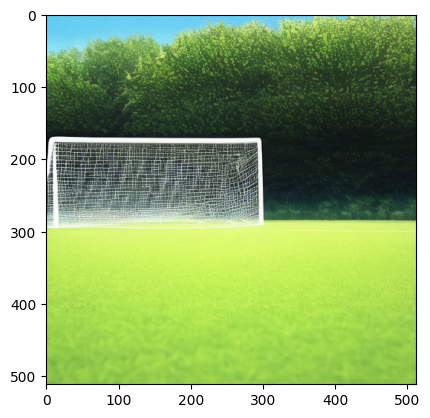

In [39]:
import matplotlib.pyplot as plt

plt.imshow(RGB_img_emb_tensor[::31][16])

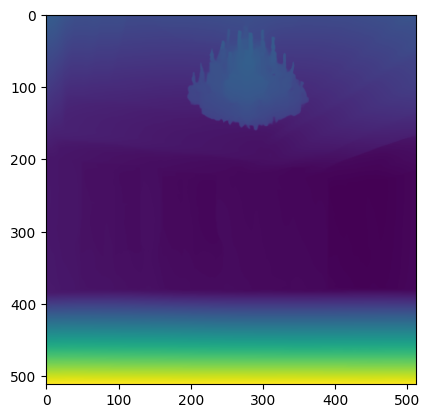

In [40]:
plt.imshow(Dep_img_tensor[::31][11])

In [41]:
RGB_img_emb_tensor[::31].shape

torch.Size([20, 512, 512, 3])

## 6.2 Synchronizing Checkpoints


In [46]:
os.makedirs("weight", exist_ok=True)

In [52]:
!apt-get update -qq && apt-get install -qq rsync
!rsync -avh --info=progress2 \
    "/content/drive/MyDrive/Master_Class/checkpoints/" \
    "/content/Master_Class/checkpoints/"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
sending incremental file list
./
ckpt_ep0.pth
        235.68M   1%  187.59MB/s    0:00:01 (xfr#1, to-chk=62/64)
ckpt_ep100.pth
        471.37M   3%  199.51MB/s    0:00:02 (xfr#2, to-chk=61/64)
ckpt_ep1000.pth
        707.05M   4%  246.71MB/s    0:00:02 (xfr#3, to-chk=60/64)
ckpt_ep1100.pth
        942.73M   6%  276.97MB/s    0:00:03 (xfr#4, to-chk=59/64)
ckpt_ep1200.pth
          1.18G   8%  299.76MB/s    0:00:03 (xfr#5, to-chk=58/64)
ckpt_ep1300.pth
          1.41G   9%  322.16MB/s    0:00:04 (xfr#6, to-chk=57/64)
ckpt_ep1400.pth
          1.65G  11%  339.01MB/s    0:00:04 (xfr#7, to-chk=56/64)
ckpt_ep1500.pth
          1.89G  12%  349.42MB/s    0:00:05 (xfr#8, to-chk=55/64)
ckpt_ep1600.pth
          2.12G  14%  354.95MB/s    0:00:05 (xfr#9, to-chk=54/64)
ckpt_ep1700.pth
          2.36G  16%  361.06

In [53]:
!ls -1 "/content/Master_Class/checkpoints/"


ckpt_ep0.pth
ckpt_ep1000.pth
ckpt_ep100.pth
ckpt_ep1100.pth
ckpt_ep1200.pth
ckpt_ep1300.pth
ckpt_ep1400.pth
ckpt_ep1500.pth
ckpt_ep1600.pth
ckpt_ep1700.pth
ckpt_ep1800.pth
ckpt_ep1900.pth
ckpt_ep2000.pth
ckpt_ep200.pth
ckpt_ep2100.pth
ckpt_ep2200.pth
ckpt_ep2300.pth
ckpt_ep2400.pth
ckpt_ep2500.pth
ckpt_ep2600.pth
ckpt_ep2700.pth
ckpt_ep2800.pth
ckpt_ep2900.pth
ckpt_ep3000.pth
ckpt_ep300.pth
ckpt_ep3100.pth
ckpt_ep400.pth
ckpt_ep500.pth
ckpt_ep600.pth
ckpt_ep6100.pth
ckpt_ep6900.pth
ckpt_ep700.pth
ckpt_ep7100.pth
ckpt_ep7200.pth
ckpt_ep7500.pth
ckpt_ep7600.pth
ckpt_ep7800.pth
ckpt_ep7900.pth
ckpt_ep8000.pth
ckpt_ep800.pth
ckpt_ep8100.pth
ckpt_ep8200.pth
ckpt_ep8300.pth
ckpt_ep8400.pth
ckpt_ep8500.pth
ckpt_ep8600.pth
ckpt_ep8700.pth
ckpt_ep8800.pth
ckpt_ep8900.pth
ckpt_ep9000.pth
ckpt_ep900.pth
ckpt_ep9100.pth
ckpt_ep9200.pth
ckpt_ep9300.pth
ckpt_ep9400.pth
ckpt_ep9500.pth
ckpt_ep9600.pth
ckpt_ep9700.pth
ckpt_ep9800.pth
ckpt_ep9900.pth
ckpt_ep9999.pth
ckpt_latest.pth
img_human_DepthRGB_l

# Step 7: Model Inference and Evaluation


## 7.1 Loading Model Checkpoint and Sample Generation


In [58]:
ckpt = torch.load("/content/Master_Class/checkpoints/ckpt_latest.pth", map_location="cuda")
sd   = ckpt["model_state_dict"]

In [61]:
model.load_state_dict(sd)

batch_size = 32

test_emb = [
    RGB_img_emb_tensor[:batch_size].cuda().float(),
    Dep_img_tensor[:batch_size].cuda().float()
]

test_dic = {"y":test_emb}
#print(test_dic)
for i in range(10):
    test_array = diffusion.p_sample_loop(
                model,
                (32, 138, 1,120),
                clip_denoised=False,
                progress=True,
                model_kwargs=test_dic)
    break

  0%|          | 0/1000 [00:00<?, ?it/s]

## 7.3 Multiple Sample Generation and Saving


In [70]:
ckpt = torch.load("/content/Master_Class/checkpoints/ckpt_latest.pth", map_location="cuda")
model.load_state_dict(ckpt["model_state_dict"])

batch_size = 10

test_emb = [
    RGB_img_emb_tensor[:batch_size].cuda().float(),
    Dep_img_tensor[:batch_size].cuda().float()
]
test_dic = {"y": test_emb}


test_dic = {"y":test_emb}
#print(test_dic)
for i in range(10):
    test_array = diffusion.p_sample_loop(
                model,
                (10, 138, 1,120),
                clip_denoised=False,
                progress=True,
                model_kwargs=test_dic)



    np.save("/content//Master_Class/Evaluation/our_cam_"+str(i)+".npy",np.array(test_array.cpu()))

LS=[]
for j in range(10):
    ls=[]
    for i in range(10):
        ls.append(np.load("/content//Master_Class/Evaluation/our_cam_"+str(i)+".npy")[j].transpose(1,2,0))

    LS.append(np.array(ls).reshape(10,120,138))
LS = np.array(LS)

np.save("/content//Master_Class/Evaluation/Depth_RGB_mmd.npy",LS)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

# Step 8: Post-processing and Result Analysis


## 8.1 Collecting and Organizing Results


In [71]:
LS.shape

(10, 10, 120, 138)

In [73]:
np.save("/content//Master_Class/Evaluation/Depth_RGB.npy",np.array(test_array.cpu()))

In [74]:
np.save("/content//Master_Class/Evaluation/Groundtruth.npy",np.array(motion_reshape_tensor.cpu()))

In [75]:
motion_reshape_tensor.shape

torch.Size([608, 138, 1, 120])

## 8.2 Smoothing and Preparing Final Output


In [77]:
from scipy.ndimage import gaussian_filter1d

Mean = np.load("single_mean.npy")
Std = np.load("single_std.npy")
test_data = test_array.cpu().detach()

#generated_data = motion_reshape_tensor[400].permute(1,2,0)[0]
generated_data = test_data[4].permute(1,2,0)[0]
smoothed_generated_data = np.copy(generated_data)

#print(smoothed_generated_data.shape)

for axis in range(138):
    smoothed_generated_data[:, axis] = gaussian_filter1d(generated_data[:, axis], sigma=1.5)


generated_data = (smoothed_generated_data*Std+Mean).reshape(-1,23,6)

D1 = np.array([1.0,0.0,0.0,
               0.0,1.0,0.0,
               0.0,0.0,1.0])
motion1 = generated_data

D2 = np.array([1.0,0.0,0.0,
               0.0,1.0,0.0,
               0.0,0.0,1.0])
motion2 = generated_data


np.save("/content//Master_Class/MDM/train/0_p0.npy",motion1)
np.save("/content//Master_Class/MDM/train/0_p1.npy",motion2)
np.save("/content//Master_Class/MDM/train/0_p0.npy",D1)
np.save("/content//Master_Class/MDM/train/0_p1.npy",D2)

In [78]:
test_data[:,:6][0]

tensor([[[-1.1590e-01, -1.2375e-02, -1.2742e-01,  2.5073e-01,  7.0528e-02,
           1.2749e-01,  1.1670e-01, -1.5507e-01,  2.8999e-02,  1.5034e-01,
           8.2488e-02, -6.6824e-02, -8.7317e-02, -1.0351e-02, -1.8388e-02,
           2.3652e-02, -1.7123e-01,  1.1147e-01,  1.7062e-02,  9.7808e-02,
           1.4735e-01, -2.7569e-03, -6.8336e-03, -1.1587e-03,  1.0701e-01,
          -4.2807e-02, -4.8316e-02, -3.3515e-02,  1.7613e-01, -6.0523e-02,
           3.2084e-01,  8.7465e-02,  6.9475e-02, -1.9316e-02,  7.4800e-02,
          -3.1169e-02,  3.9908e-02, -1.7759e-01,  1.9383e-01, -1.5850e-01,
           1.4816e-02, -3.4837e-02, -7.1060e-02,  5.1033e-02,  1.1287e-01,
          -1.5120e-01, -1.3015e-02, -4.2883e-02, -7.3687e-02,  1.1133e-01,
           6.6963e-02, -8.4330e-02, -6.5224e-02, -5.5843e-02,  5.9647e-02,
           8.8983e-02, -5.6147e-02, -8.3758e-03, -9.1280e-02, -9.4375e-02,
           6.4007e-03, -8.3053e-02, -3.3376e-02, -6.4544e-02,  9.7654e-02,
          -1.7345e-02, -3

## 8.3 Exporting Results to Google Drive


In [79]:
!zip -r /content/Master_Class.zip /content/Master_Class


流式输出内容被截断，只能显示最后 5000 行内容。
  adding: content/Master_Class/poses/007211.npy (deflated 15%)
  adding: content/Master_Class/poses/003499.npy (deflated 15%)
  adding: content/Master_Class/poses/M011583.npy (deflated 15%)
  adding: content/Master_Class/poses/M005165.npy (deflated 15%)
  adding: content/Master_Class/poses/010666.npy (deflated 15%)
  adding: content/Master_Class/poses/M000943.npy (deflated 15%)
  adding: content/Master_Class/poses/M009780.npy (deflated 15%)
  adding: content/Master_Class/poses/000248.npy (deflated 15%)
  adding: content/Master_Class/poses/M009331.npy (deflated 15%)
  adding: content/Master_Class/poses/012209.npy (deflated 15%)
  adding: content/Master_Class/poses/005879.npy (deflated 15%)
  adding: content/Master_Class/poses/008152.npy (deflated 15%)
  adding: content/Master_Class/poses/003293.npy (deflated 15%)
  adding: content/Master_Class/poses/004945.npy (deflated 15%)
  adding: content/Master_Class/poses/M010201.npy (deflated 15%)
  adding: content/Mast

In [80]:
!cp /content/Master_Class.zip "/content/drive/MyDrive/Master_Class.zip"
